In [1]:
import os
import shutil
import random
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

In [2]:
!curl -L "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" -o "animals/cats_and_dogs.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  786M    0  185k    0     0   754k      0  0:17:48 --:--:--  0:17:48  755k
  5  786M    5 43.3M    0     0  34.8M      0  0:00:22  0:00:01  0:00:21 34.8M
 11  786M   11 91.5M    0     0  40.7M      0  0:00:19  0:00:02  0:00:17 40.7M
 17  786M   17  140M    0     0  43.3M      0  0:00:18  0:00:03  0:00:15 43.3M
 24  786M   24  189M    0     0  44.6M      0  0:00:17  0:00:04  0:00:13 44.6M
 30  786M   30  241M    0     0  46.0M      0  0:00:17  0:00:05  0:00:12 48.2M
 36  786M   36  288M    0     0  46.1M      0  0:00:17  0:00:06  0:00:11 48.9M
 41  786M   41  328M    0     0  45.3M      0  0:00:17  0:00:07  0:00:10 47.3M
 46  786M   46  367M    0     0  44.5M      0  0:00:17  0:00:08  0:00:09 45.3M
 52  786M   52  414M    0     0  44.8M      0  0:00

In [3]:
def get_valid(file_path):
    correct_files = []
    for name in os.listdir(file_path):
        try:
            img = Image.open(file_path + "/" + name)
            correct_files.append(name)
        except UnidentifiedImageError:
            pass
    return correct_files

In [4]:
local_zip = 'animals/cats_and_dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('animals')
zip_ref.close()
classes = ['Cat', 'Dog']
original_cat_path = 'animals/PetImages/Cat'
original_dog_path = 'animals/PetImages/Dog'
original_cat = get_valid(original_cat_path)
original_dog = get_valid(original_dog_path)
random.seed(101)

random.shuffle(original_cat)
random.shuffle(original_dog)
size = min(len(original_cat), len(original_dog))
train_size = int(np.floor(0.7 * size))
valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size
base_directory = 'dataset'
os.mkdir(base_directory)
type_datasets = ['train', 'valid', 'test']
directories = {}

for type_dataset in type_datasets:
    directory = os.path.join(base_directory, type_dataset)
    os.mkdir(directory)
    for name_class in classes:
        animal = os.path.join(directory, name_class)
        os.mkdir(animal)
        directories[f'{type_dataset}_{name_class}'] = animal+'/'
index = 0

for name_cat, name_dog in zip(original_cat, original_dog):
        if index <= train_size:
            type_of_dataset = 'train'
        elif train_size < index <= (train_size + valid_size):
            type_of_dataset = 'valid'
        elif (train_size + valid_size) < index <= (train_size + valid_size + test_size):
            type_of_dataset = 'test'
        shutil.copyfile(src=(original_cat_path + '/' +name_cat), dst=(directories[f'{type_of_dataset}_Cat']+name_cat))
        shutil.copyfile(src=(original_dog_path + '/' + name_dog), dst=(directories[f'{type_of_dataset}_Dog']+name_dog))
        index += 1

print(f'Dog - train: {len(os.listdir(directories["train_Dog"]))}\tCat - train: {len(os.listdir(directories["train_Cat"]))}')
print(f'Dog - valid: {len(os.listdir(directories["valid_Dog"]))}\tCat - valid: {len(os.listdir(directories["valid_Cat"]))}')
print(f'Dog - test:  {len(os.listdir(directories["test_Dog"]))}\tCat - test:  {len(os.listdir(directories["test_Cat"]))}')

c:\Users\Urban\.conda\envs\kodilla-edu\lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Dog - train: 8750	Cat - train: 8750
Dog - valid: 2499	Cat - valid: 2499
Dog - test:  1250	Cat - test:  1250


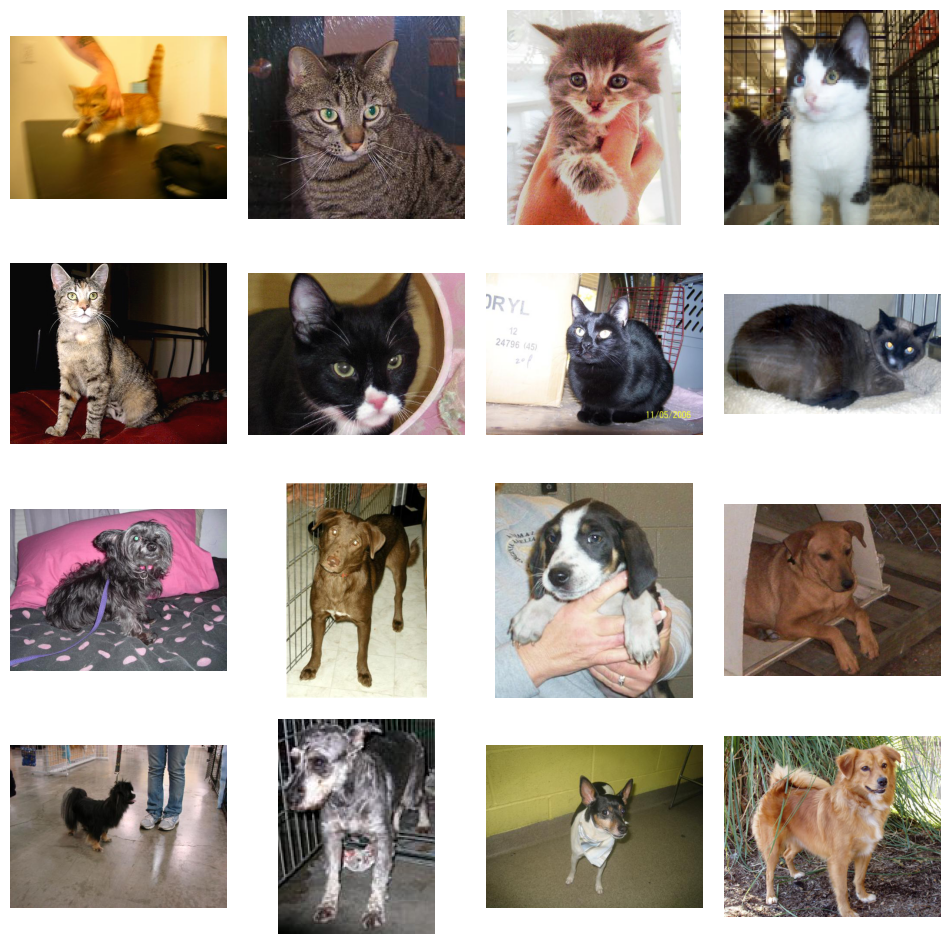

In [5]:
fig = plt.figure(figsize = (12, 12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for i, element in enumerate(os.listdir(os.path.join(directories["train_Cat"]))[:8]):
    ax = fig.add_subplot(4, 4, i+1)
    img = Image.open(directories["train_Cat"]+element)
    ax.imshow(img)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

for i, element in enumerate(os.listdir(os.path.join(directories["train_Dog"]))[:8]):
    ax = fig.add_subplot(4, 4, i+9)
    img = Image.open(directories["train_Dog"]+element)
    ax.imshow(img)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [6]:
img_width, img_height = 150, 150
train_data_dir = 'dataset/train/'
validation_data_dir = 'dataset/valid/'
epochs = 1000
batch_size = 64
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size
patience = 5
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size, class_mode='binary')
train_datagen_augmentation = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=30,
                                   horizontal_flip=True)
train_generator_augmentation = train_datagen_augmentation.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size, class_mode='binary')

Found 17500 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.
Found 17500 images belonging to 2 classes.


In [7]:
models = []
os.mkdir("history")
os.mkdir("charts")

In [8]:
model_baseline = Sequential()
model_baseline.add(Flatten(input_shape=(150, 150, 3)))
model_baseline.add(Dense(units=1, activation='sigmoid'))
model_baseline.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])
model_baseline.summary()
models.append("baseline")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 dense (Dense)               (None, 1)                 67501     
                                                                 
Total params: 67,501
Trainable params: 67,501
Non-trainable params: 0
_________________________________________________________________


In [9]:
es = EarlyStopping(patience=patience, monitor='val_accuracy', restore_best_weights=True, verbose=1)

In [10]:
history_baseline = model_baseline.fit(train_generator,
                                        steps_per_epoch=steps_per_epoch,
                                        epochs=epochs,
                                        validation_data=validation_generator,
                                        validation_steps=validation_steps,
                                        callbacks=[es])
history_baseline_df = pd.DataFrame(history_baseline.history)
history_baseline_csv_file = 'history/history_baseline.csv'

with open(history_baseline_csv_file, mode='w') as f:
    history_baseline_df.to_csv(f)

Epoch 1/1000
136/136 [==============================] - 124s 909ms/step - loss: 0.9806 - accuracy: 0.5083 - val_loss: 1.0763 - val_accuracy: 0.5004
Epoch 2/1000
136/136 [==============================] - 76s 558ms/step - loss: 0.9400 - accuracy: 0.5111 - val_loss: 1.2842 - val_accuracy: 0.5072
Epoch 3/1000
136/136 [==============================] - 44s 325ms/step - loss: 0.9430 - accuracy: 0.5149 - val_loss: 0.7807 - val_accuracy: 0.5228
Epoch 4/1000
136/136 [==============================] - 29s 212ms/step - loss: 0.9143 - accuracy: 0.5217 - val_loss: 1.0493 - val_accuracy: 0.5020
Epoch 5/1000
136/136 [==============================] - 22s 161ms/step - loss: 0.9159 - accuracy: 0.5214 - val_loss: 1.0148 - val_accuracy: 0.5092
Epoch 6/1000
136/136 [==============================] - 19s 137ms/step - loss: 0.9003 - accuracy: 0.5344 - val_loss: 0.9807 - val_accuracy: 0.5056
Epoch 7/1000
136/136 [==============================] - 17s 127ms/step - loss: 0.8957 - accuracy: 0.5412 - val_loss: 

In [11]:
def plot_history(models, history_folder='history', charts_folder='charts'):
    # Upewnij się, że folder na wykresy istnieje
    os.makedirs(charts_folder, exist_ok=True)
    
    max_index = 0
    min_accuracy = 1
    max_loss = 0
    colors = plt.cm.rainbow(np.linspace(0, 1, len(models)))
    
    # Ustal globalne wartości dla osi
    for model in models:
        df = pd.read_csv(f'{history_folder}/history_{model}.csv', index_col=0)
        df.index += 1
        if max_index < max(df.index):
            max_index = max(df.index)
        if min_accuracy > min(df[['accuracy', 'val_accuracy']].min()):
            min_accuracy = min(df[['accuracy', 'val_accuracy']].min())
        if max_loss < max(df[['loss', 'val_loss']].max()):
            max_loss = max(df[['loss', 'val_loss']].max())
    
    # Tworzenie wykresów dla każdego modelu
    for model in models:
        df = pd.read_csv(f'{history_folder}/history_{model}.csv', index_col=0)
        df.index += 1
        fig = plt.figure(figsize=(16, 12))
        
        # Wykres Accuracy
        ax = fig.add_subplot(211)
        ax.plot(df['accuracy'], "bp--")
        ax.plot(df['val_accuracy'], "rp--")
        ax.set_title(f'Model {model} Accuracy', fontsize=20)
        ax.set_ylabel('Accuracy', fontsize=15)
        ax.set_xlabel('Epoch', fontsize=15)
        ax.set_xlim([1, max_index])
        ax.set_ylim([min_accuracy, 1])
        
        for milestone in (0.7, 0.8, 0.9, 0.95):
            ax.axhline(milestone, color="k", linestyle="--")
            try:
                if min(df[df['val_accuracy'] >= milestone].index) > 1:
                    ax.axvline(min(df[df['val_accuracy'] >= milestone].index), color="g", linestyle="--")
                    ax.text(min(df[df['val_accuracy'] >= milestone].index) + 0.6, min_accuracy + 0.02,
                            f'Epoch: {min(df[df["val_accuracy"] >= milestone].index)}', rotation=90)
            except Exception:
                pass
        
        plt.legend(['Training', 'Validation'], loc='lower right')
        
        # Wykres Loss
        ax = fig.add_subplot(212)
        ax.plot(df['loss'], "bp--")
        ax.plot(df['val_loss'], "rp--")
        ax.set_title(f'Model {model} Loss', fontsize=20)
        ax.set_ylabel('Loss', fontsize=15)
        ax.set_xlabel('Epoch', fontsize=15)
        ax.set_xlim([1, max_index])
        ax.set_ylim([0, max_loss])
        ax.legend(['Training', 'Validation'], loc='upper right')
        
        plt.tight_layout()
        plt.savefig(f'{charts_folder}/train_history_{model}.png', transparent=True, dpi=600)
        plt.show()
    
    # Wykresy porównujące wszystkie modele
    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(211)
    for model, color in zip(models, colors):
        df = pd.read_csv(f'{history_folder}/history_{model}.csv', index_col=0)
        df.index += 1
        ax.plot(df['val_accuracy'], label=f'Model {model}', color=color, linewidth=3)
        ax.axhline(df['val_accuracy'].max(), color=color, linestyle="dotted", linewidth=4)
    
    ax.set_title('Accuracy', fontsize=20)
    ax.set_ylabel('Accuracy', fontsize=15)
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_xlim([1, max_index])
    ax.set_ylim([min_accuracy, 1])
    for milestone in (0.7, 0.8, 0.9, 0.95):
        ax.axhline(milestone, color="k", linestyle="--")
    plt.legend(loc='lower right')
    
    ax = fig.add_subplot(212)
    for model, color in zip(models, colors):
        df = pd.read_csv(f'{history_folder}/history_{model}.csv', index_col=0)
        df.index += 1
        ax.plot(df['val_loss'], label=f'Model {model}', color=color, linewidth=3)
        ax.axhline(df['val_loss'].min(), color=color, linestyle="dotted", linewidth=4)
    
    ax.set_title('Loss', fontsize=20)
    ax.set_ylabel('Loss', fontsize=15)
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_xlim([1, max_index])
    ax.set_ylim([0, max_loss])
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.savefig(f'{charts_folder}/train_history_of_each_model.png', transparent=True, dpi=600)
    plt.show()

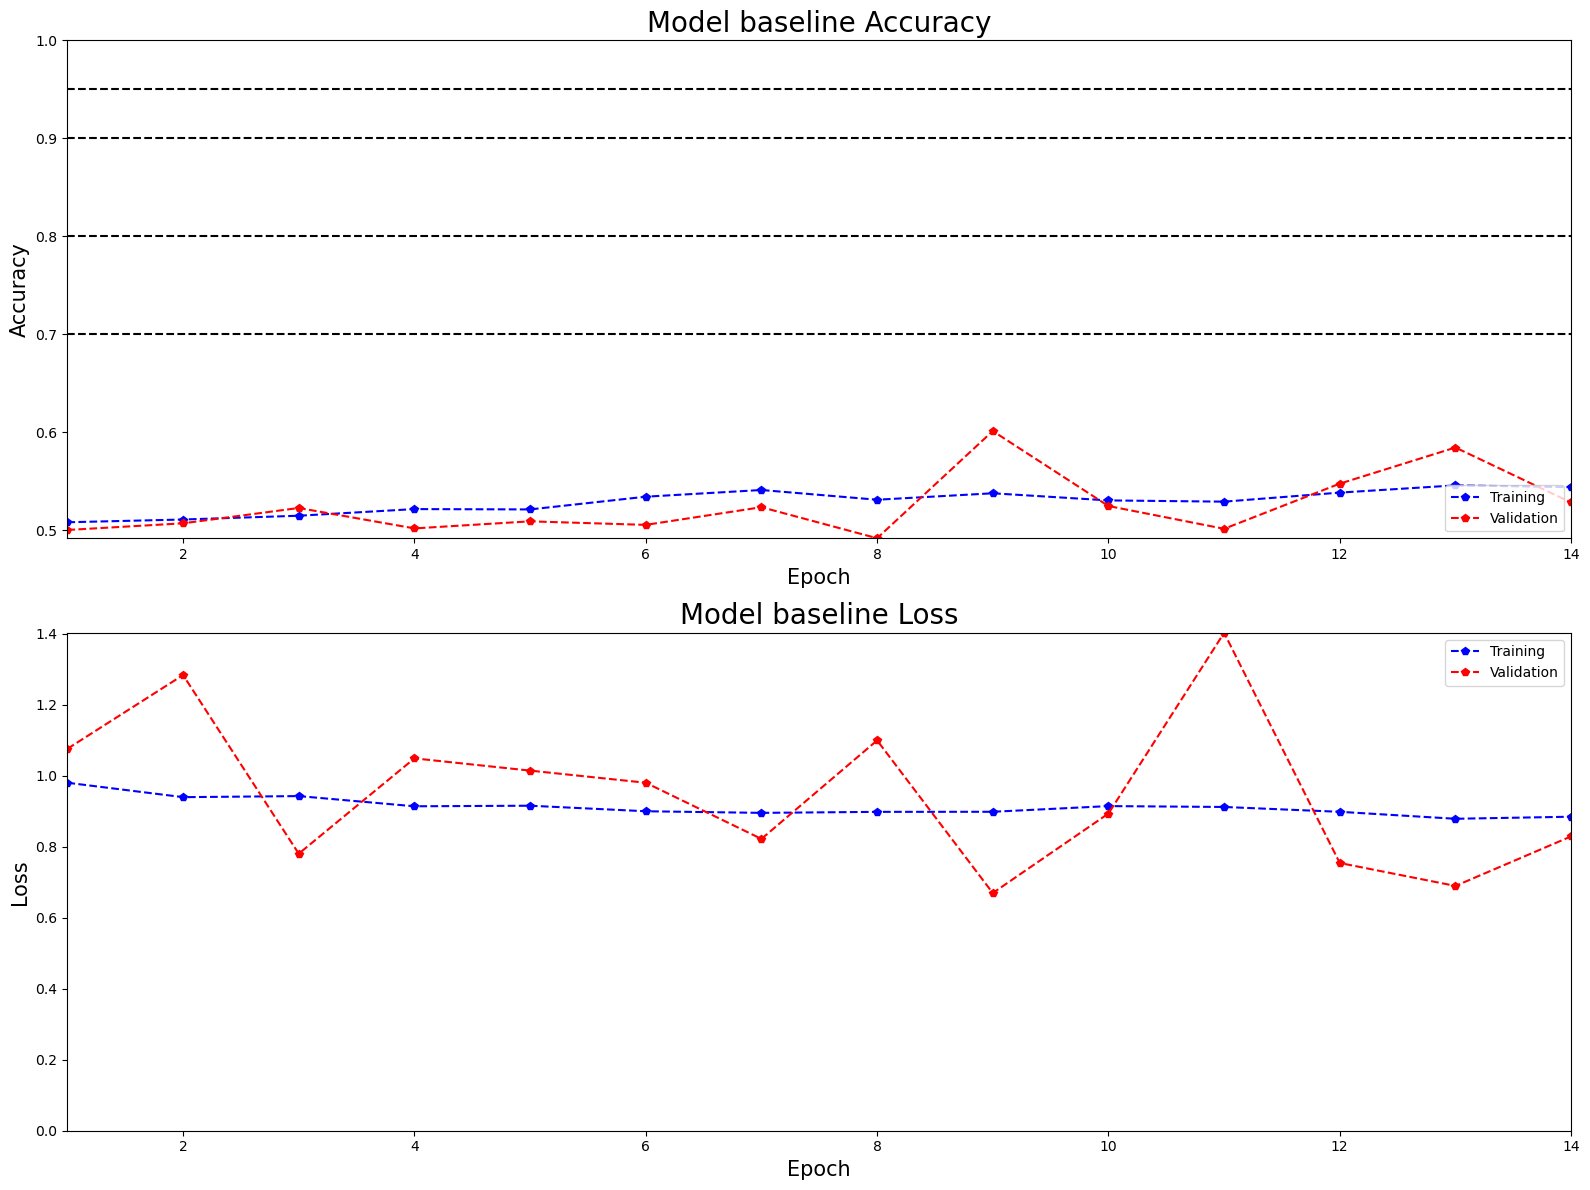

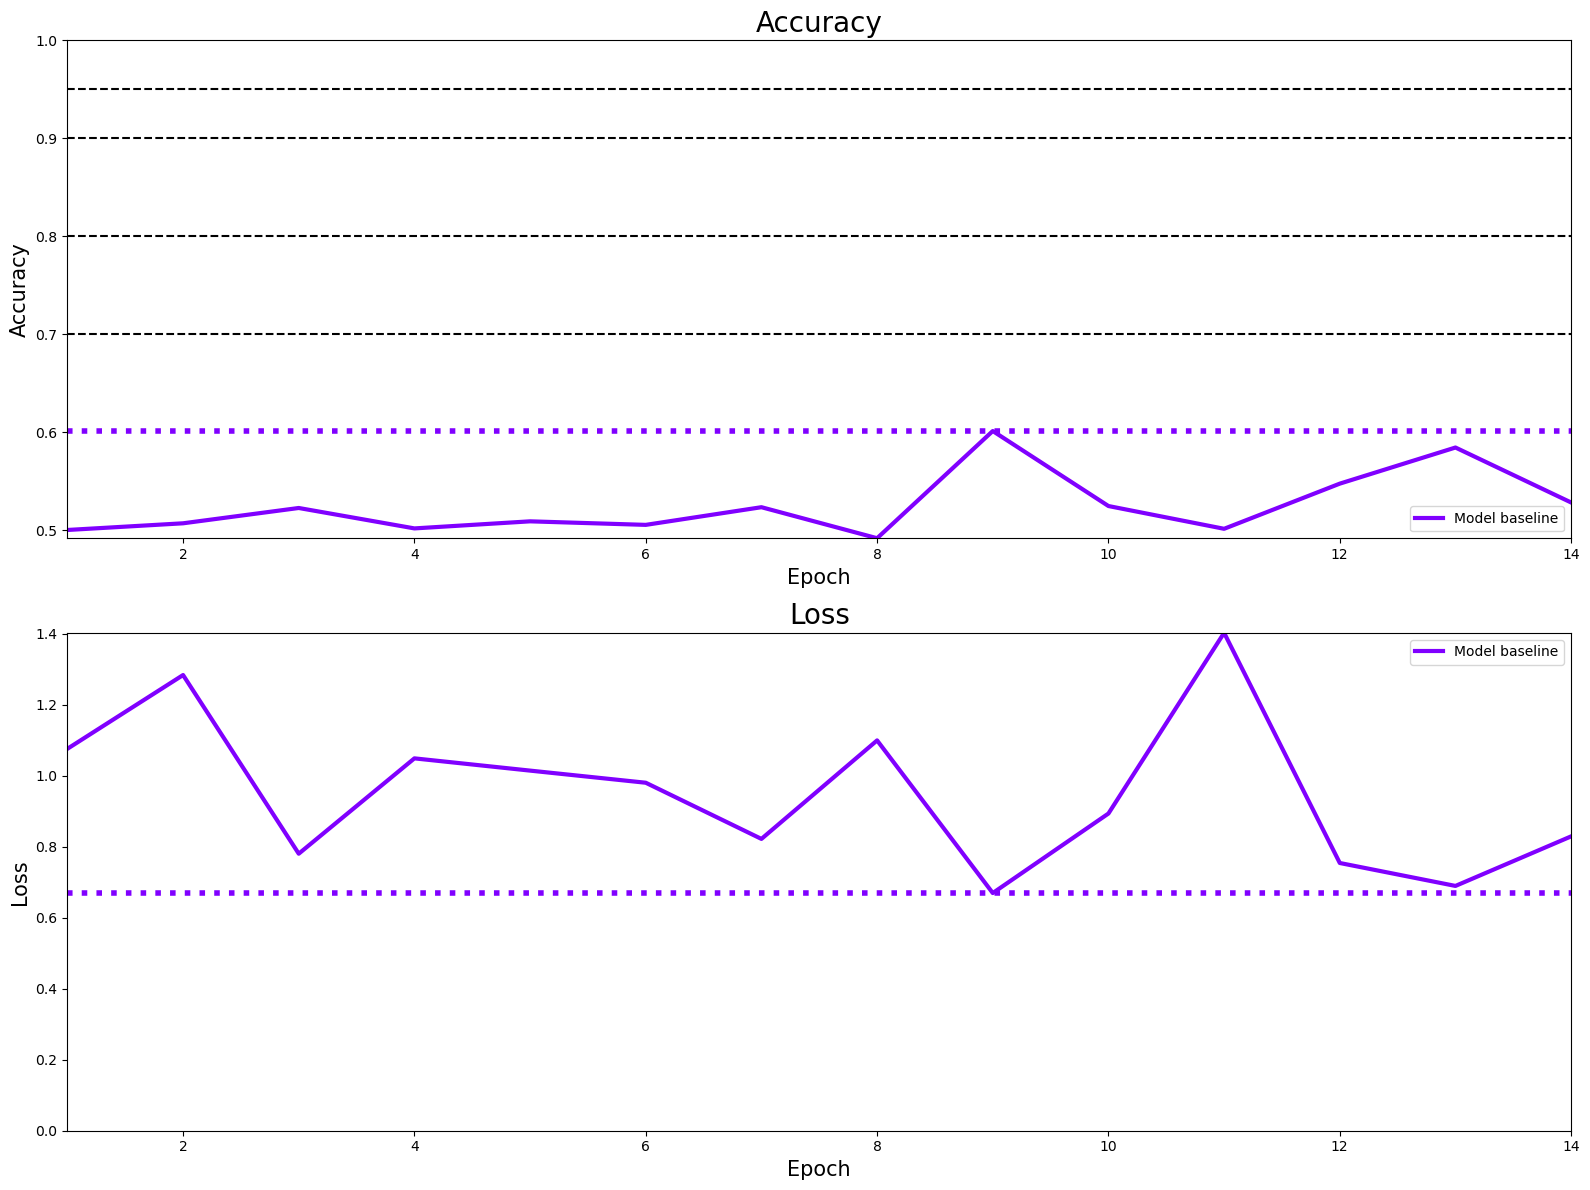

In [12]:
plot_history(models)

In [13]:
model_simple_1 = Sequential()
model_simple_1.add(Conv2D(filters=10, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model_simple_1.add(MaxPooling2D(2, 2))
model_simple_1.add(Flatten())
model_simple_1.add(Dense(units=1, activation='sigmoid'))
model_simple_1.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])
model_simple_1.summary()
models.append("simple_1")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 10)      280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 10)       0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 54760)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 54761     
                                                                 
Total params: 55,041
Trainable params: 55,041
Non-trainable params: 0
_________________________________________________________________


In [14]:
history_simple_1 = model_simple_1.fit(train_generator,
                                        steps_per_epoch=steps_per_epoch,
                                        epochs=epochs,
                                        validation_data=validation_generator,
                                        validation_steps=validation_steps,
                                        callbacks=[es])

history_simple_1_df = pd.DataFrame(history_simple_1.history)
history_simple_1_csv_file = 'history/history_simple_1.csv'

with open(history_simple_1_csv_file, mode='w') as f:
    history_simple_1_df.to_csv(f)

Epoch 1/1000
123/136 [==========================>...] - ETA: 1s - loss: 0.8507 - accuracy: 0.5596

c:\Users\Urban\.conda\envs\kodilla-edu\lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


136/136 [==============================] - 23s 111ms/step - loss: 0.8305 - accuracy: 0.5648 - val_loss: 0.6971 - val_accuracy: 0.5761
Epoch 2/1000
136/136 [==============================] - 15s 110ms/step - loss: 0.5912 - accuracy: 0.6782 - val_loss: 0.5654 - val_accuracy: 0.7135
Epoch 3/1000
136/136 [==============================] - 15s 110ms/step - loss: 0.5443 - accuracy: 0.7200 - val_loss: 0.5587 - val_accuracy: 0.7151
Epoch 4/1000
136/136 [==============================] - 15s 109ms/step - loss: 0.5225 - accuracy: 0.7388 - val_loss: 0.5855 - val_accuracy: 0.6883
Epoch 5/1000
136/136 [==============================] - 15s 110ms/step - loss: 0.4989 - accuracy: 0.7591 - val_loss: 0.5667 - val_accuracy: 0.7075
Epoch 6/1000
136/136 [==============================] - 15s 112ms/step - loss: 0.4810 - accuracy: 0.7709 - val_loss: 0.5488 - val_accuracy: 0.7208
Epoch 7/1000
136/136 [==============================] - 15s 112ms/step - loss: 0.4599 - accuracy: 0.7832 - val_loss: 0.5804 - val_a

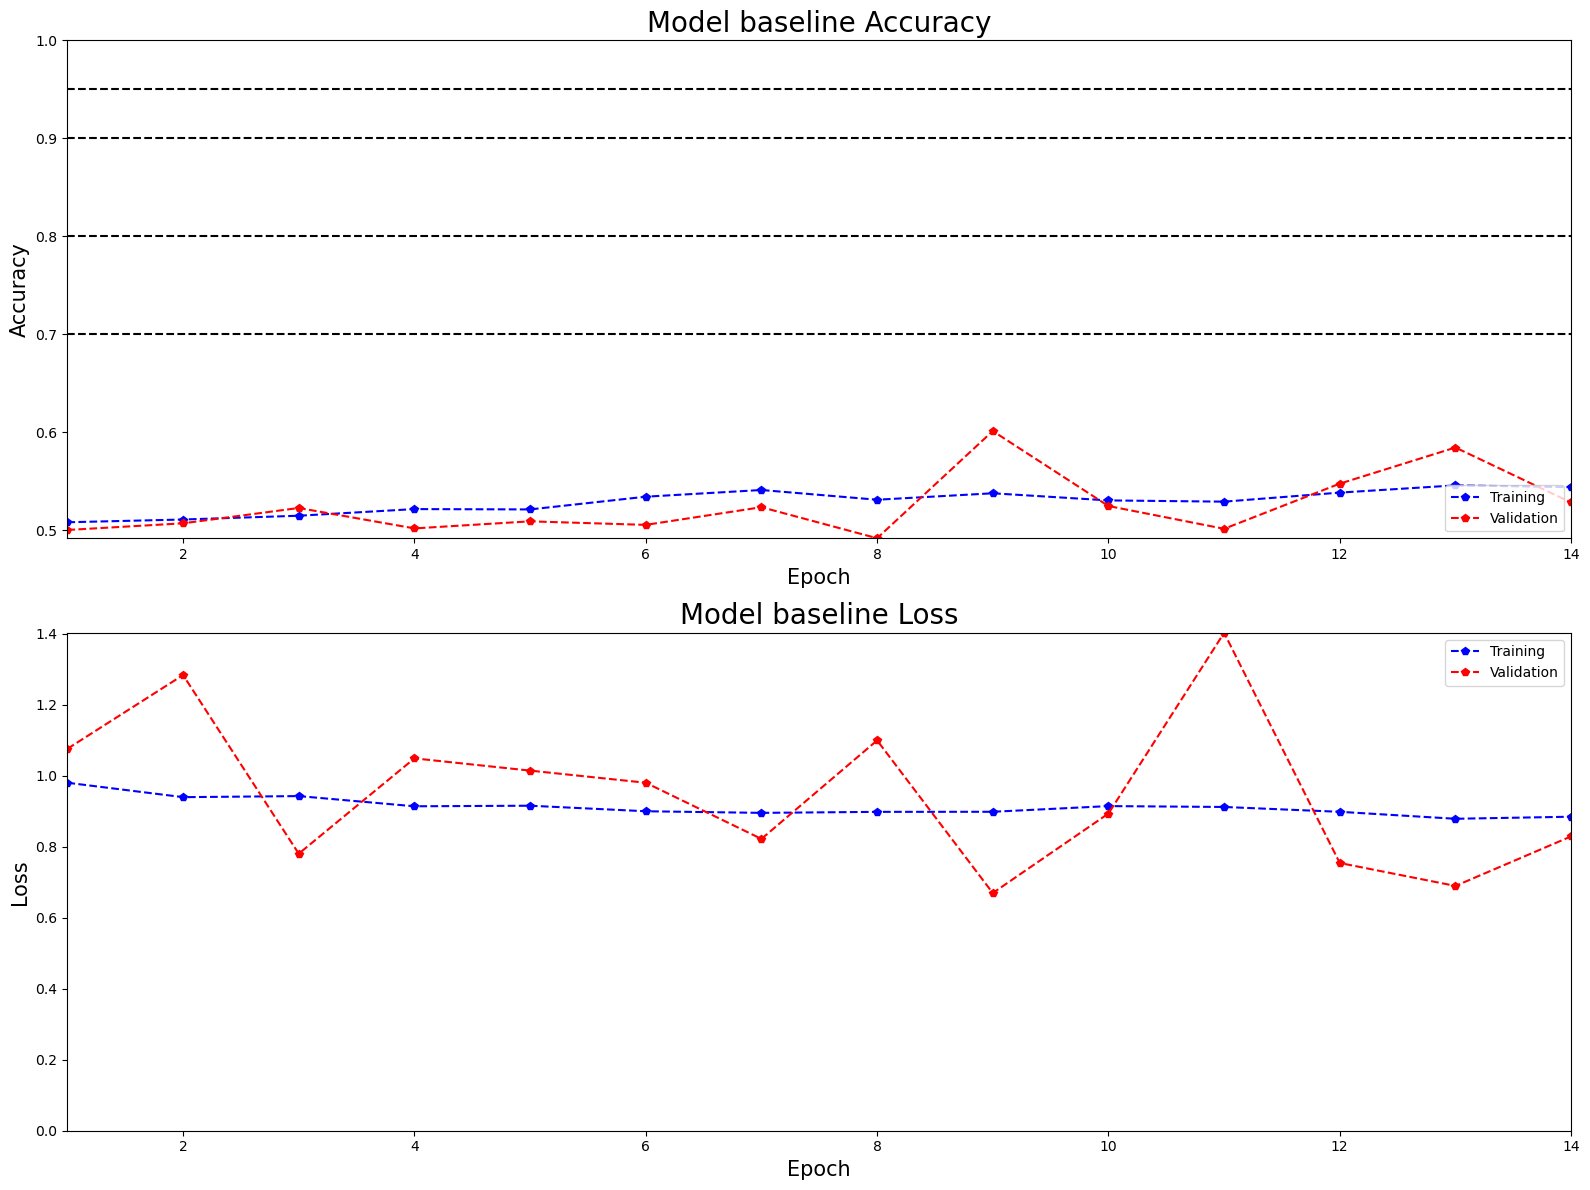

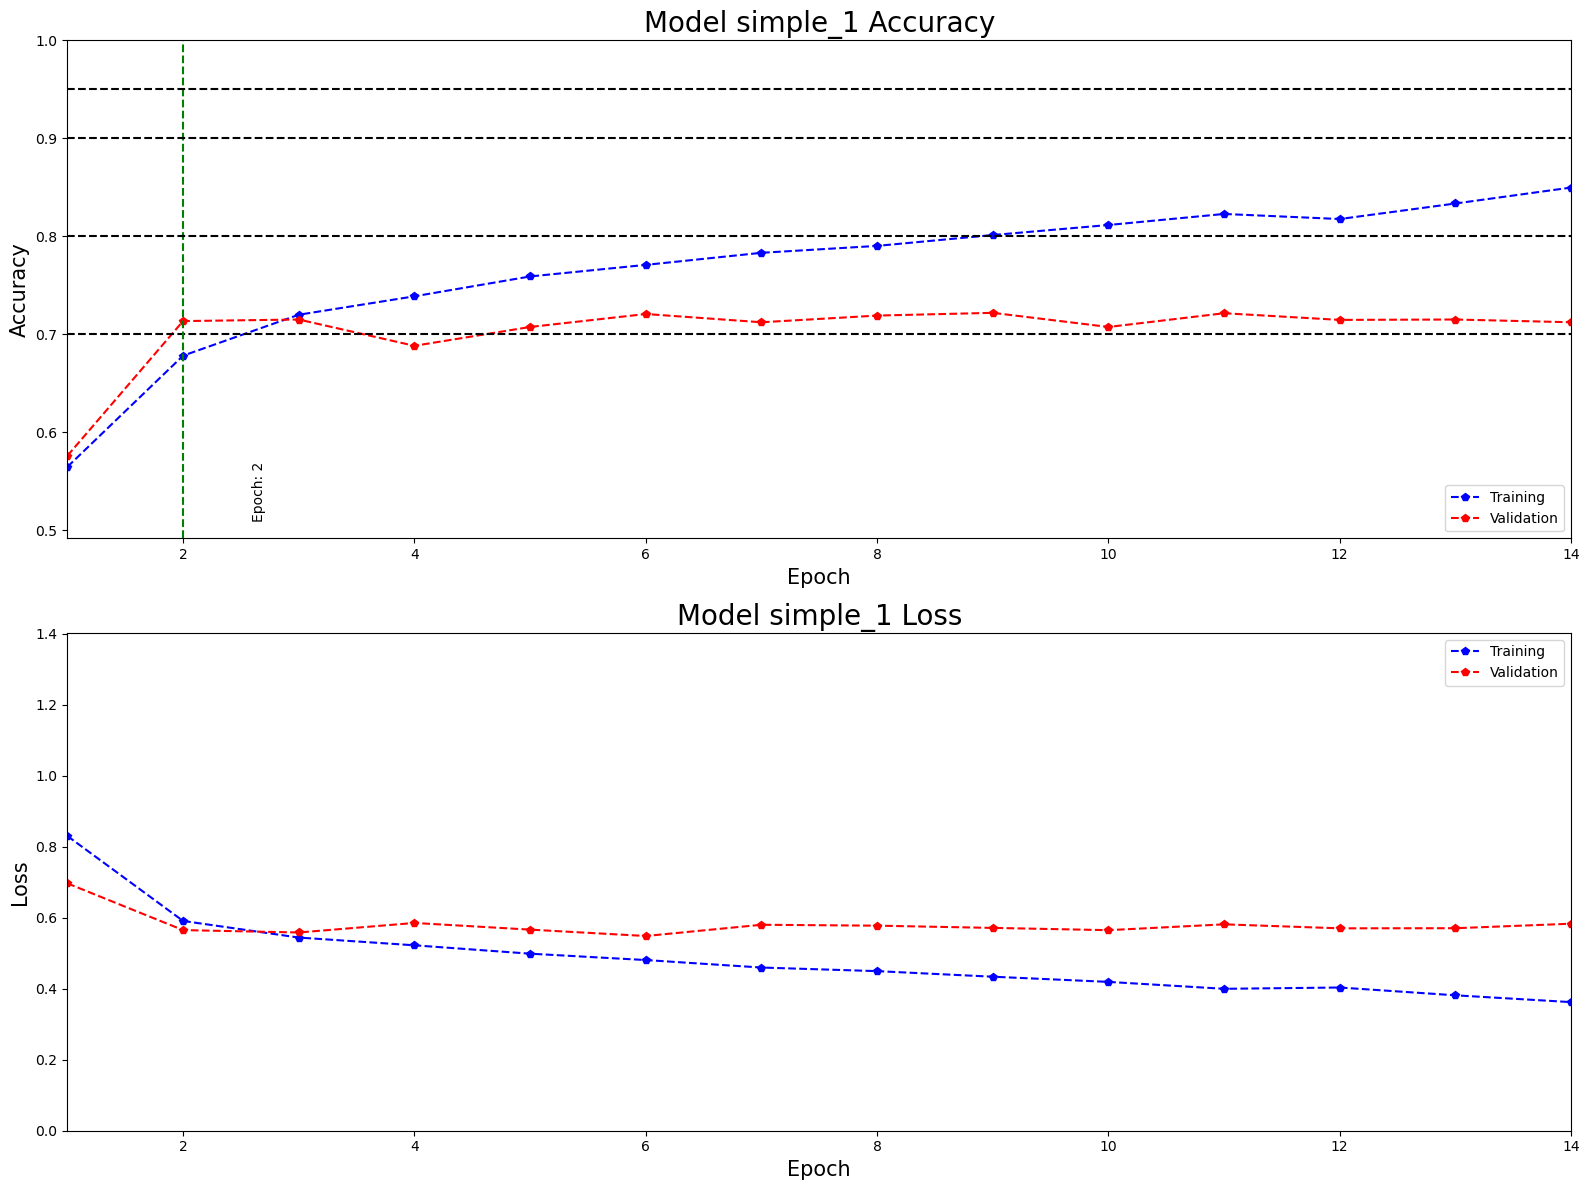

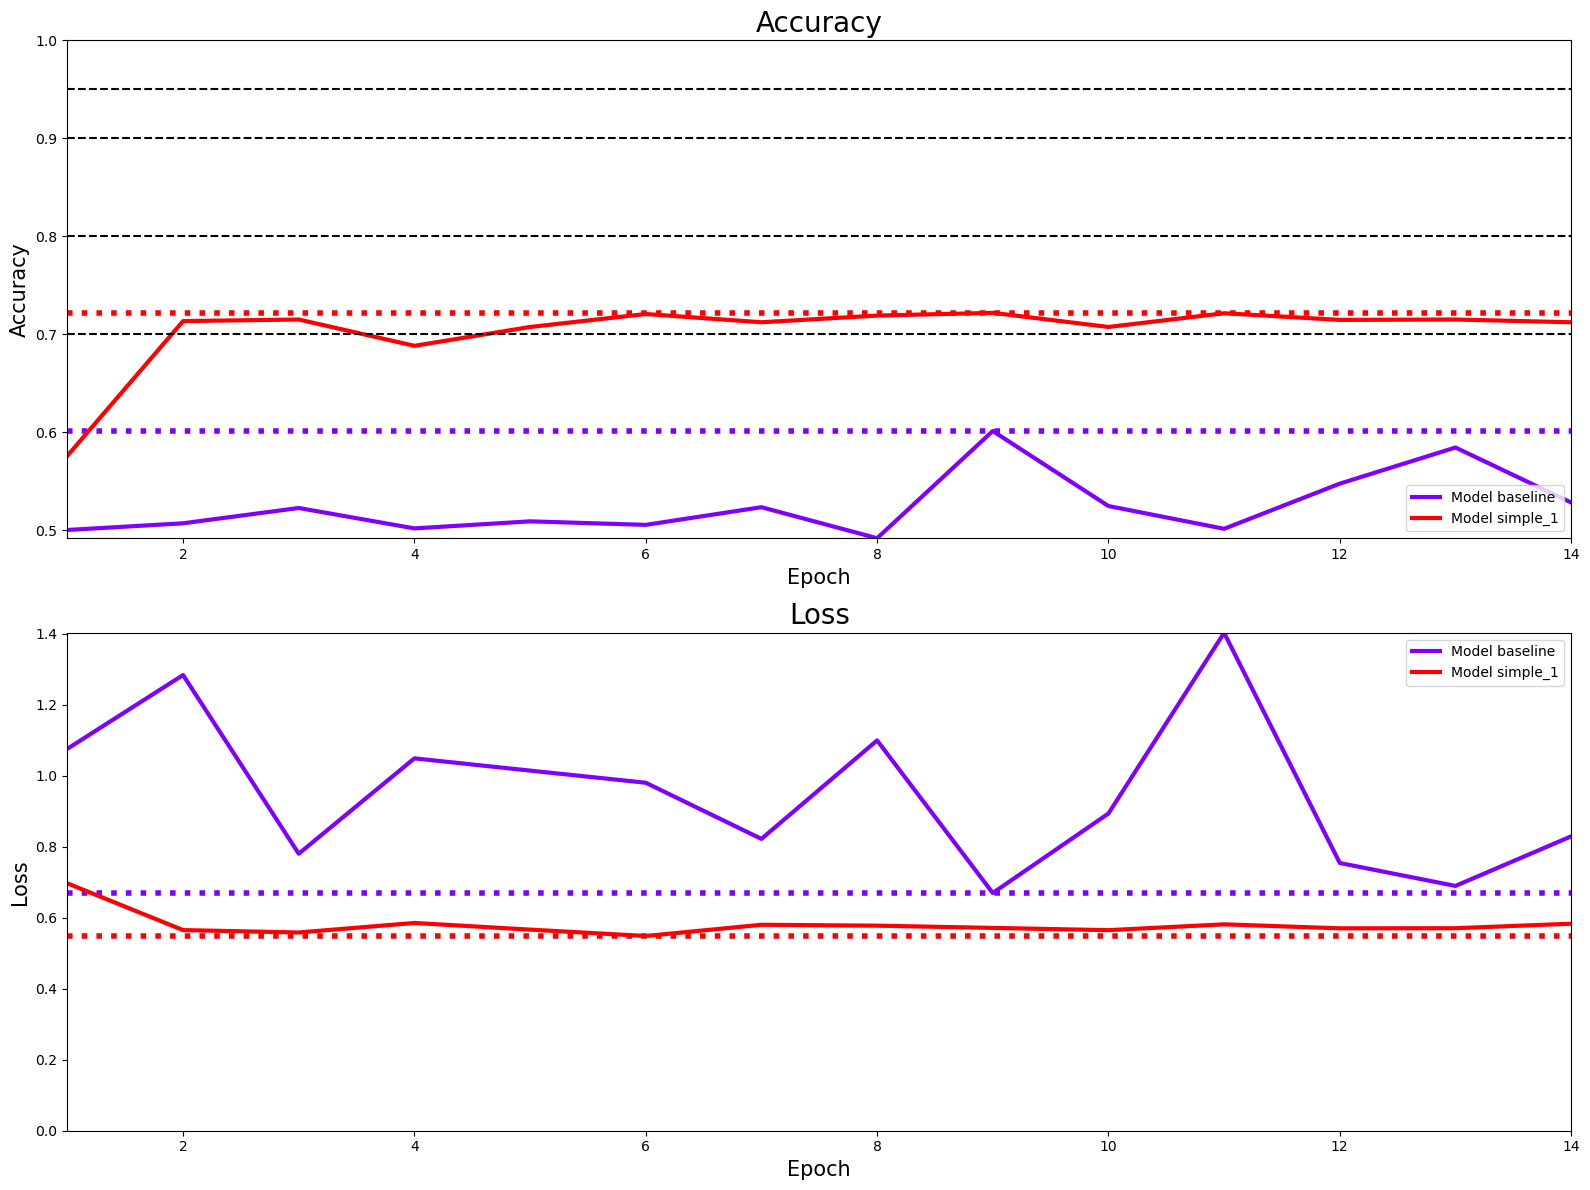

In [15]:
plot_history(models)

In [16]:
model_simple_2 = Sequential()
model_simple_2.add(Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)))
model_simple_2.add(MaxPooling2D(2, 2))
model_simple_2.add(Flatten())
model_simple_2.add(Dense(units=1, activation='sigmoid'))
model_simple_2.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])
model_simple_2.summary()
models.append("simple_2")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 150, 150, 10)      280       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 10)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 56250)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 56251     
                                                                 
Total params: 56,531
Trainable params: 56,531
Non-trainable params: 0
_________________________________________________________________


In [17]:
history_simple_2 = model_simple_2.fit(train_generator,
                                        steps_per_epoch=steps_per_epoch,
                                        epochs=epochs,
                                        validation_data=validation_generator,
                                        validation_steps=validation_steps,
                                        callbacks=[es])

history_simple_2_df = pd.DataFrame(history_simple_2.history)
history_simple_2_csv_file = 'history/history_simple_2.csv'

with open(history_simple_2_csv_file, mode='w') as f:
    history_simple_2_df.to_csv(f)

Epoch 1/1000
136/136 [==============================] - 15s 110ms/step - loss: 0.8358 - accuracy: 0.5691 - val_loss: 0.6444 - val_accuracy: 0.6318
Epoch 2/1000
132/136 [============================>.] - ETA: 0s - loss: 0.6113 - accuracy: 0.6651

c:\Users\Urban\.conda\envs\kodilla-edu\lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


136/136 [==============================] - 15s 109ms/step - loss: 0.6109 - accuracy: 0.6650 - val_loss: 0.6006 - val_accuracy: 0.6719
Epoch 3/1000
136/136 [==============================] - 15s 108ms/step - loss: 0.5626 - accuracy: 0.7134 - val_loss: 0.6008 - val_accuracy: 0.6847
Epoch 4/1000
136/136 [==============================] - 15s 109ms/step - loss: 0.5329 - accuracy: 0.7345 - val_loss: 0.5692 - val_accuracy: 0.7143
Epoch 5/1000
136/136 [==============================] - 15s 111ms/step - loss: 0.4957 - accuracy: 0.7664 - val_loss: 0.5856 - val_accuracy: 0.6959
Epoch 6/1000
136/136 [==============================] - 15s 112ms/step - loss: 0.4897 - accuracy: 0.7687 - val_loss: 0.5718 - val_accuracy: 0.7079
Epoch 7/1000
136/136 [==============================] - 15s 111ms/step - loss: 0.4658 - accuracy: 0.7812 - val_loss: 0.5629 - val_accuracy: 0.7123
Epoch 8/1000
136/136 [==============================] - 15s 111ms/step - loss: 0.4447 - accuracy: 0.7957 - val_loss: 0.5783 - val_a

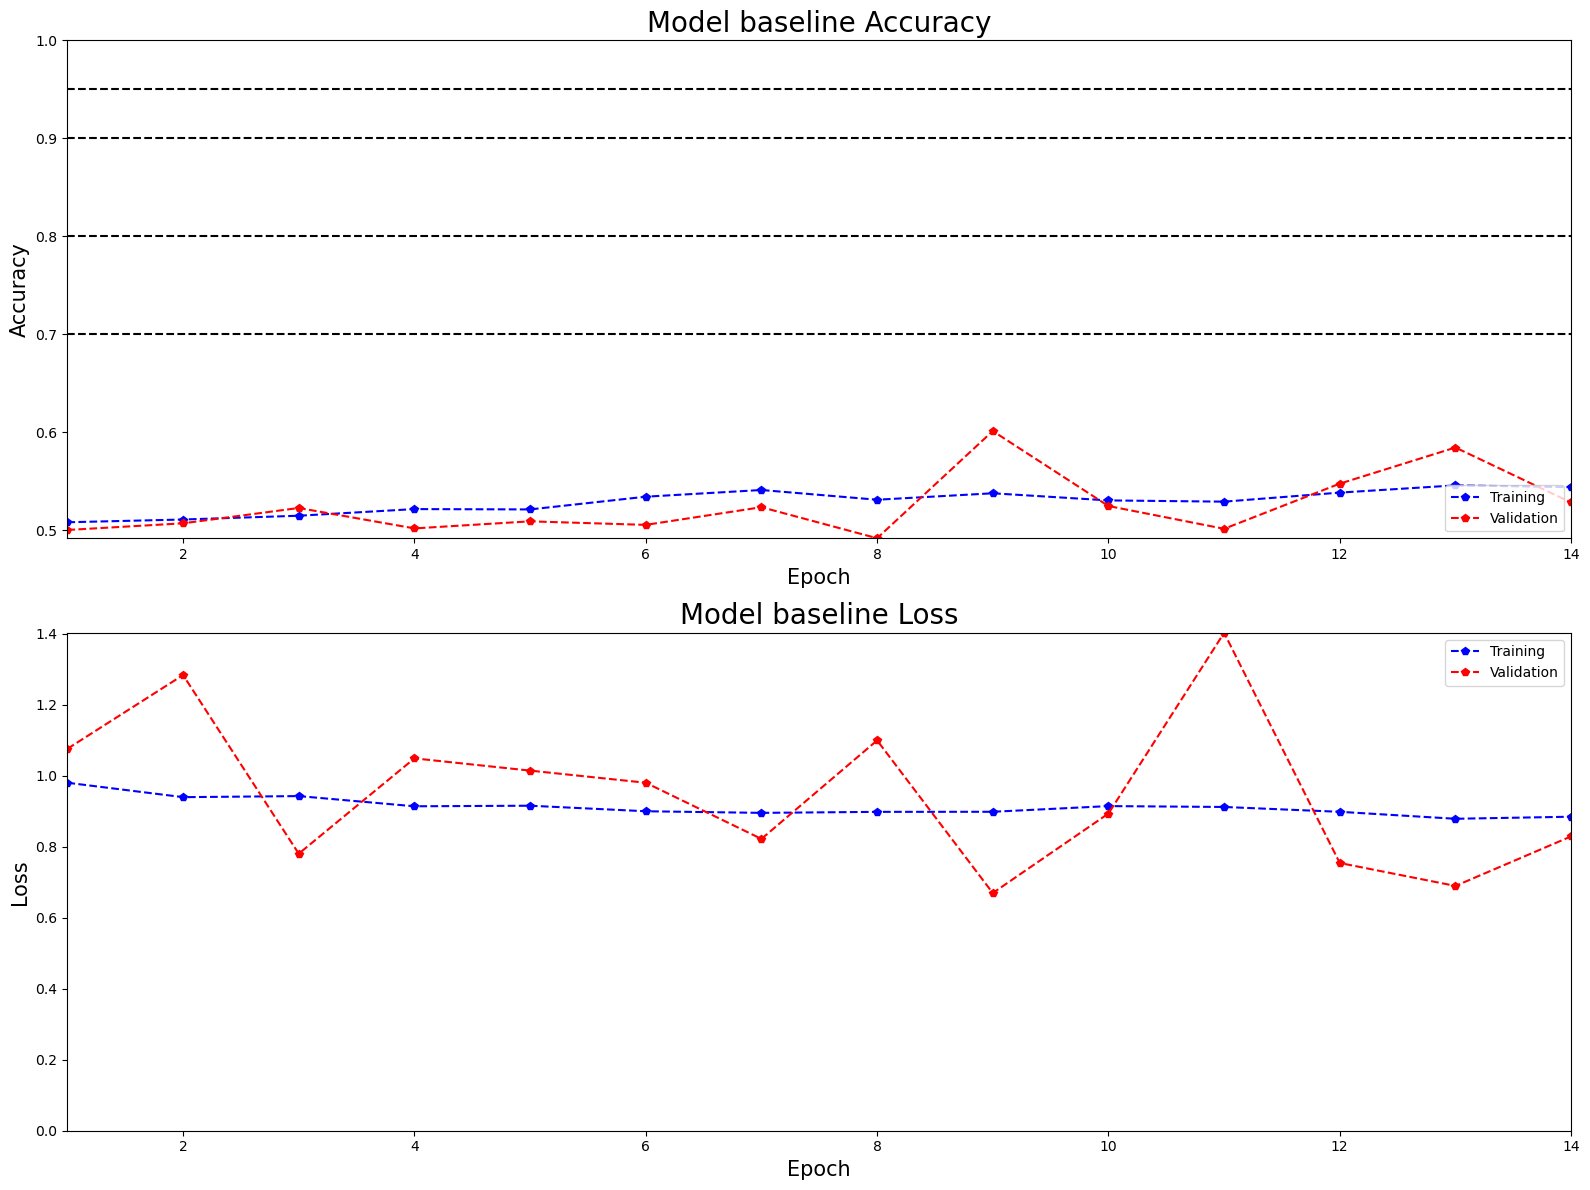

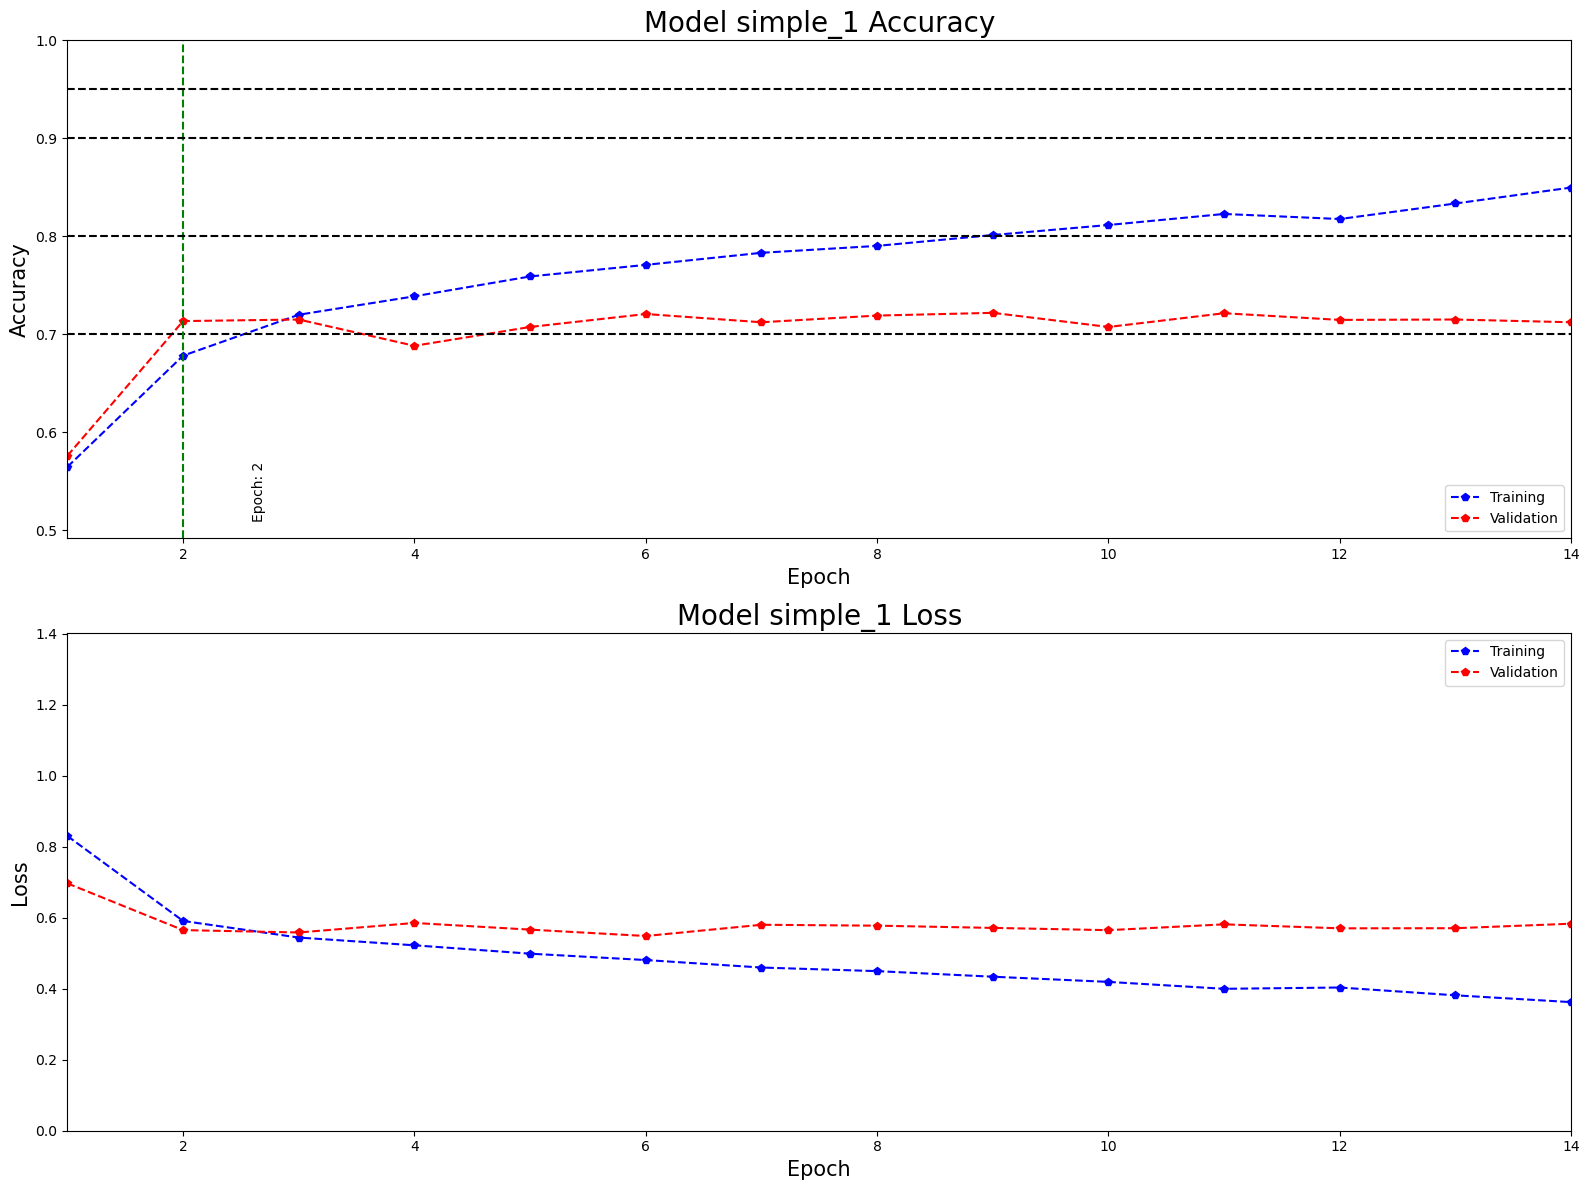

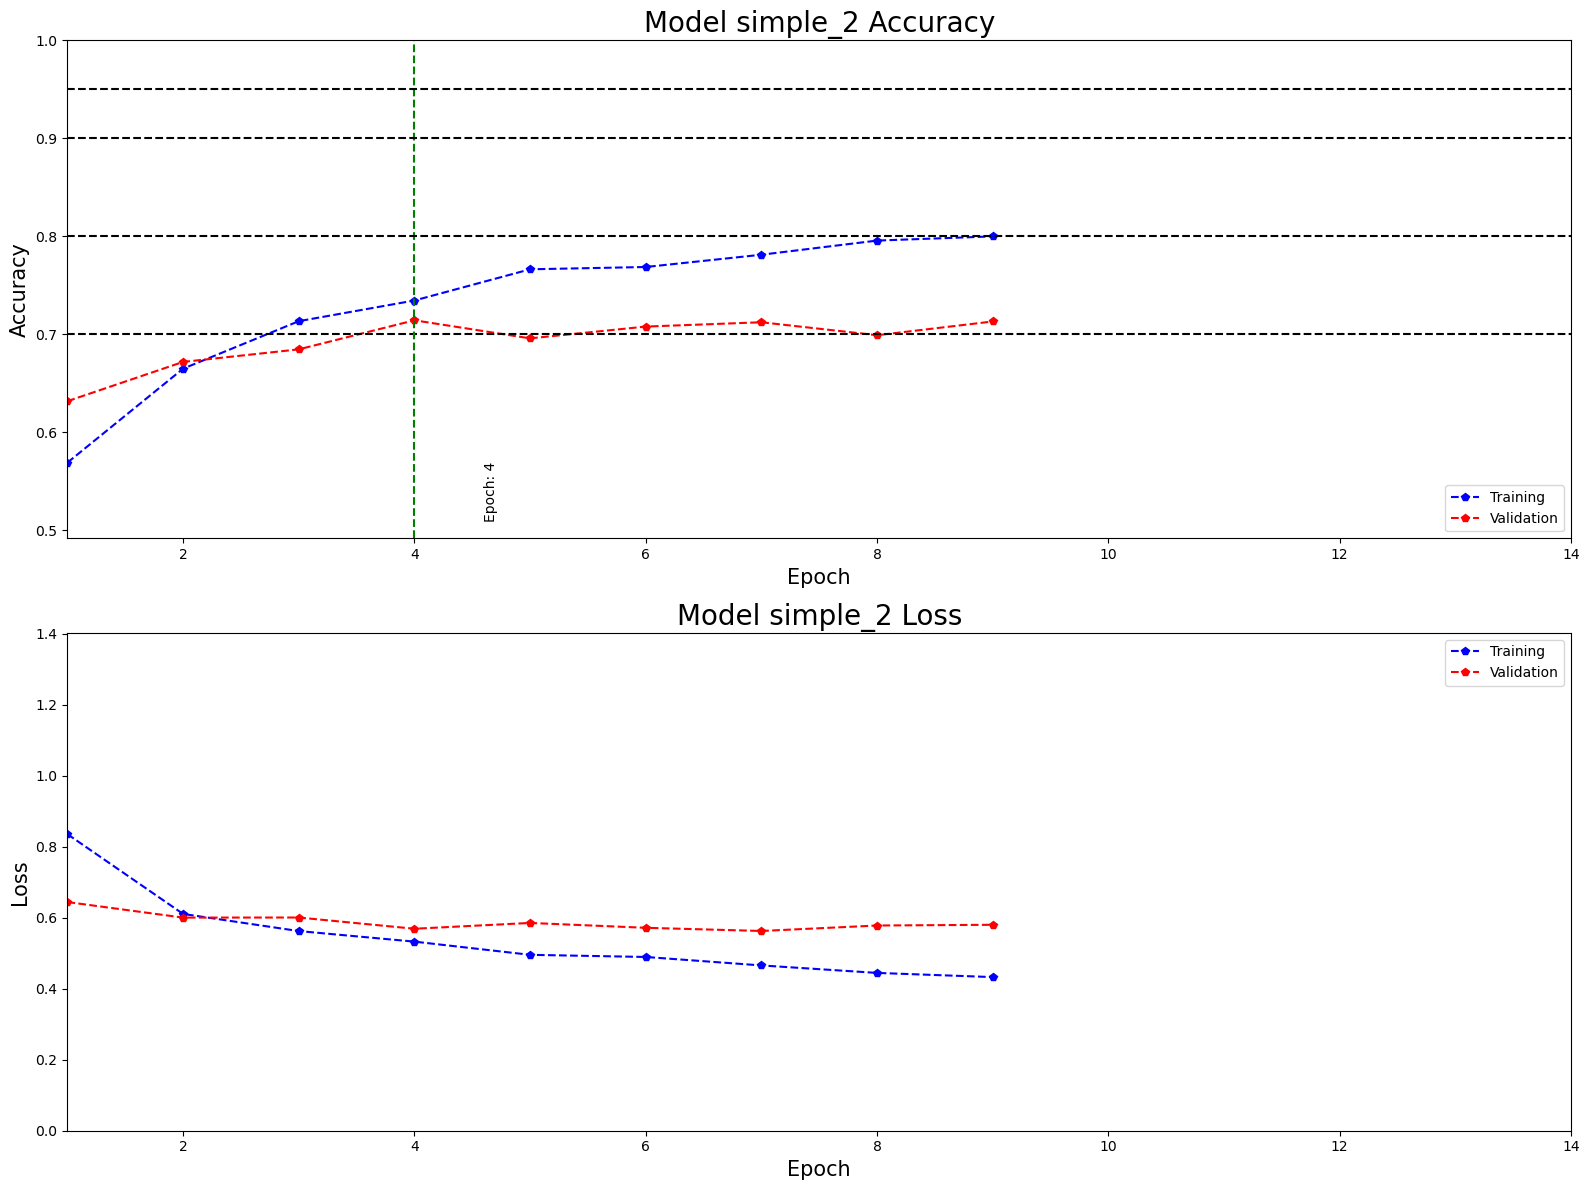

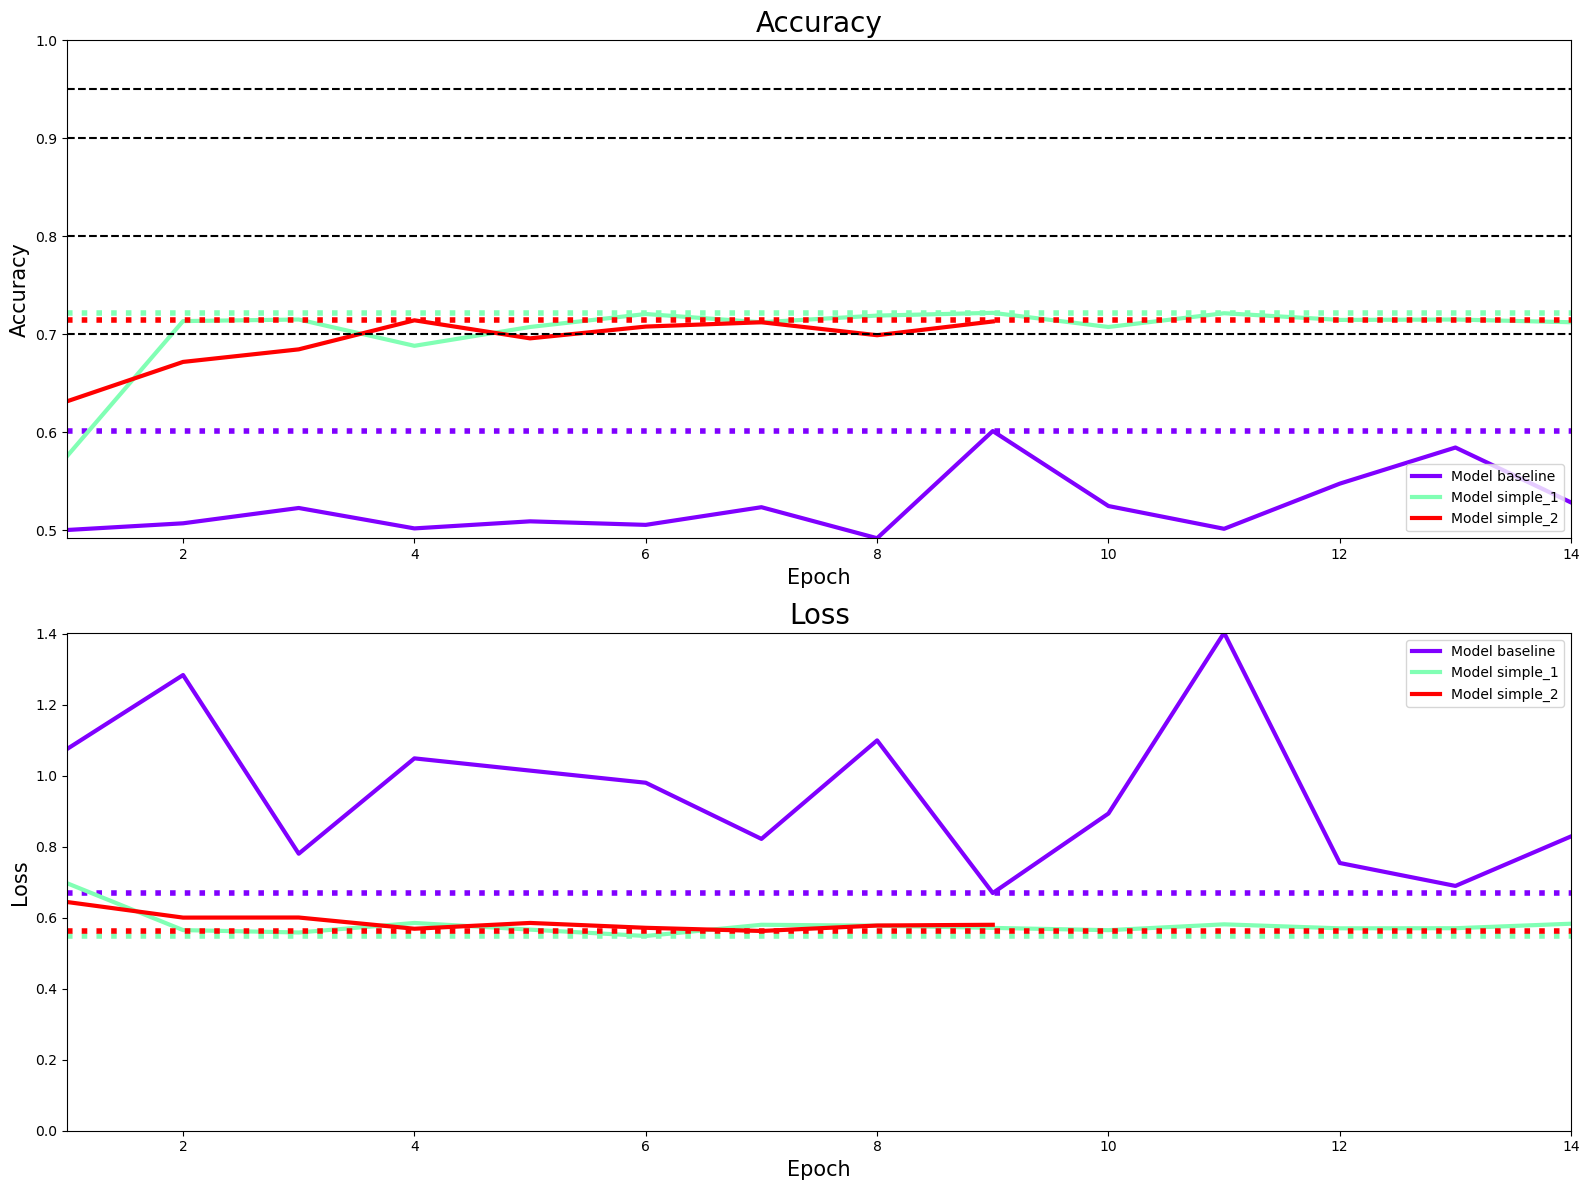

In [18]:
plot_history(models)

In [19]:
model_1 = Sequential()

# Block 1
model_1.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_1.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model_1.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Flatten())
model_1.add(Dense(256, activation='relu'))
model_1.add(Dense(128, activation='relu'))
model_1.add(Dense(units=1, activation='sigmoid'))
model_1.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])
model_1.summary()
models.append("model_1")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 conv2d_3 (Conv2D)           (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                  

In [20]:
history_model_1 = model_1.fit(train_generator,
                                steps_per_epoch=steps_per_epoch,
                                epochs=epochs,
                                validation_data=validation_generator,
                                validation_steps=validation_steps,
                                callbacks=[es])

history_model_1_df = pd.DataFrame(history_model_1.history)
history_model_1_csv_file = 'history/history_model_1.csv'

with open(history_model_1_csv_file, mode='w') as f:
    history_model_1_df.to_csv(f)

Epoch 1/1000
136/136 [==============================] - ETA: 0s - loss: 0.6818 - accuracy: 0.5565

c:\Users\Urban\.conda\envs\kodilla-edu\lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


136/136 [==============================] - 17s 113ms/step - loss: 0.6818 - accuracy: 0.5565 - val_loss: 0.6506 - val_accuracy: 0.6214
Epoch 2/1000
136/136 [==============================] - 16s 114ms/step - loss: 0.6363 - accuracy: 0.6372 - val_loss: 0.6025 - val_accuracy: 0.6755
Epoch 3/1000
136/136 [==============================] - 15s 110ms/step - loss: 0.5801 - accuracy: 0.6969 - val_loss: 0.5610 - val_accuracy: 0.7039
Epoch 4/1000
136/136 [==============================] - 15s 111ms/step - loss: 0.5498 - accuracy: 0.7132 - val_loss: 0.5399 - val_accuracy: 0.7284
Epoch 5/1000
136/136 [==============================] - 15s 109ms/step - loss: 0.5359 - accuracy: 0.7262 - val_loss: 0.6004 - val_accuracy: 0.6859
Epoch 6/1000
136/136 [==============================] - 15s 111ms/step - loss: 0.5218 - accuracy: 0.7402 - val_loss: 0.5151 - val_accuracy: 0.7508
Epoch 7/1000
136/136 [==============================] - 15s 110ms/step - loss: 0.5018 - accuracy: 0.7479 - val_loss: 0.5073 - val_a

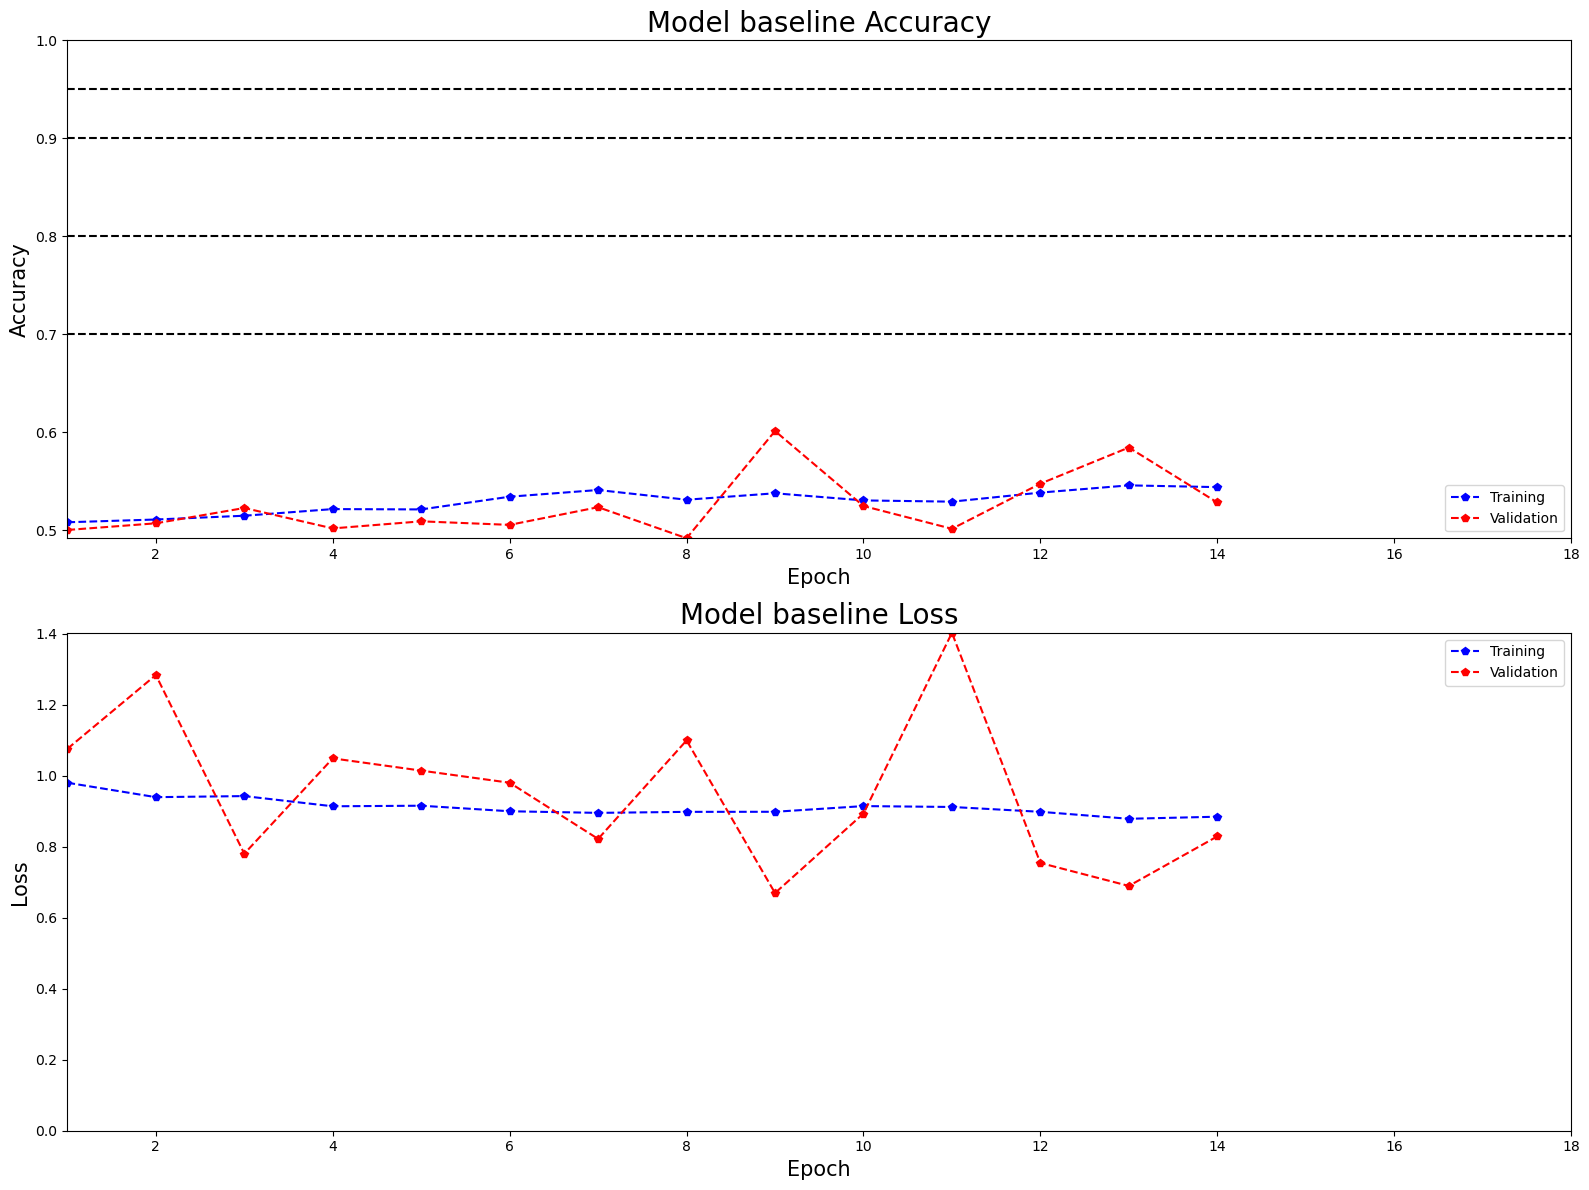

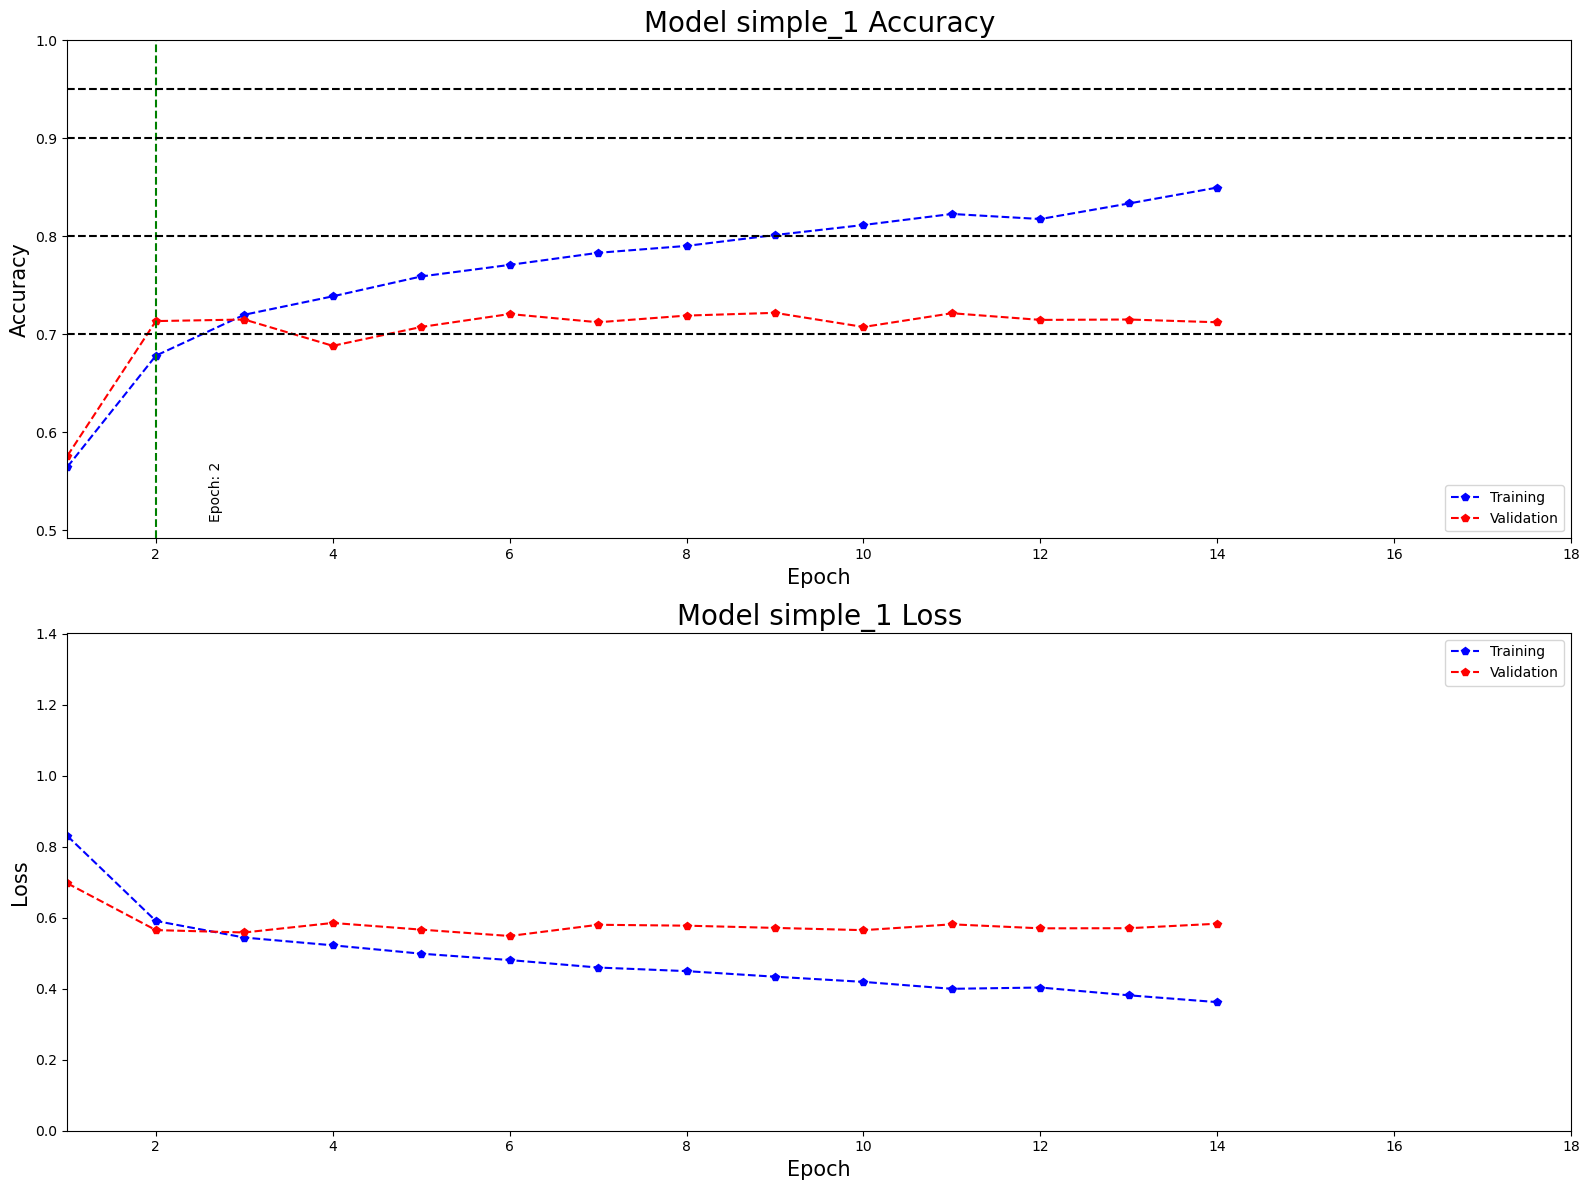

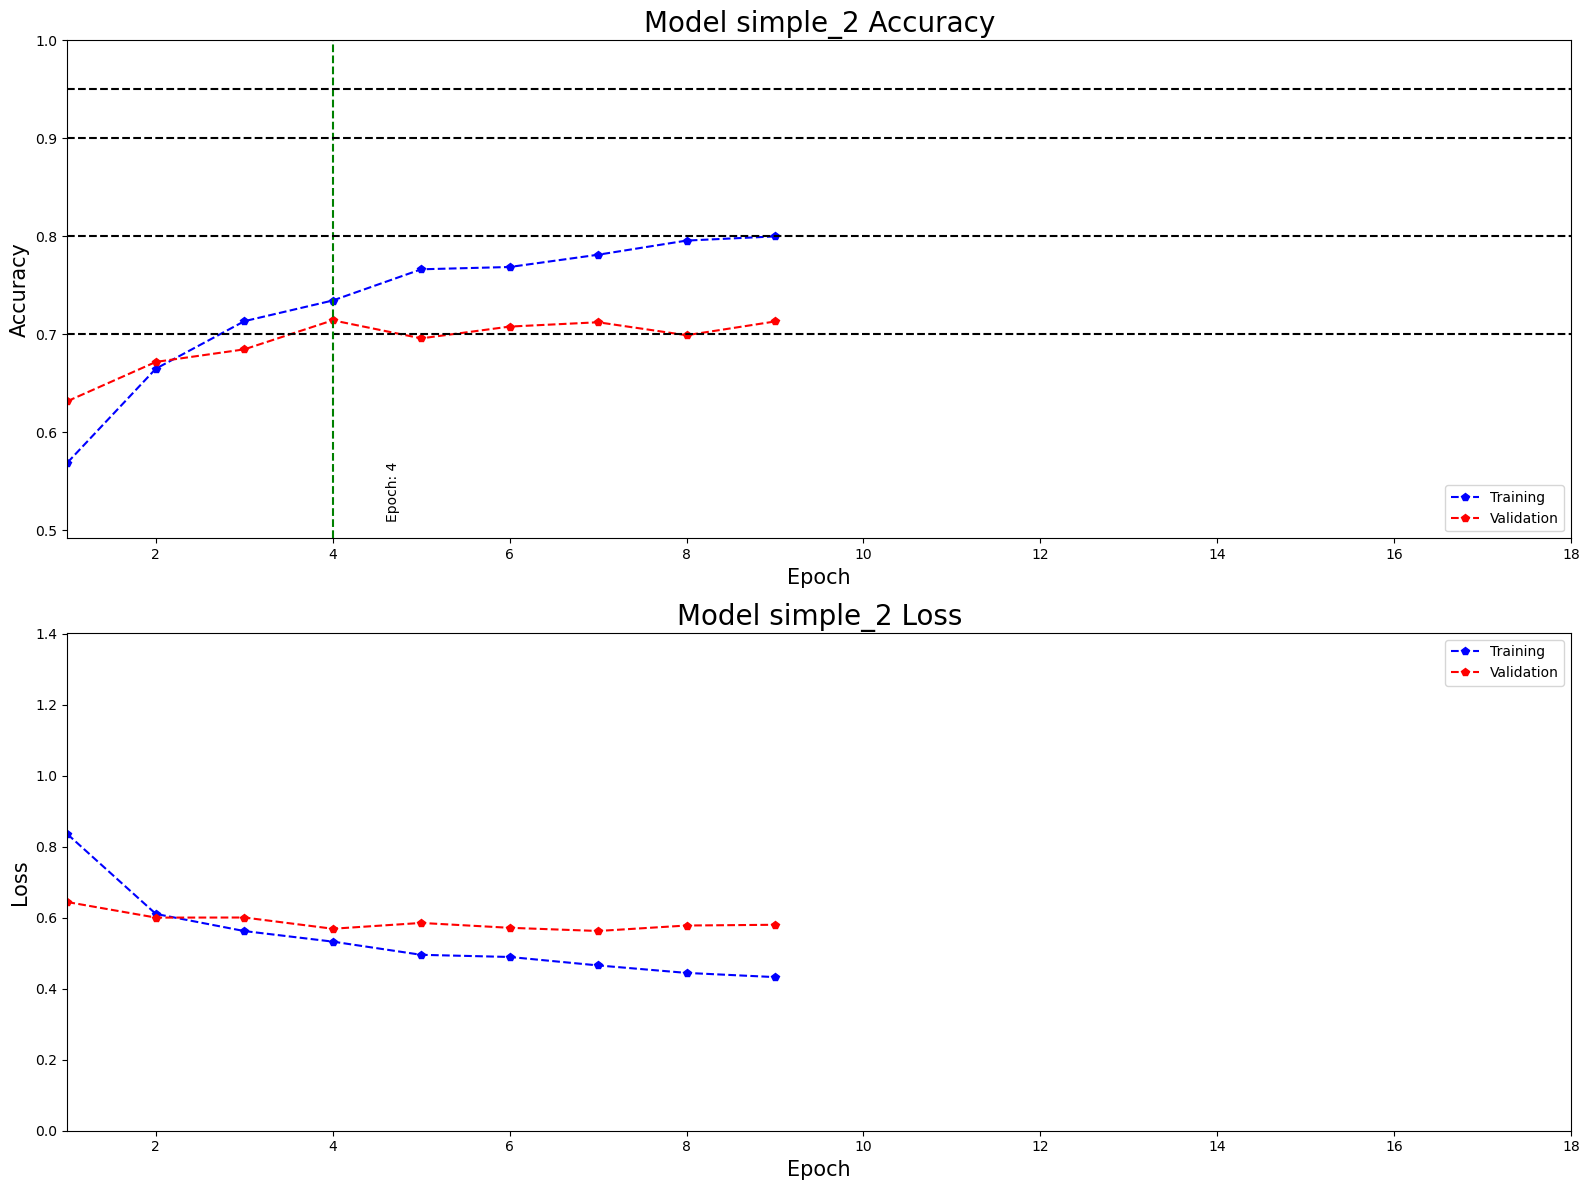

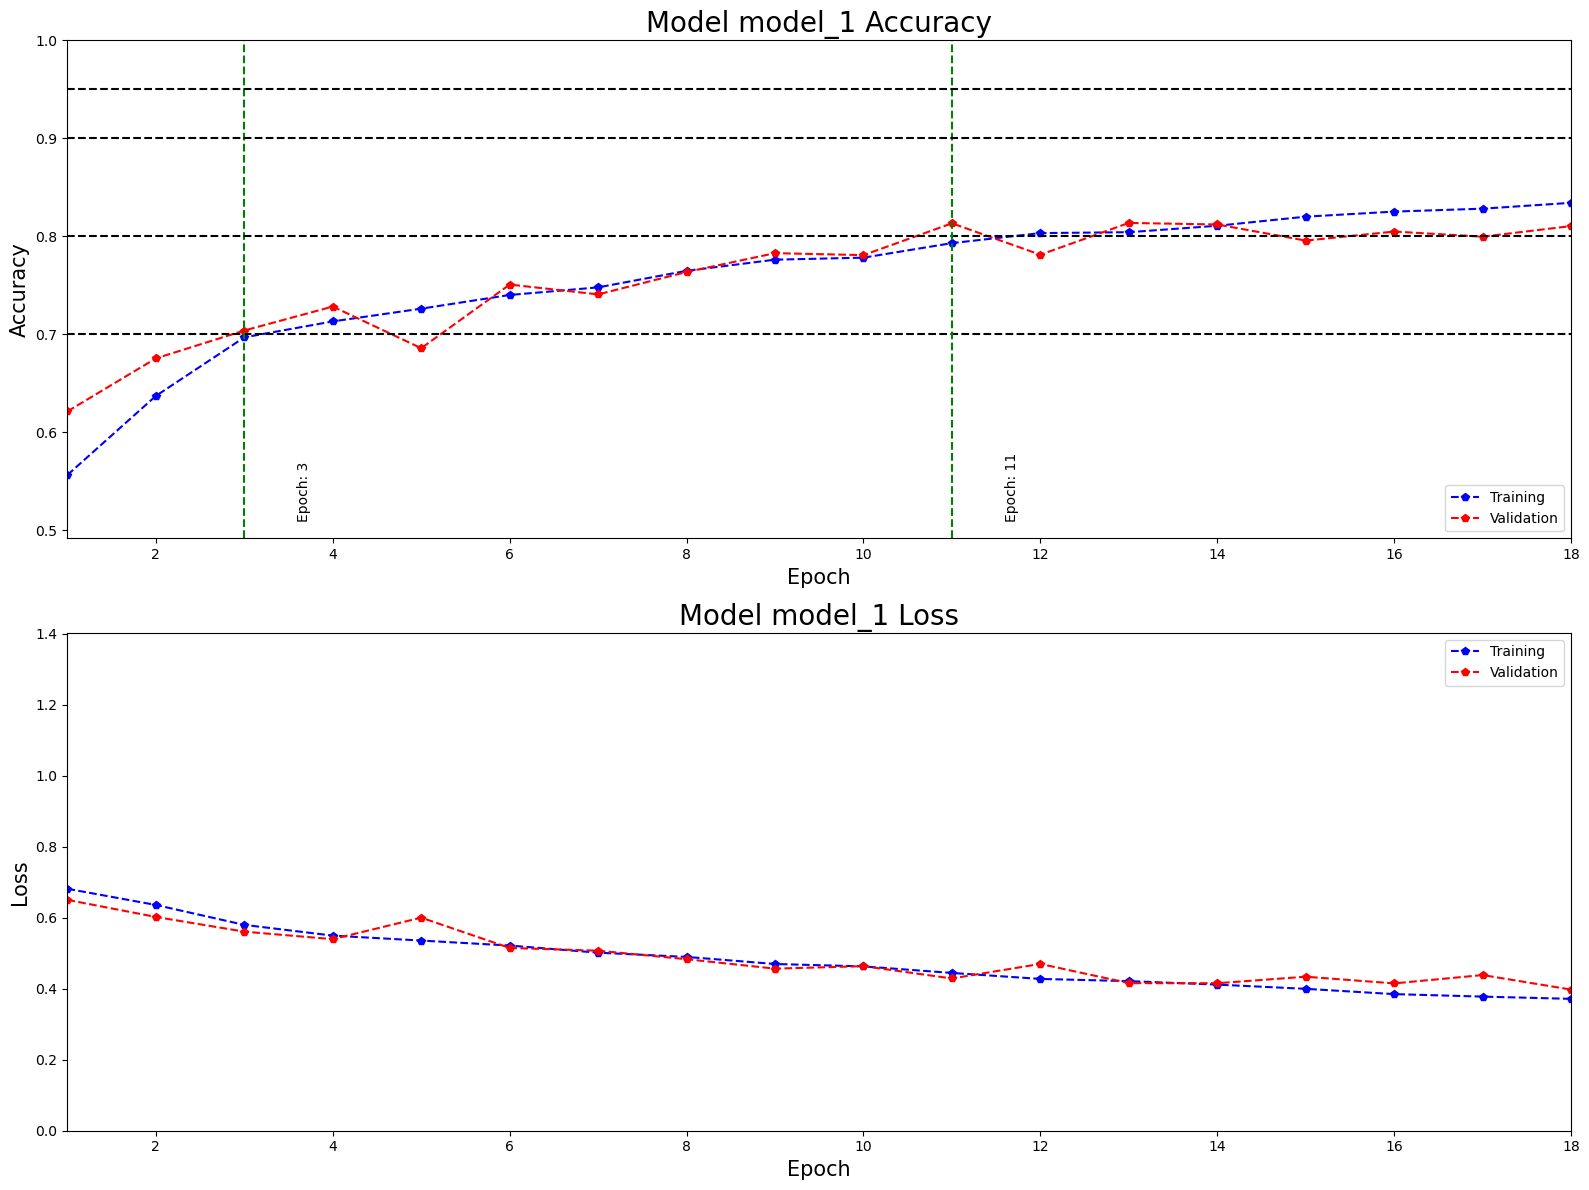

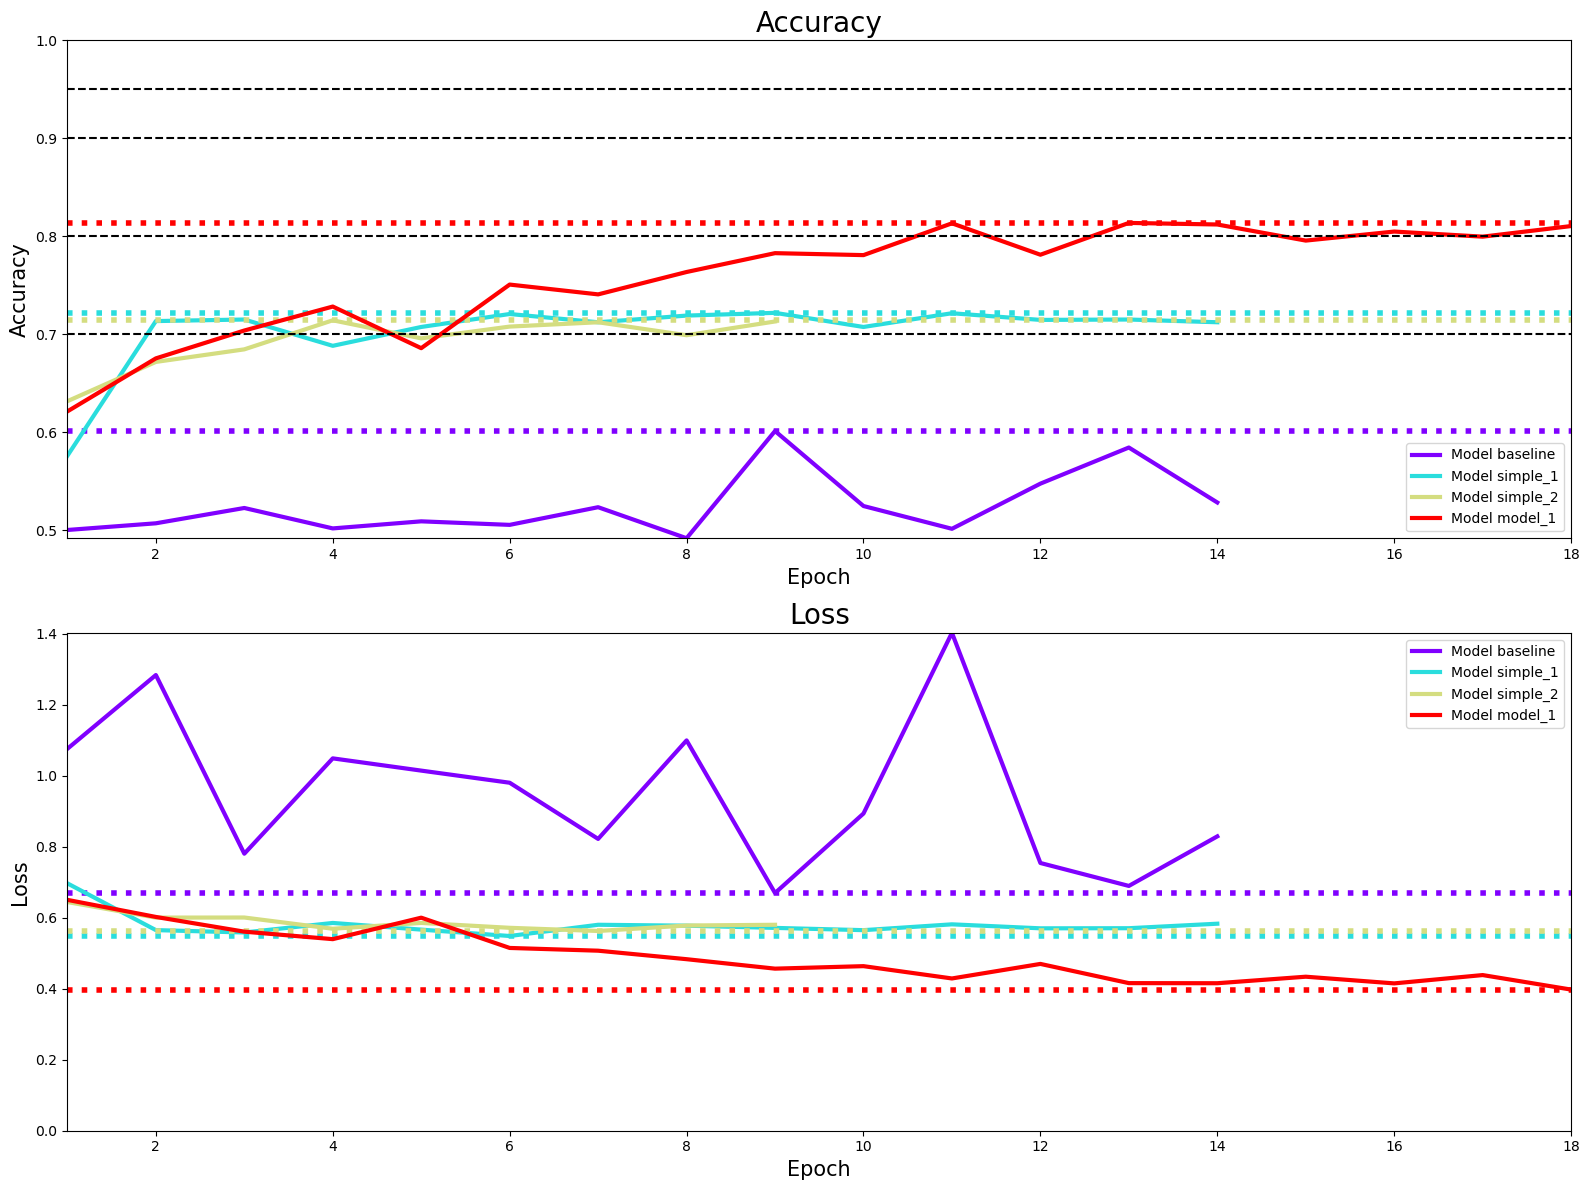

In [21]:
plot_history(models)

In [22]:
model_2 = Sequential()

# Block 1
model_2.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_2.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model_2.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Flatten())
model_2.add(Dropout(0.5))
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(units=1, activation='sigmoid'))
model_2.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])
model_2.summary()
models.append("model_2")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 conv2d_11 (Conv2D)          (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 conv2d_13 (Conv2D)          (None, 75, 75, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                  

In [23]:
history_model_2 = model_2.fit(train_generator,
                                steps_per_epoch=steps_per_epoch,
                                epochs=epochs,
                                validation_data=validation_generator,
                                validation_steps=validation_steps,
                                callbacks=[es])

history_model_2_df = pd.DataFrame(history_model_2.history)
history_model_2_csv_file = 'history/history_model_2.csv'

with open(history_model_2_csv_file, mode='w') as f:
    history_model_2_df.to_csv(f)

Epoch 1/1000
110/136 [=======================>......] - ETA: 2s - loss: 0.6905 - accuracy: 0.5264

c:\Users\Urban\.conda\envs\kodilla-edu\lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


136/136 [==============================] - 16s 112ms/step - loss: 0.6880 - accuracy: 0.5353 - val_loss: 0.6667 - val_accuracy: 0.5725
Epoch 2/1000
136/136 [==============================] - 15s 110ms/step - loss: 0.6567 - accuracy: 0.6043 - val_loss: 0.6510 - val_accuracy: 0.6114
Epoch 3/1000
136/136 [==============================] - 15s 109ms/step - loss: 0.5979 - accuracy: 0.6718 - val_loss: 0.5554 - val_accuracy: 0.7240
Epoch 4/1000
136/136 [==============================] - 15s 109ms/step - loss: 0.5675 - accuracy: 0.7016 - val_loss: 0.5473 - val_accuracy: 0.7151
Epoch 5/1000
136/136 [==============================] - 15s 110ms/step - loss: 0.5495 - accuracy: 0.7143 - val_loss: 0.5451 - val_accuracy: 0.7300
Epoch 6/1000
136/136 [==============================] - 15s 109ms/step - loss: 0.5328 - accuracy: 0.7242 - val_loss: 0.5111 - val_accuracy: 0.7448
Epoch 7/1000
136/136 [==============================] - 15s 110ms/step - loss: 0.5179 - accuracy: 0.7463 - val_loss: 0.5337 - val_a

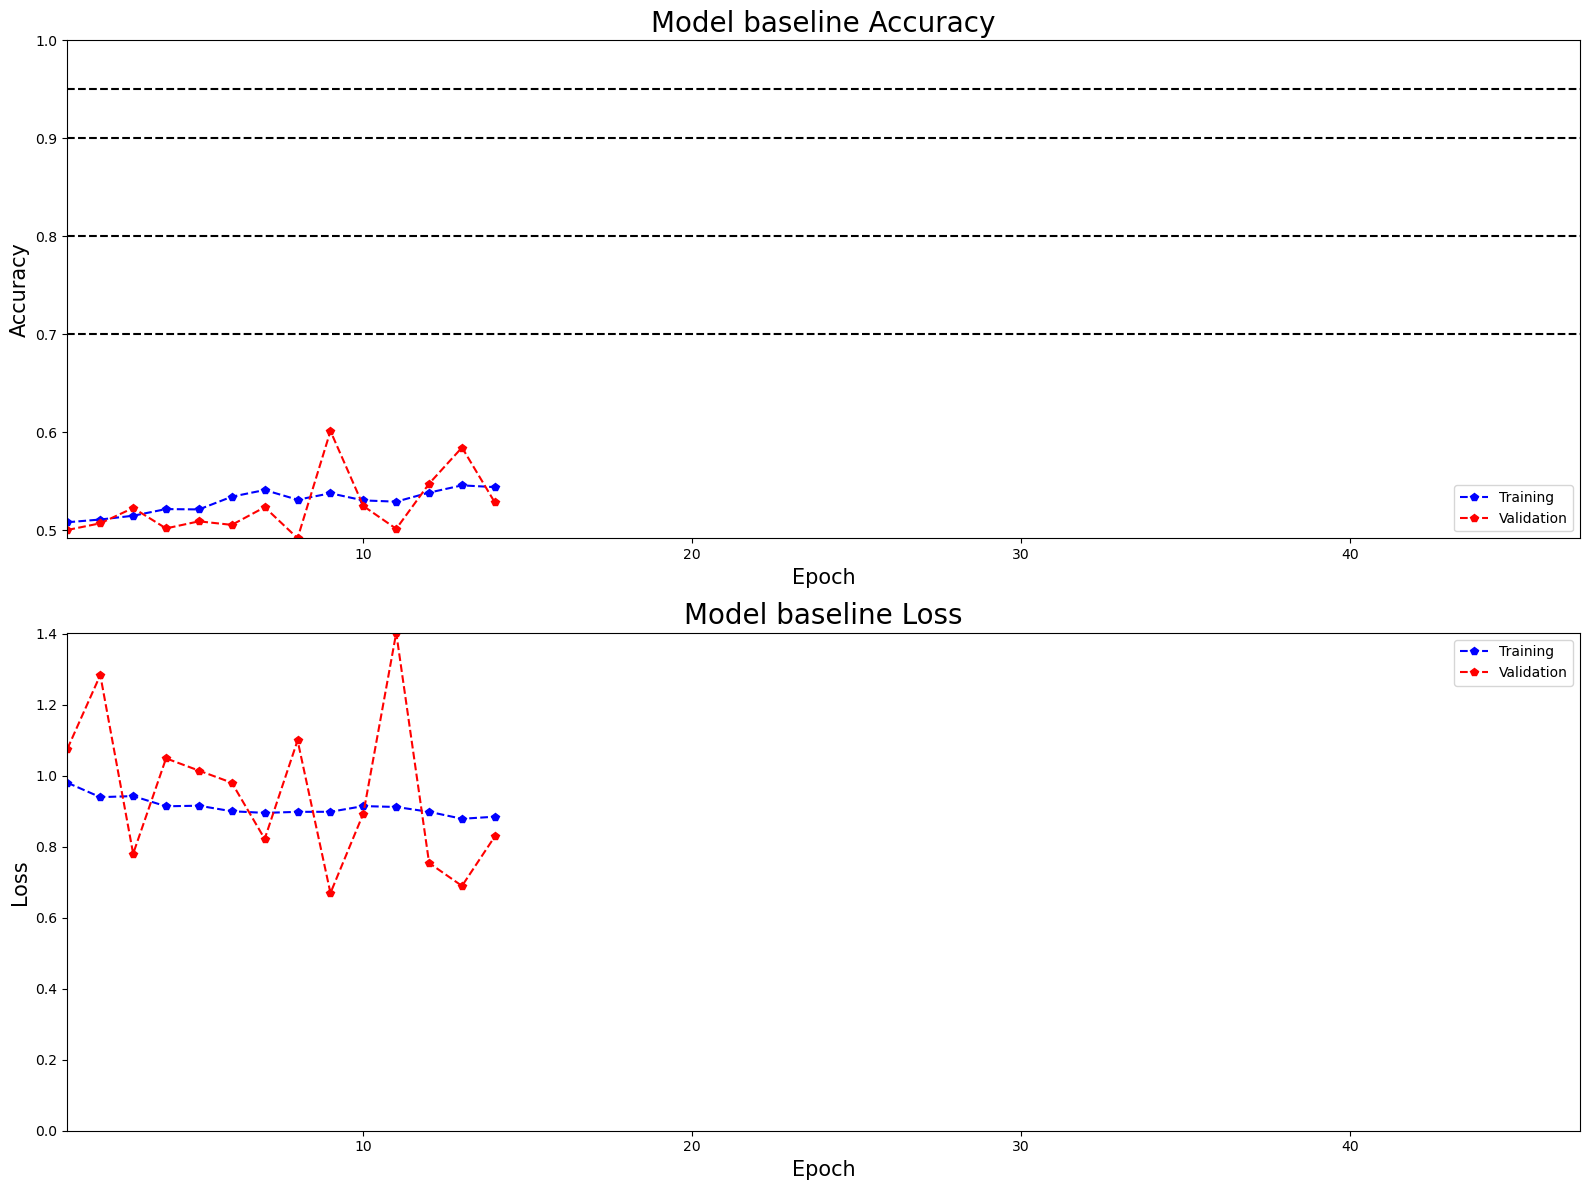

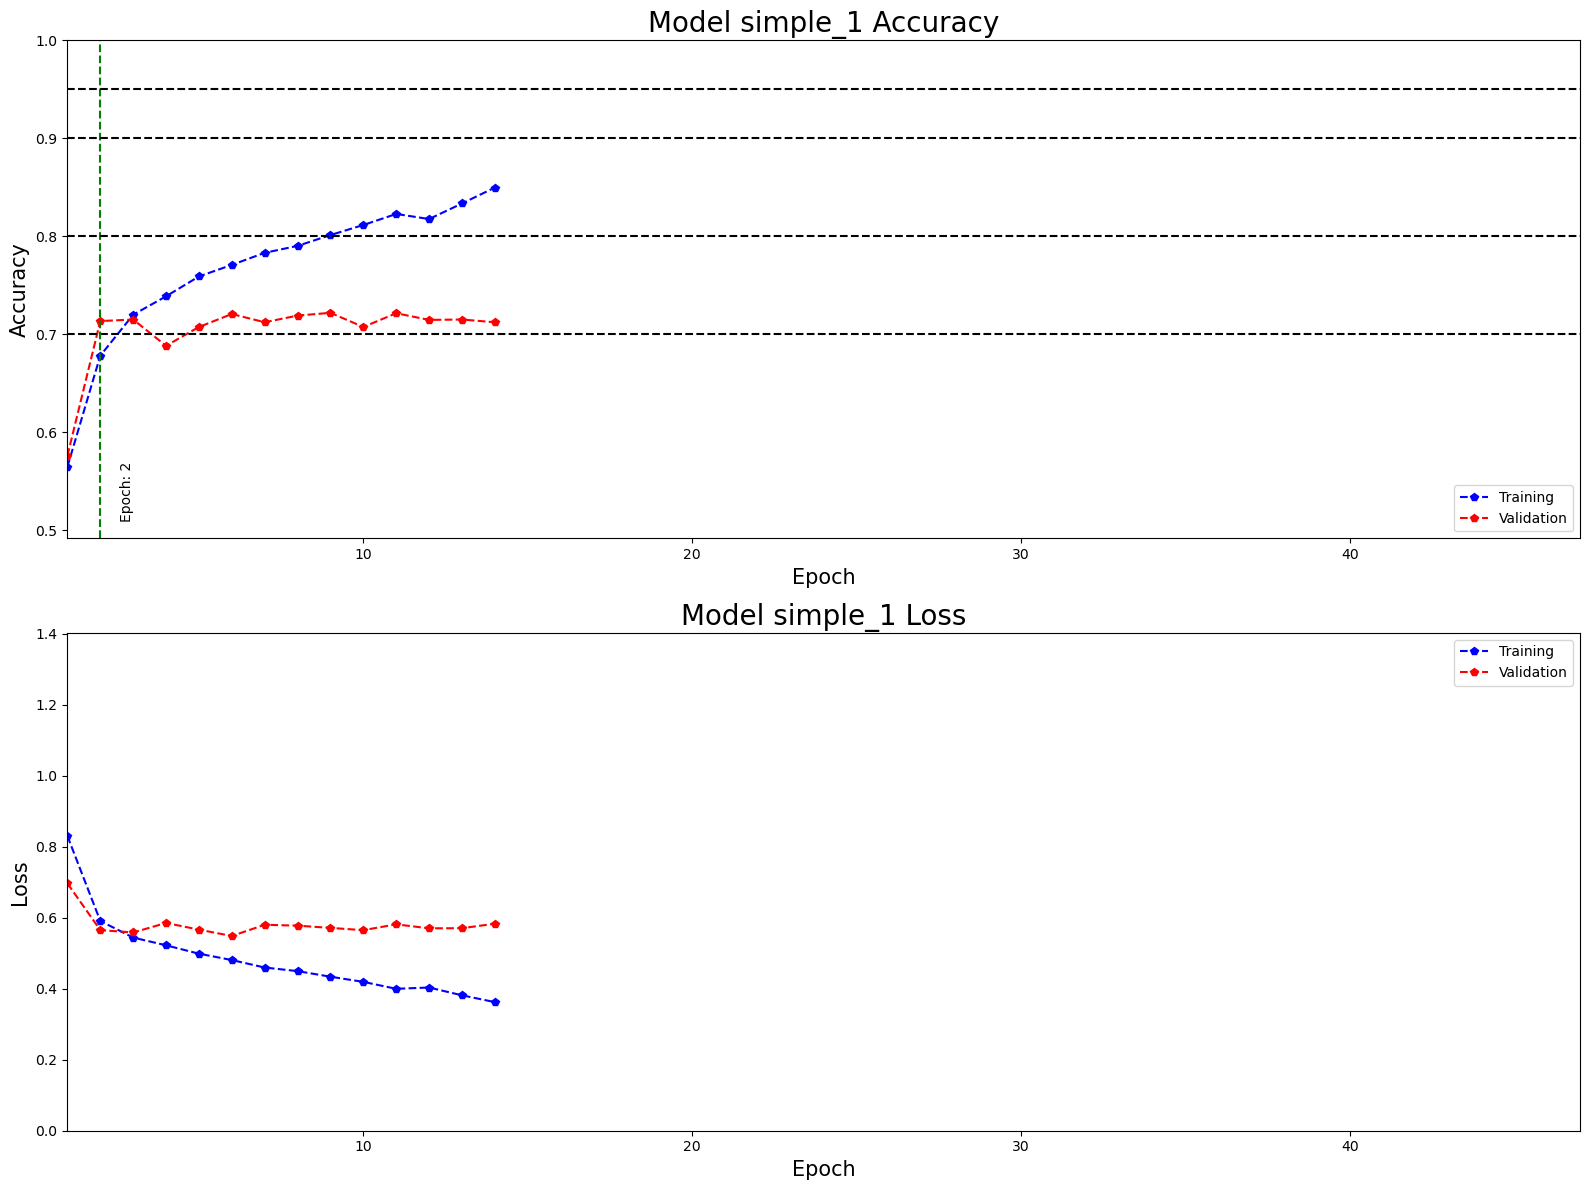

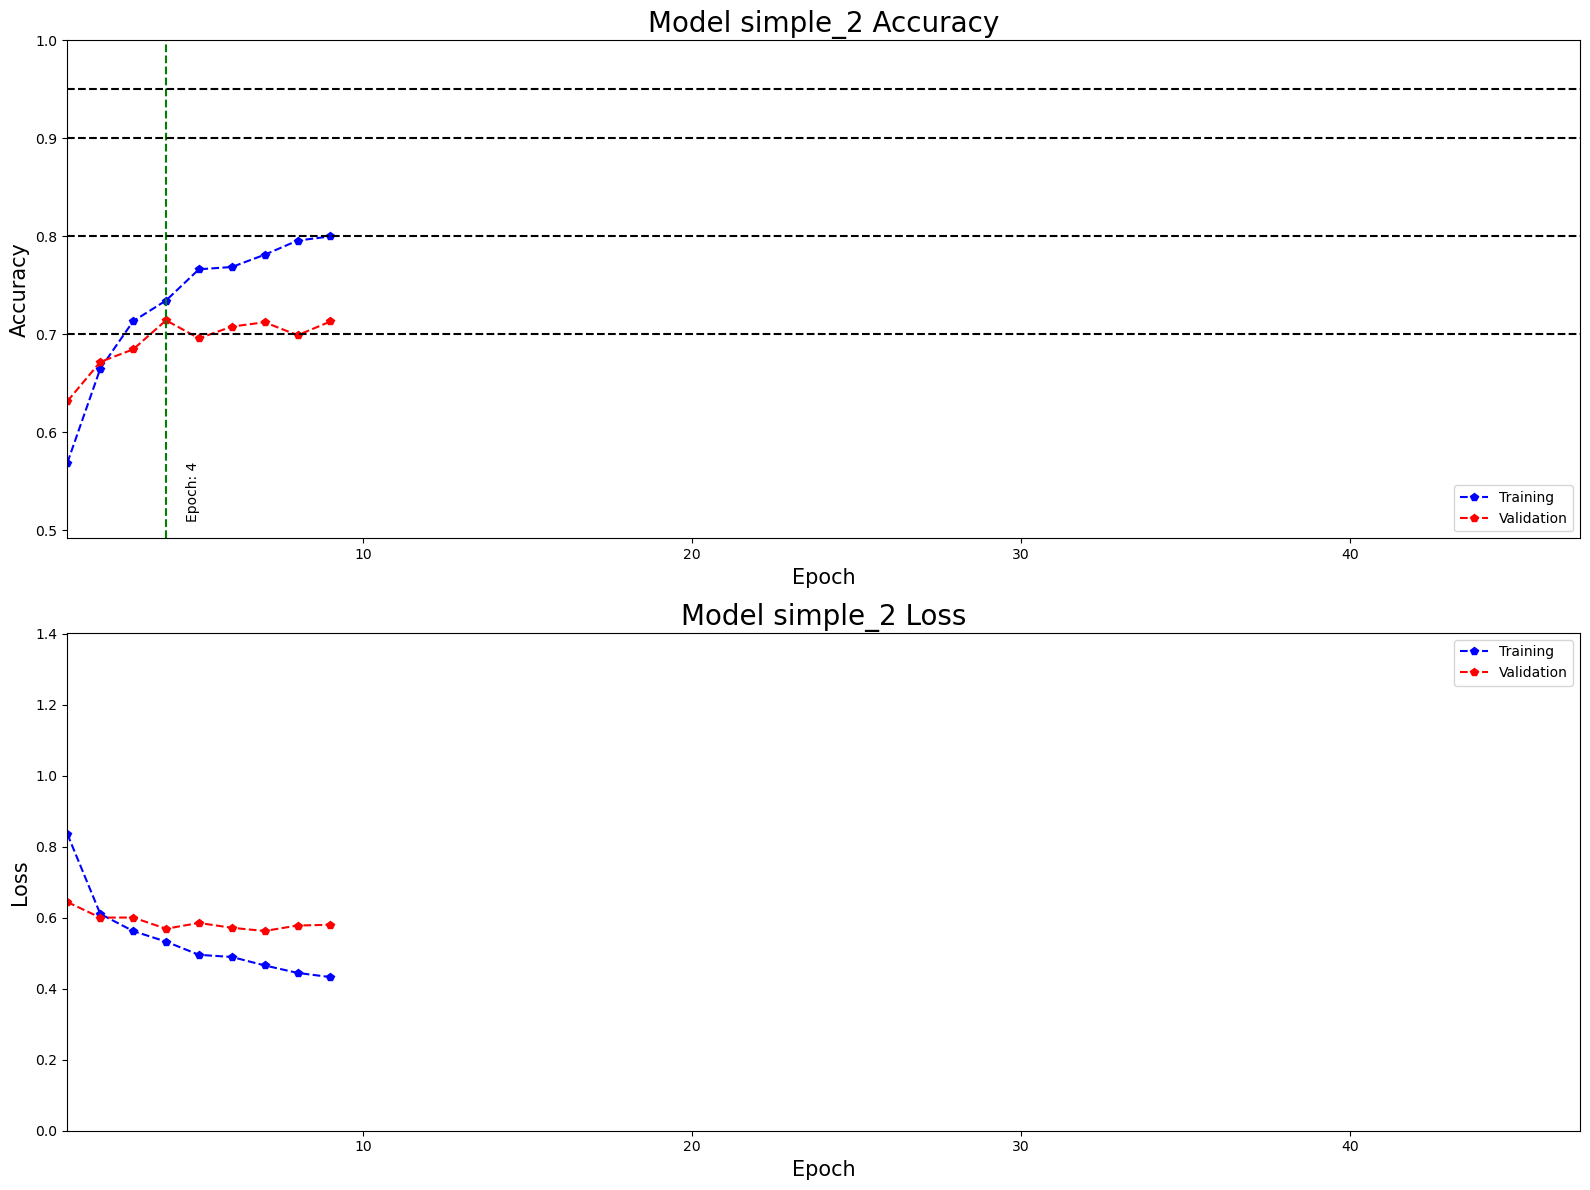

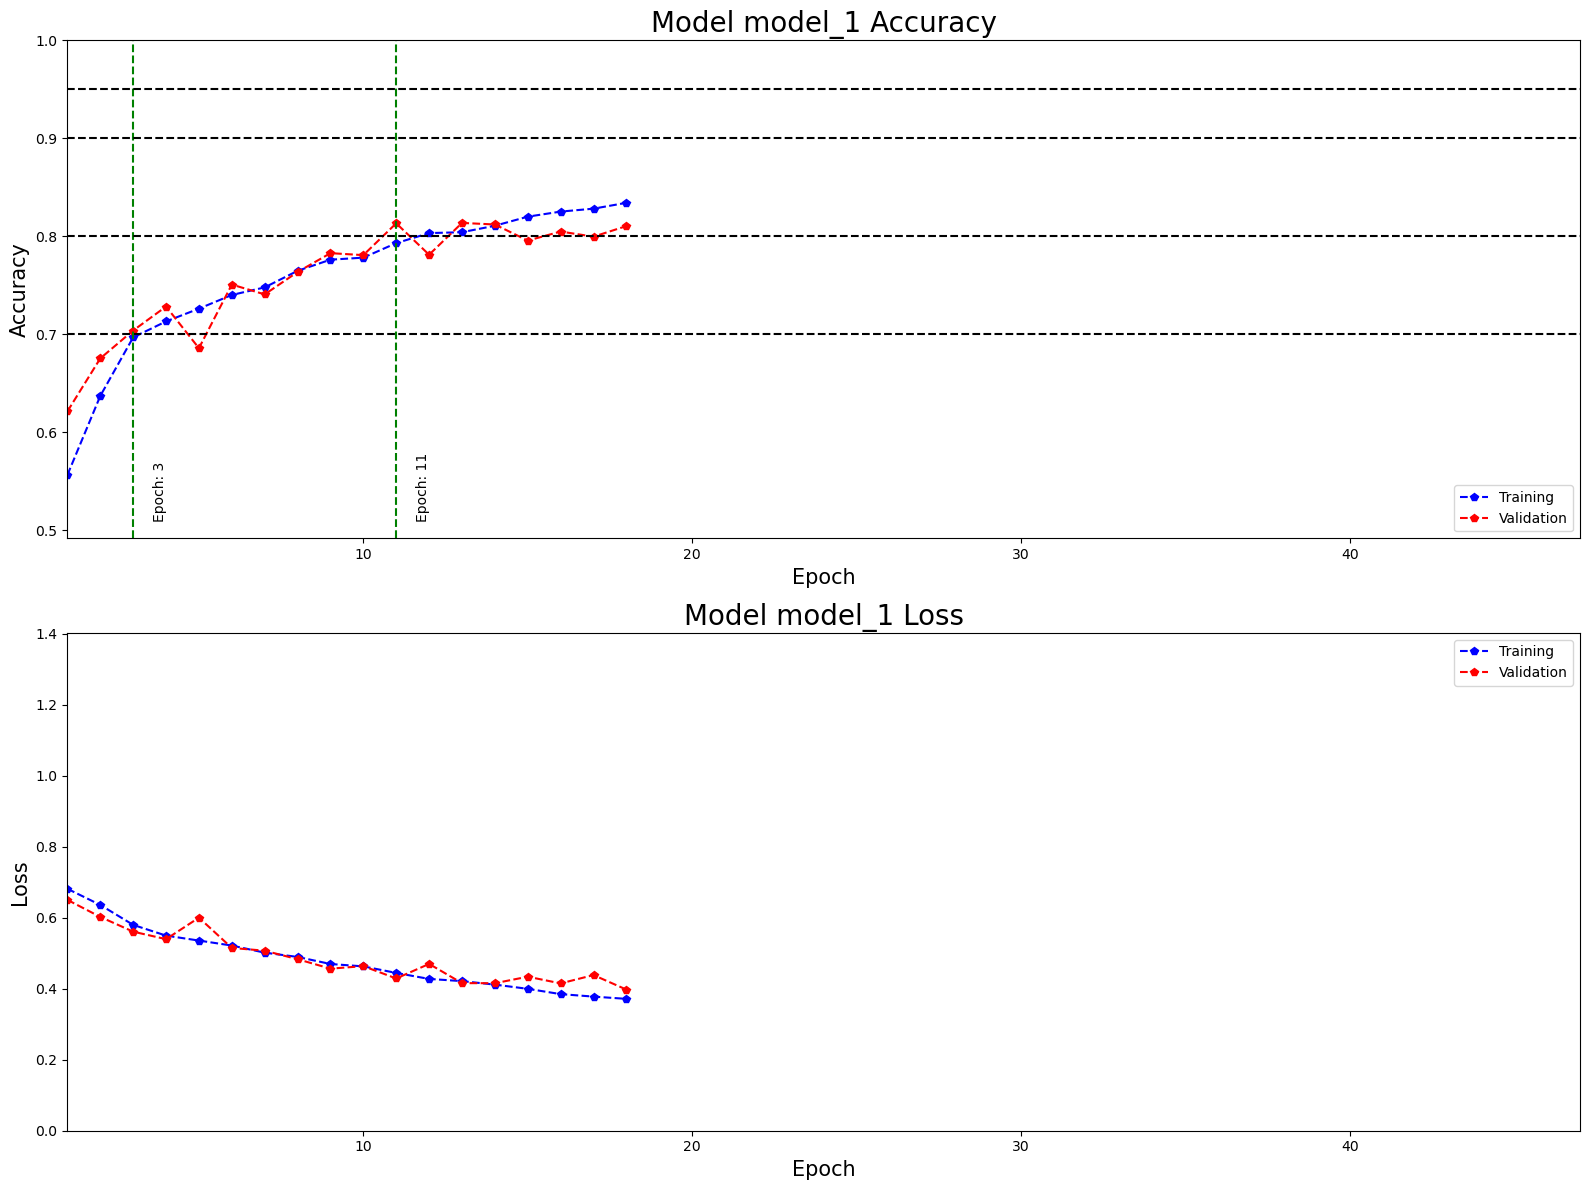

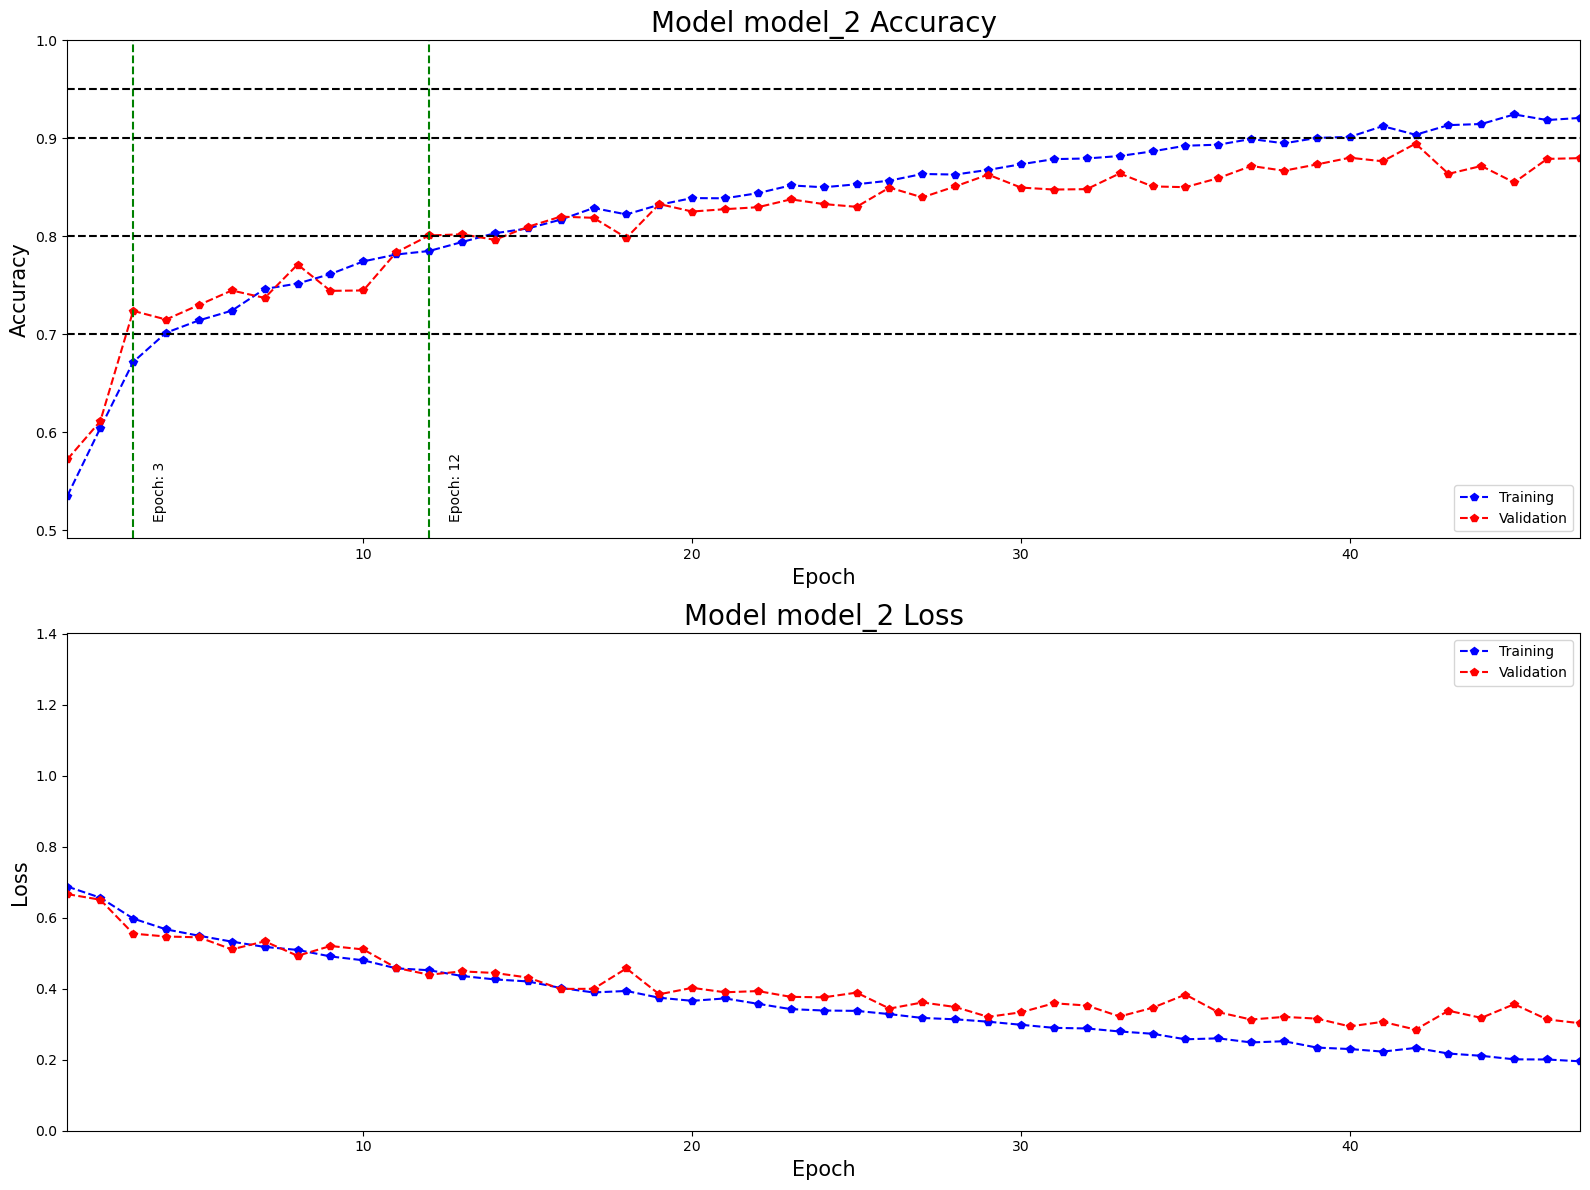

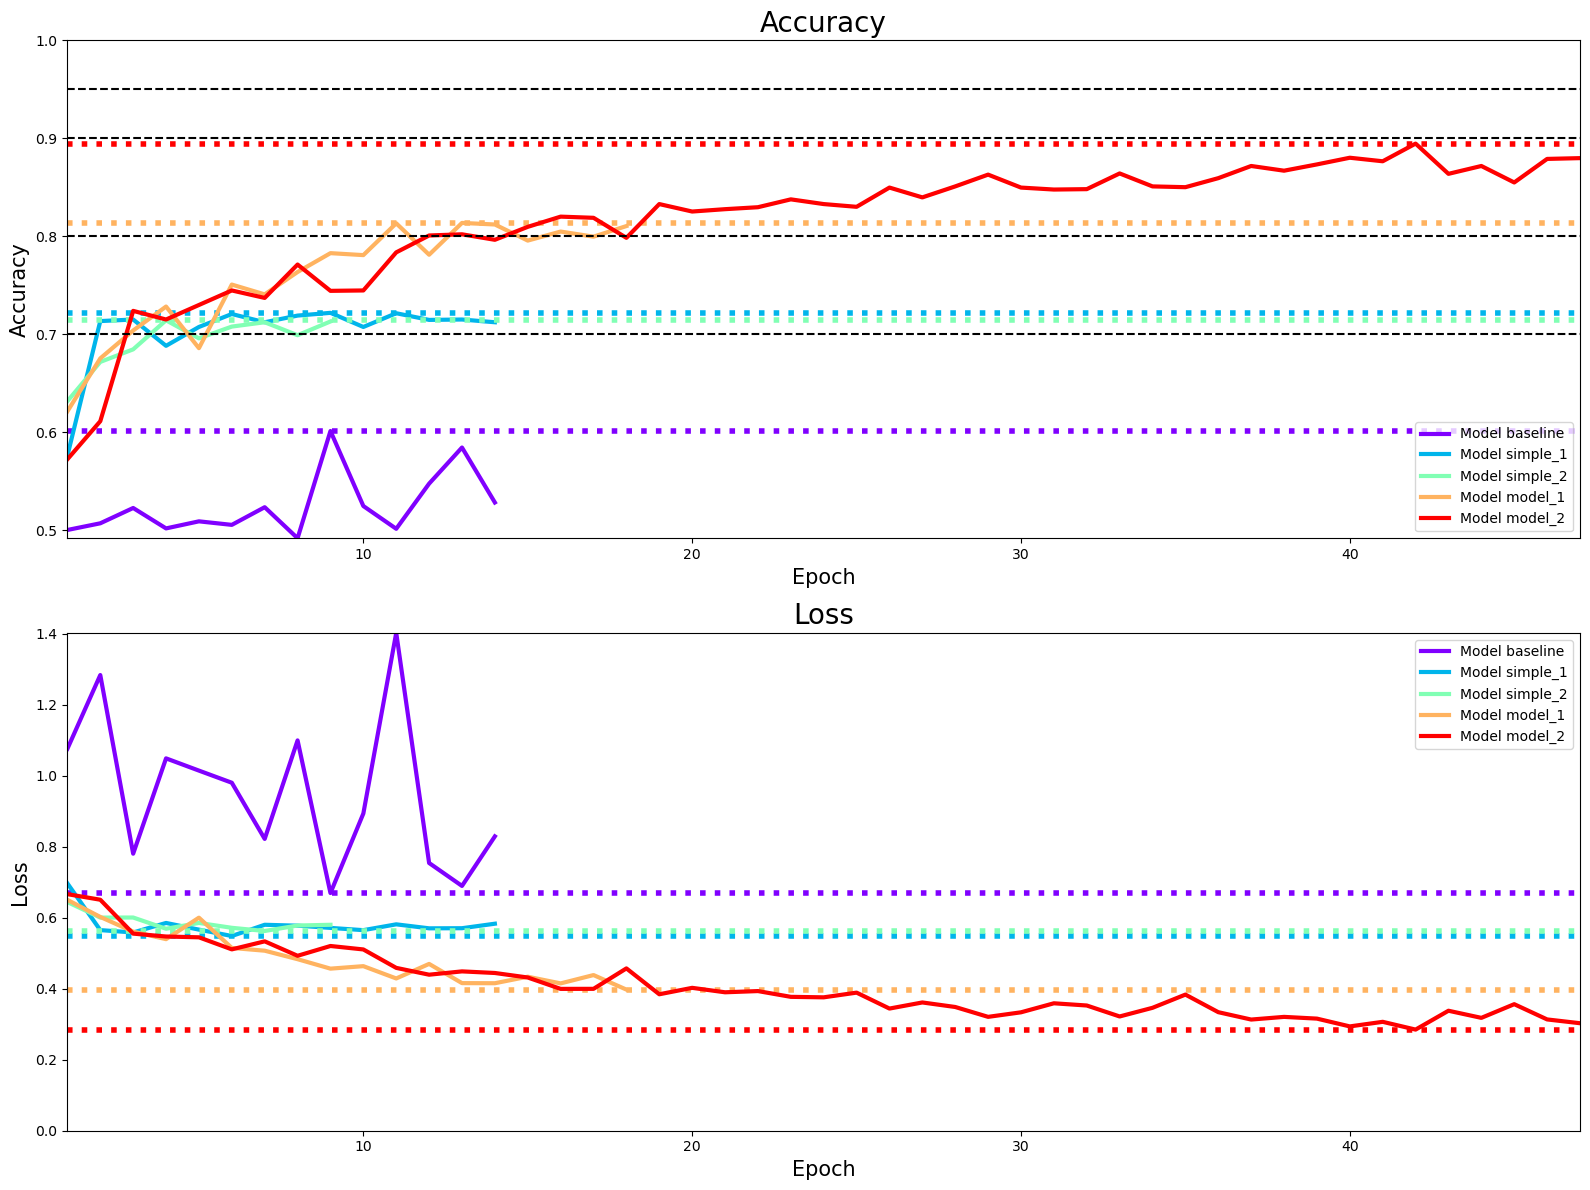

In [24]:
plot_history(models)

In [25]:
model_3 = Sequential()

# Block 1
model_3.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_3.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model_3.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Flatten())
model_3.add(Dropout(0.5))
model_3.add(Dense(256, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(128, activation='relu'))
model_3.add(Dense(units=1, activation='sigmoid'))
model_3.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])
model_3.summary()
models.append("model_3")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 conv2d_19 (Conv2D)          (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 75, 75, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 conv2d_21 (Conv2D)          (None, 75, 75, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                 

In [26]:
history_model_3 = model_3.fit(train_generator_augmentation,
                                steps_per_epoch=steps_per_epoch,
                                epochs=epochs,
                                validation_data=validation_generator,
                                validation_steps=validation_steps,
                                callbacks=[es])

history_model_3_df = pd.DataFrame(history_model_3.history)
history_model_3_csv_file = 'history/history_model_3.csv'
with open(history_model_3_csv_file, mode='w') as f:
    history_model_3_df.to_csv(f)

Epoch 1/1000
136/136 [==============================] - 35s 254ms/step - loss: 0.6843 - accuracy: 0.5375 - val_loss: 0.6613 - val_accuracy: 0.5849
Epoch 2/1000
136/136 [==============================] - 35s 255ms/step - loss: 0.6582 - accuracy: 0.5989 - val_loss: 0.6389 - val_accuracy: 0.6246
Epoch 3/1000
136/136 [==============================] - 34s 253ms/step - loss: 0.6444 - accuracy: 0.6179 - val_loss: 0.6203 - val_accuracy: 0.6530
Epoch 4/1000
 36/136 [======>.......................] - ETA: 23s - loss: 0.6375 - accuracy: 0.6272

c:\Users\Urban\.conda\envs\kodilla-edu\lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


136/136 [==============================] - 35s 256ms/step - loss: 0.6370 - accuracy: 0.6230 - val_loss: 0.6182 - val_accuracy: 0.6526
Epoch 5/1000
136/136 [==============================] - 34s 253ms/step - loss: 0.6220 - accuracy: 0.6417 - val_loss: 0.5784 - val_accuracy: 0.6967
Epoch 6/1000
136/136 [==============================] - 35s 256ms/step - loss: 0.5937 - accuracy: 0.6805 - val_loss: 0.5743 - val_accuracy: 0.6899
Epoch 7/1000
136/136 [==============================] - 34s 253ms/step - loss: 0.5772 - accuracy: 0.6974 - val_loss: 0.6119 - val_accuracy: 0.6558
Epoch 8/1000
136/136 [==============================] - 35s 256ms/step - loss: 0.5662 - accuracy: 0.7014 - val_loss: 0.5551 - val_accuracy: 0.7212
Epoch 9/1000
136/136 [==============================] - 35s 254ms/step - loss: 0.5517 - accuracy: 0.7144 - val_loss: 0.5592 - val_accuracy: 0.7264
Epoch 10/1000
136/136 [==============================] - 35s 254ms/step - loss: 0.5474 - accuracy: 0.7205 - val_loss: 0.5183 - val_

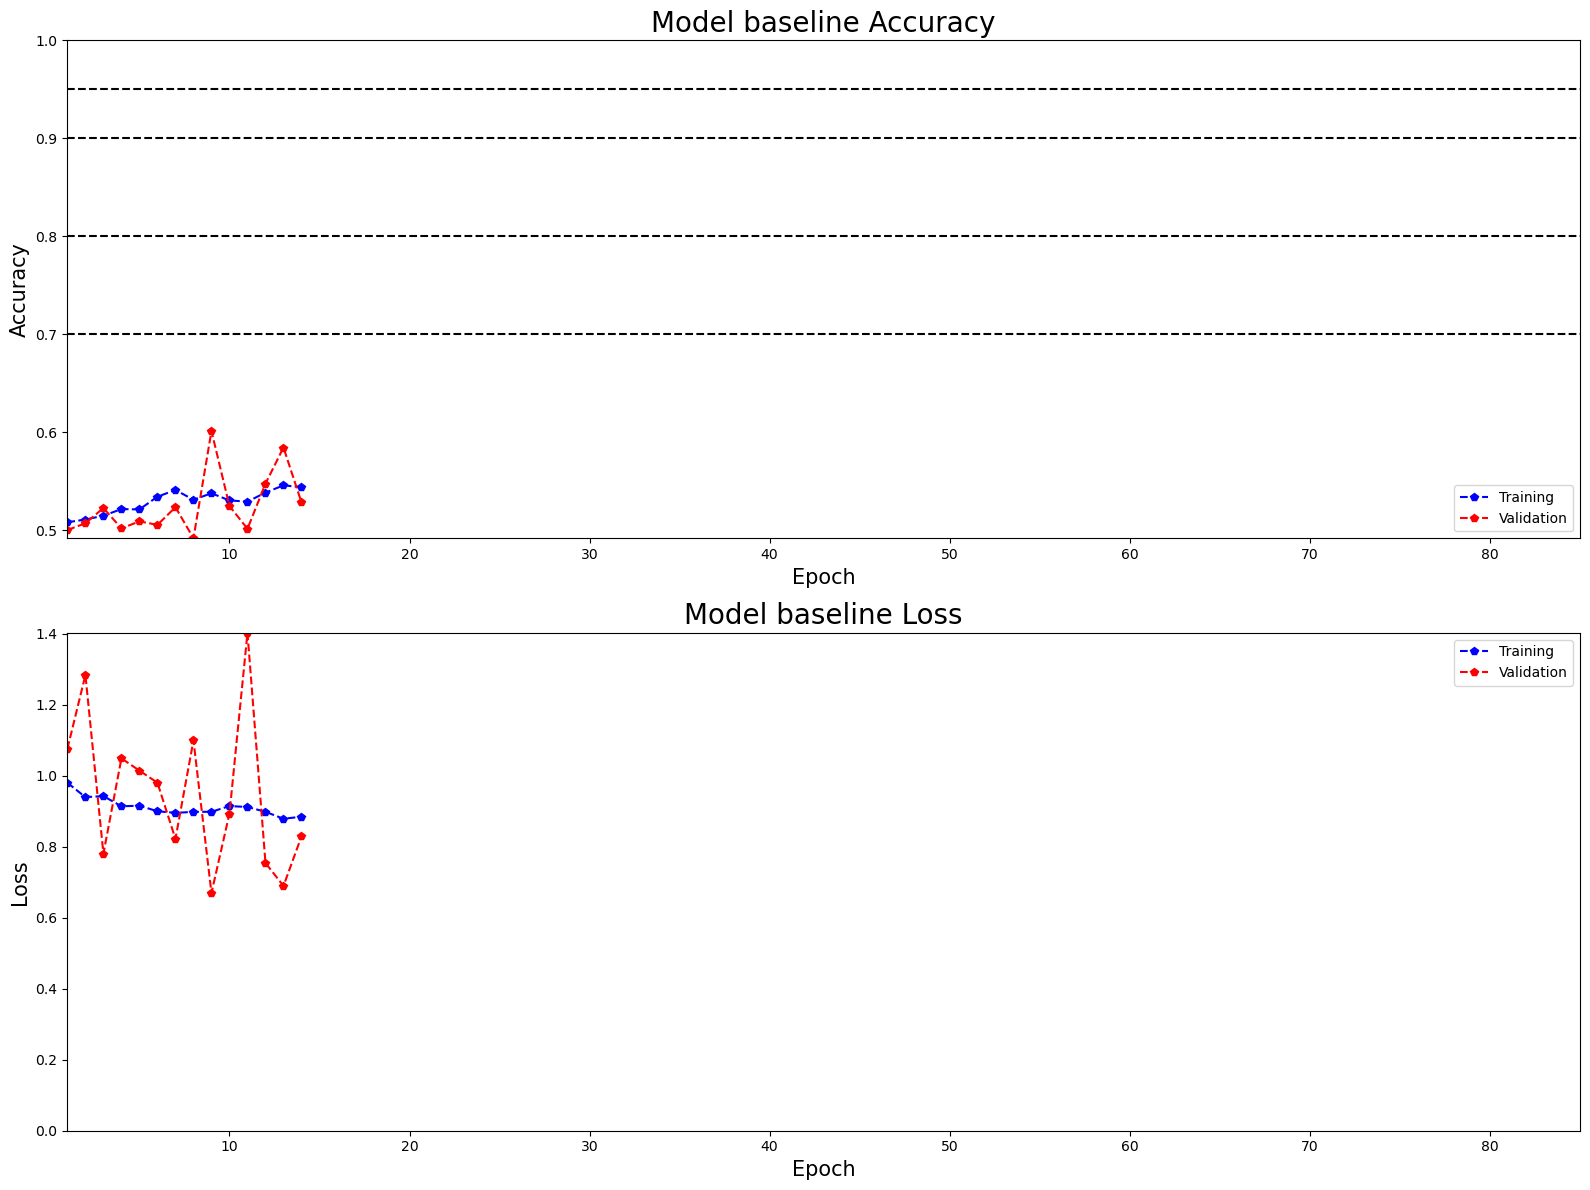

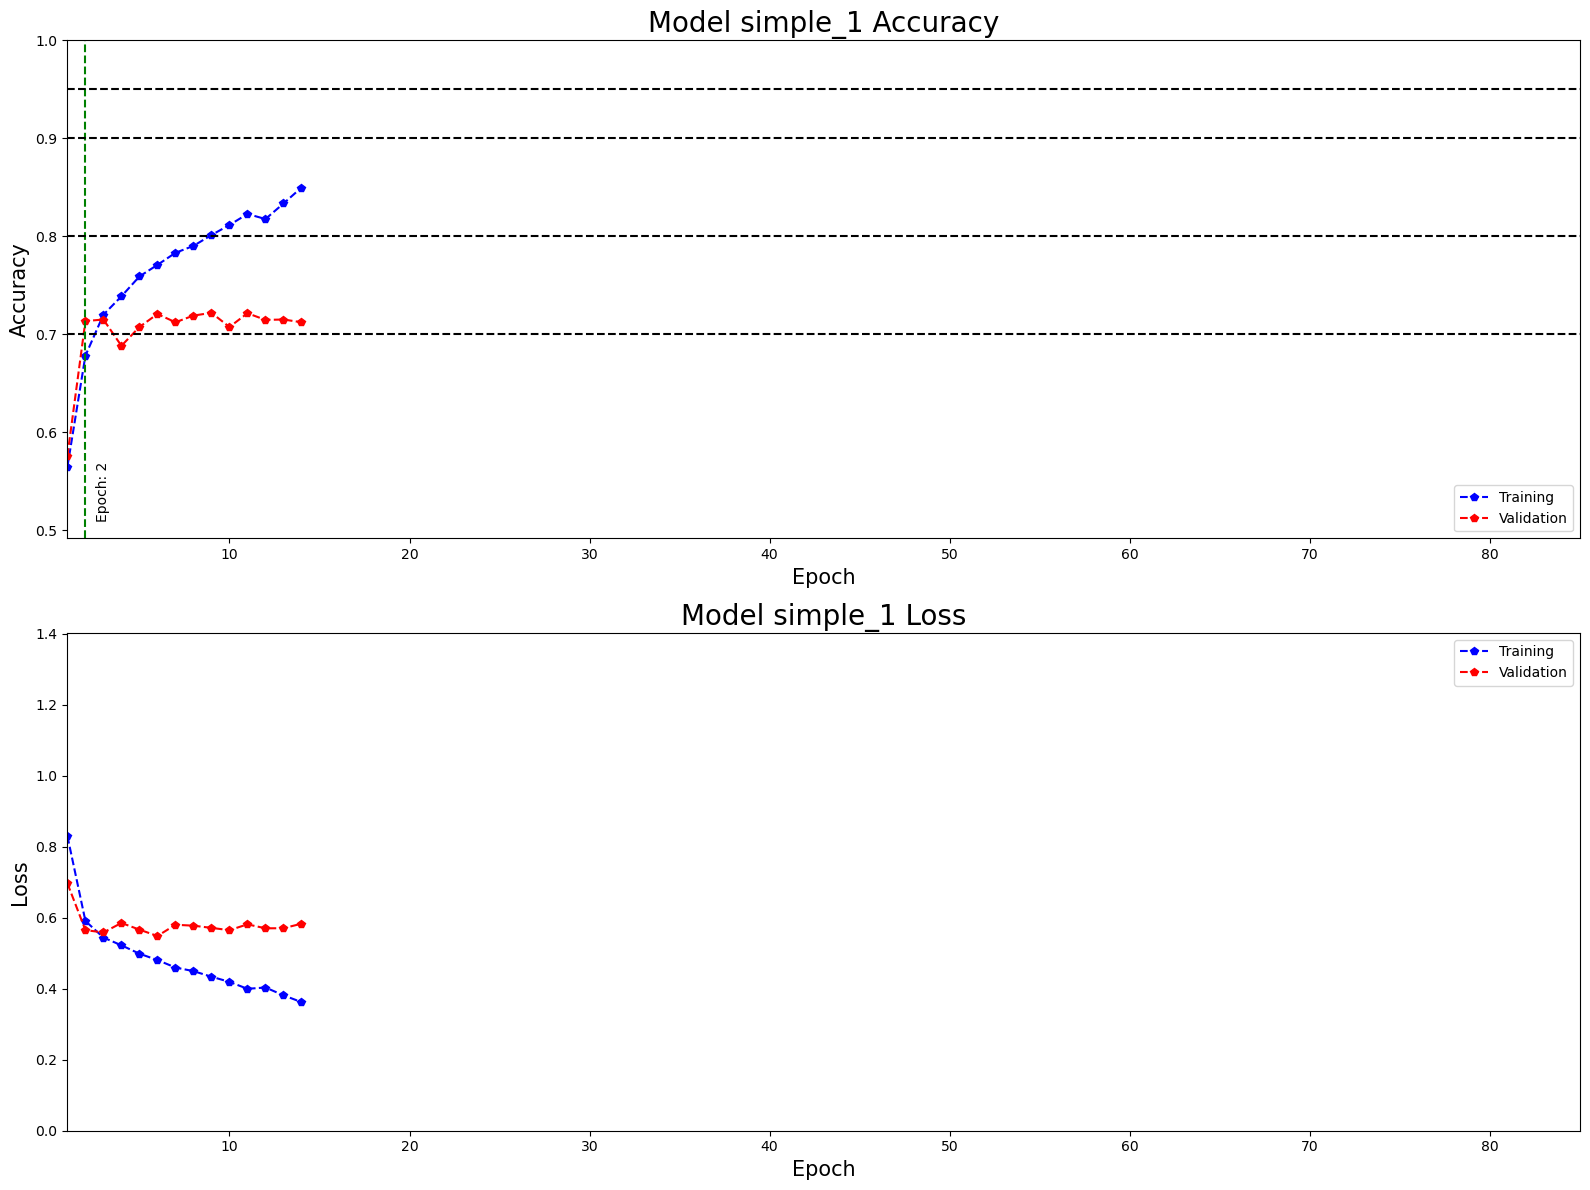

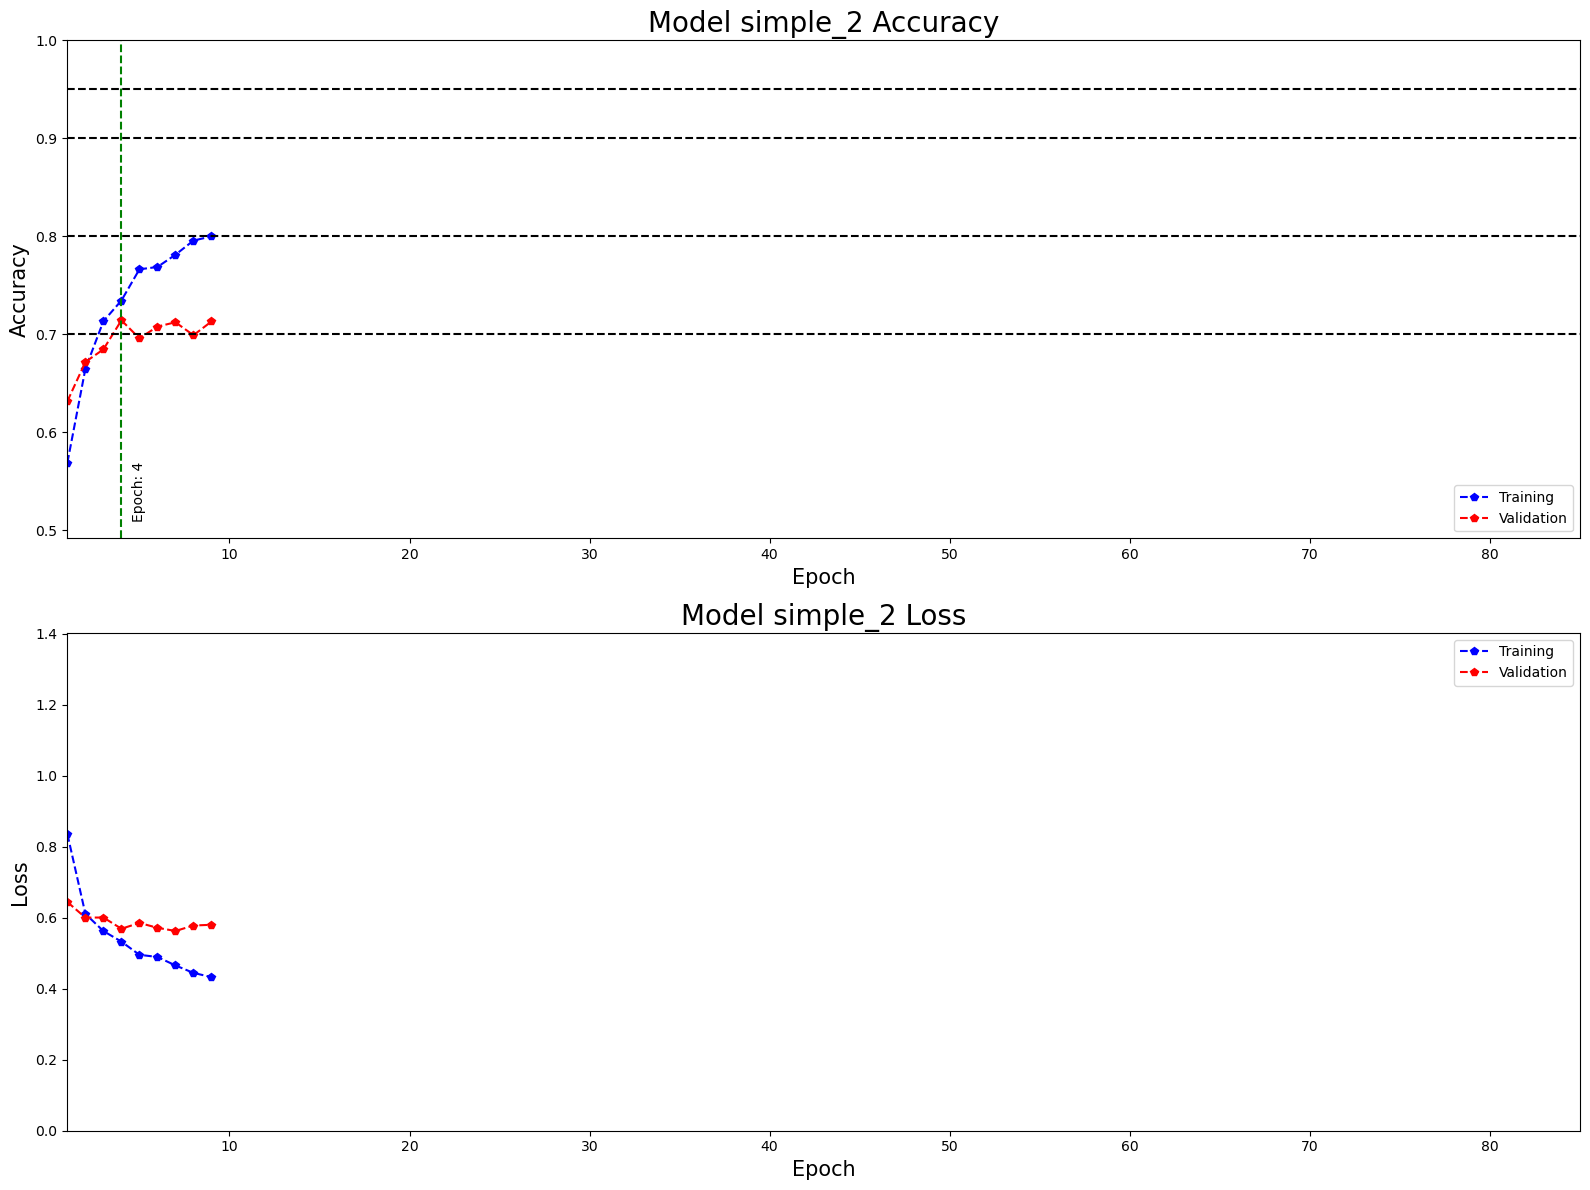

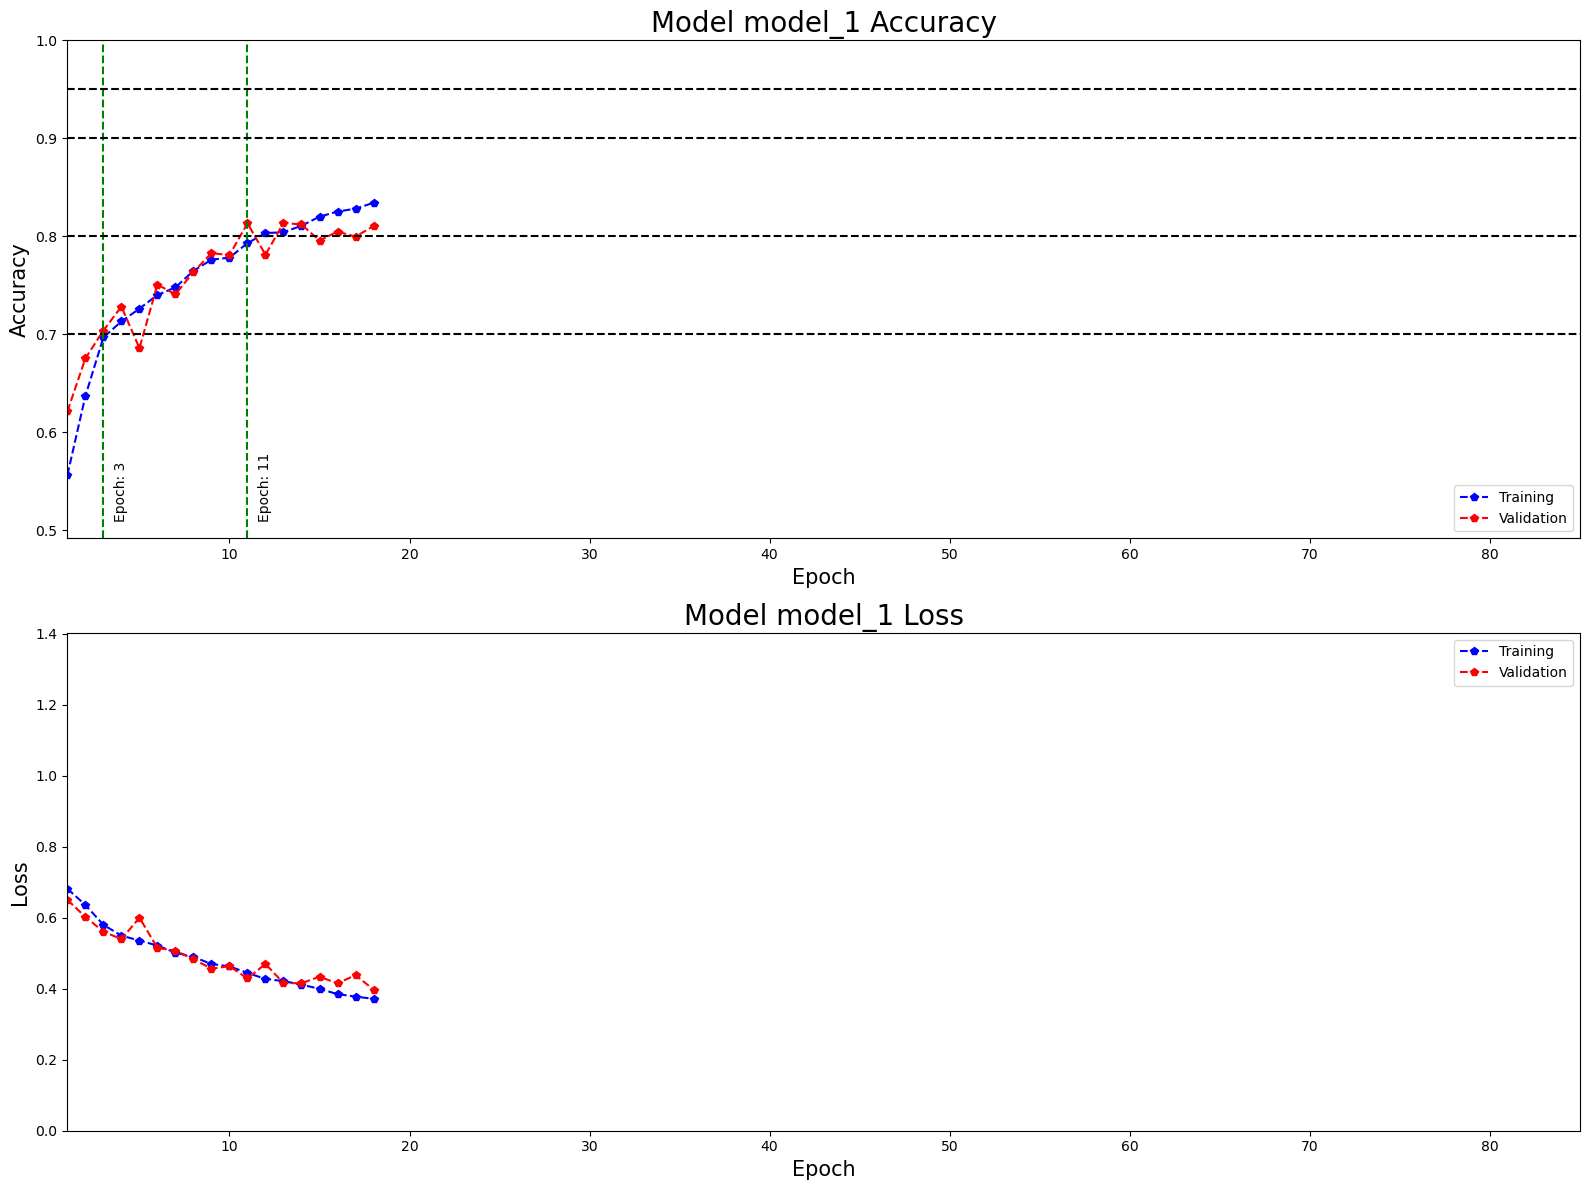

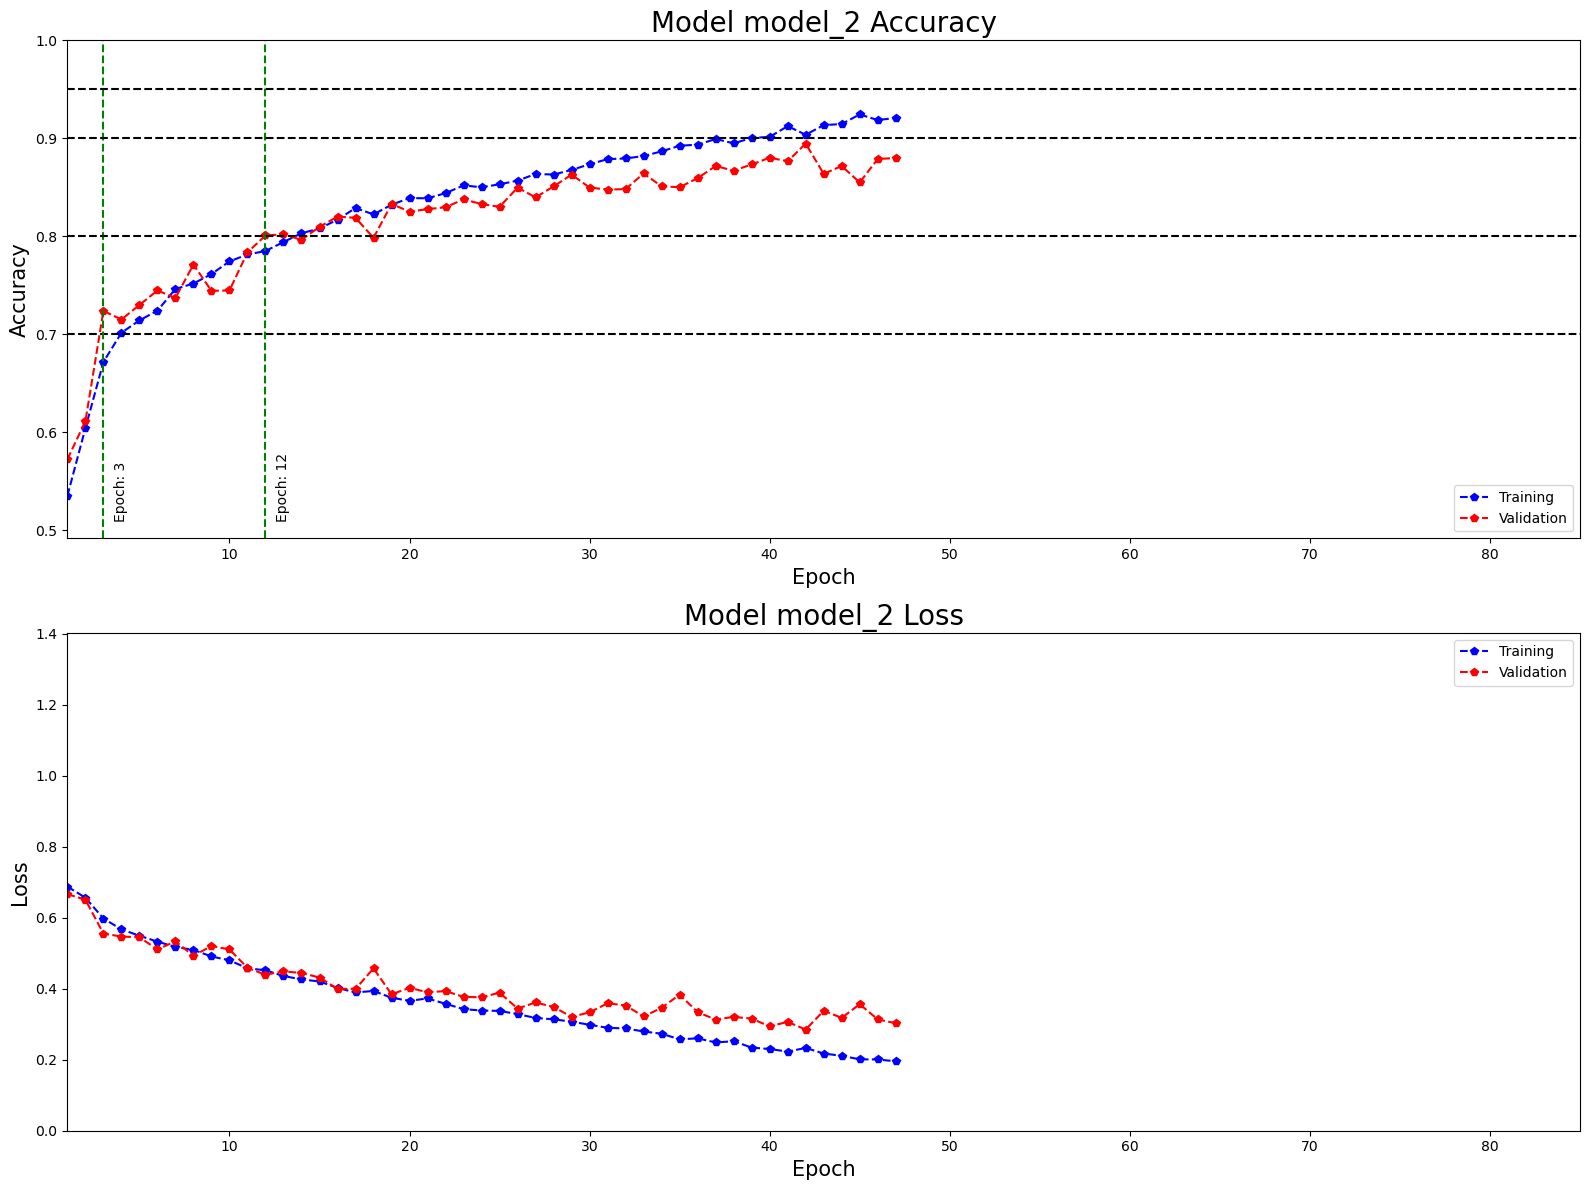

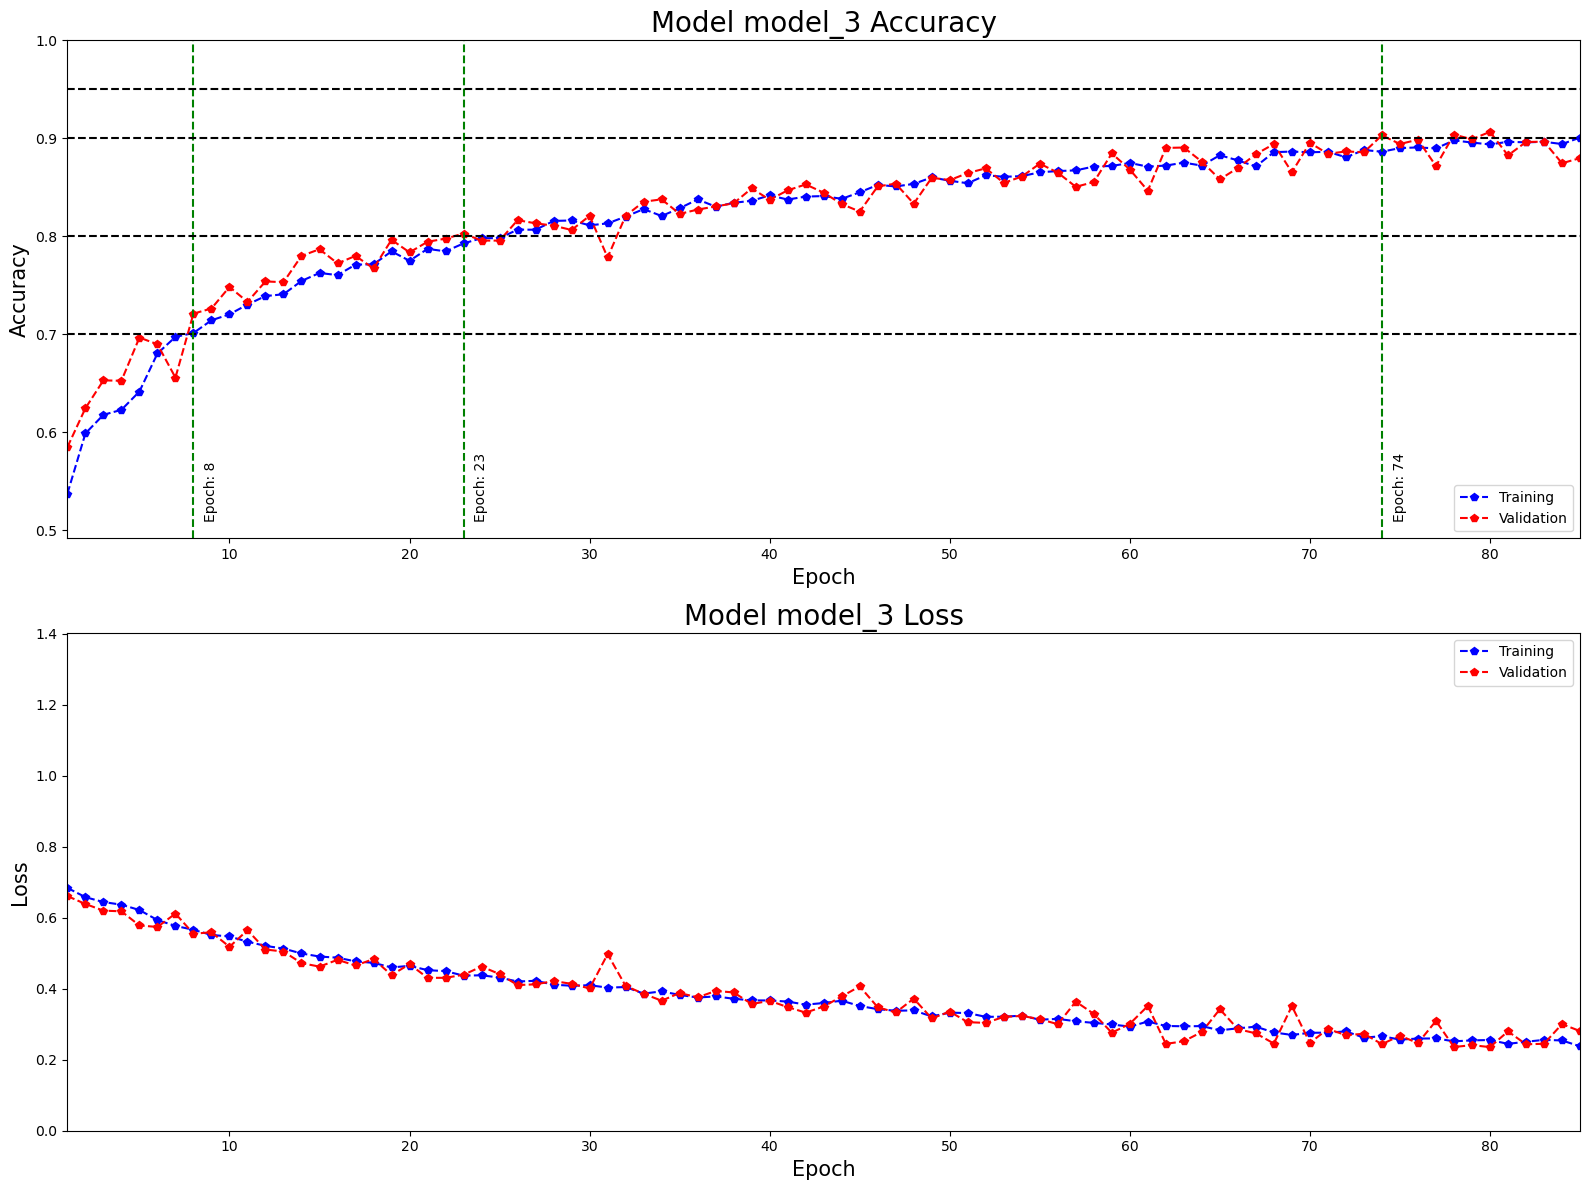

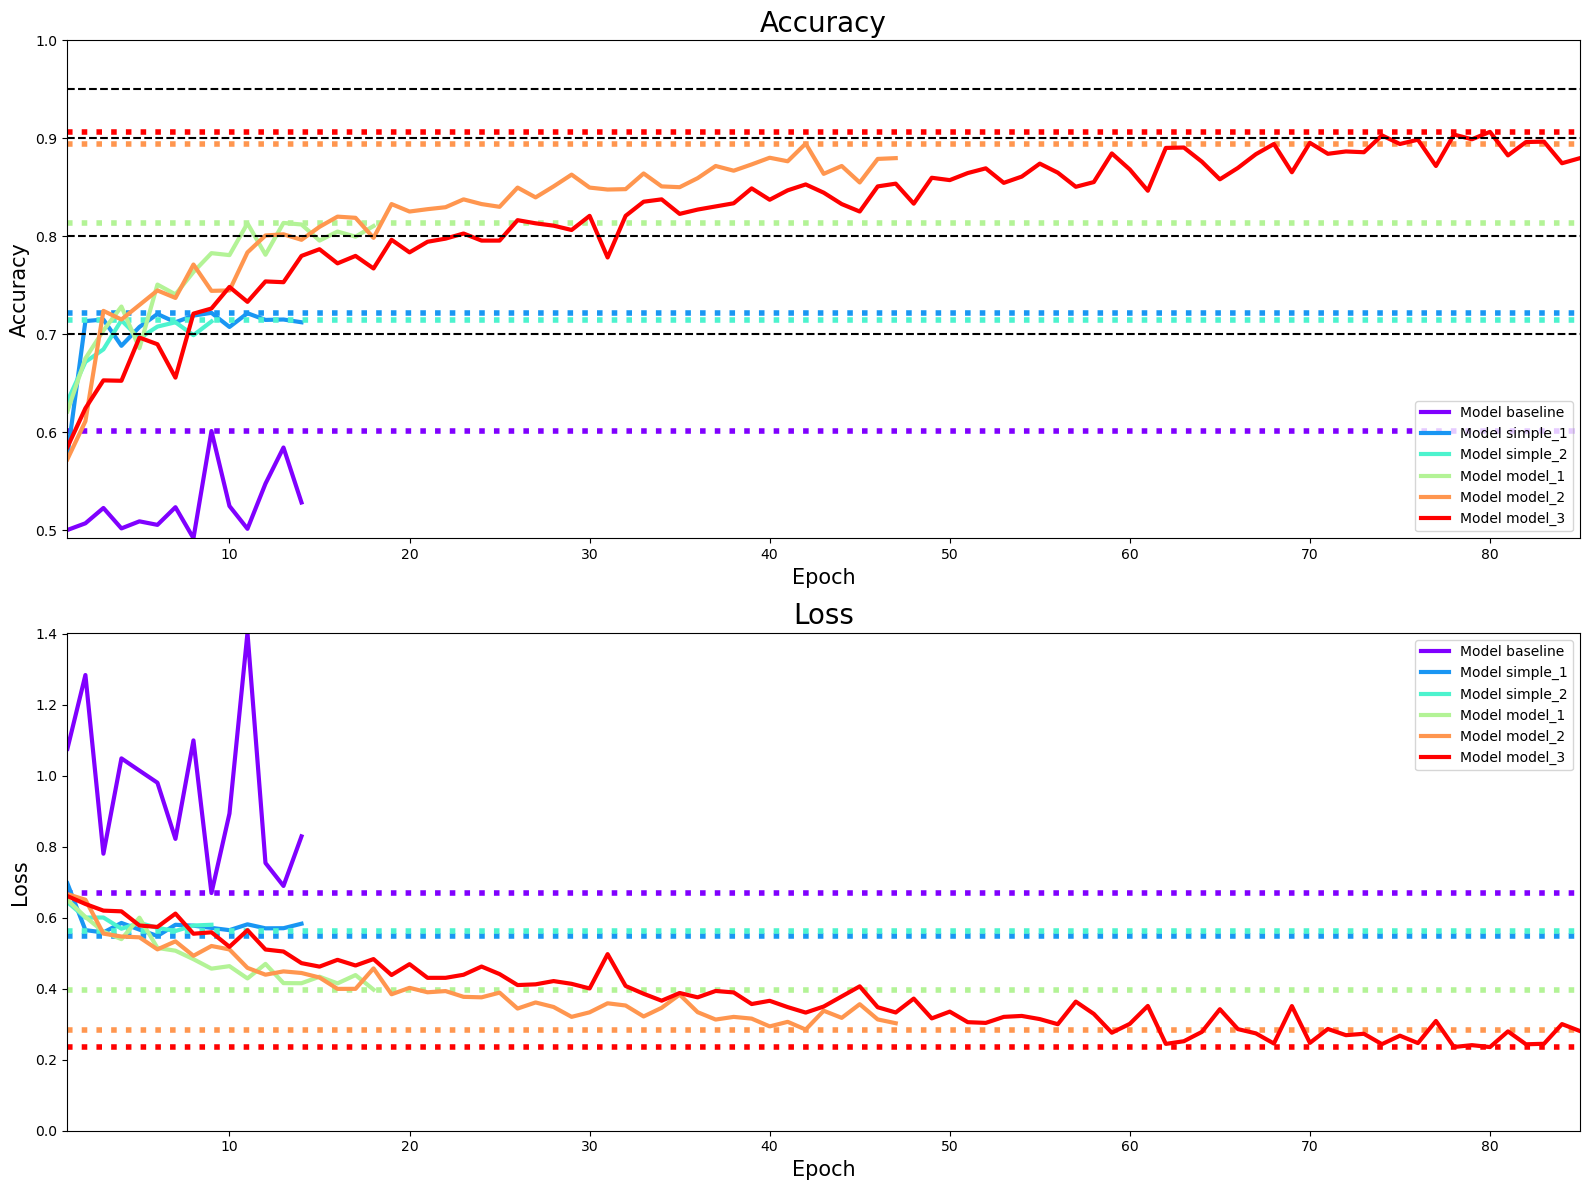

In [27]:
plot_history(models)

In [28]:
from tensorflow.keras.applications import VGG16

vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
vgg16.trainable = True

set_trainable = False
for layer in vgg16.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in vgg16.layers:
    print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

model_4 = Sequential()
model_4.add(vgg16)
model_4.add(Flatten())
model_4.add(Dropout(0.5))
model_4.add(Dense(256, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(128, activation='relu'))
model_4.add(Dense(units=1, activation='sigmoid'))
model_4.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])
model_4.summary()
models.append("model_4")

58889256/58889256 [==============================] - 2s 0us/step
layer_name: input_1       trainable: False
layer_name: block1_conv1  trainable: False
layer_name: block1_conv2  trainable: False
layer_name: block1_pool   trainable: False
layer_name: block2_conv1  trainable: False
layer_name: block2_conv2  trainable: False
layer_name: block2_pool   trainable: False
layer_name: block3_conv1  trainable: False
layer_name: block3_conv2  trainable: False
layer_name: block3_conv3  trainable: False
layer_name: block3_pool   trainable: False
layer_name: block4_conv1  trainable: False
layer_name: block4_conv2  trainable: False
layer_name: block4_conv3  trainable: False
layer_name: block4_pool   trainable: False
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_pool   trainable: True
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Outpu

In [29]:
history_model_4 = model_4.fit(train_generator_augmentation,
                                steps_per_epoch=steps_per_epoch,
                                epochs=epochs,
                                validation_data=validation_generator,
                                validation_steps=validation_steps,
                                callbacks=[es])

history_model_4_df = pd.DataFrame(history_model_4.history)
history_model_4_csv_file = 'history/history_model_4.csv'
with open(history_model_4_csv_file, mode='w') as f:
    history_model_4_df.to_csv(f)

Epoch 1/1000
136/136 [==============================] - 42s 272ms/step - loss: 0.4286 - accuracy: 0.7958 - val_loss: 0.3571 - val_accuracy: 0.8309
Epoch 2/1000
136/136 [==============================] - 35s 254ms/step - loss: 0.2660 - accuracy: 0.8849 - val_loss: 0.1820 - val_accuracy: 0.9311
Epoch 3/1000
136/136 [==============================] - 35s 254ms/step - loss: 0.2254 - accuracy: 0.9059 - val_loss: 0.1661 - val_accuracy: 0.9387
Epoch 4/1000
 35/136 [======>.......................] - ETA: 22s - loss: 0.1981 - accuracy: 0.9147

c:\Users\Urban\.conda\envs\kodilla-edu\lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


136/136 [==============================] - 35s 254ms/step - loss: 0.2062 - accuracy: 0.9138 - val_loss: 0.1545 - val_accuracy: 0.9491
Epoch 5/1000
136/136 [==============================] - 35s 255ms/step - loss: 0.1946 - accuracy: 0.9203 - val_loss: 0.1495 - val_accuracy: 0.9499
Epoch 6/1000
136/136 [==============================] - 35s 256ms/step - loss: 0.1835 - accuracy: 0.9244 - val_loss: 0.1470 - val_accuracy: 0.9539
Epoch 7/1000
136/136 [==============================] - 35s 256ms/step - loss: 0.1712 - accuracy: 0.9327 - val_loss: 0.2085 - val_accuracy: 0.9307
Epoch 8/1000
136/136 [==============================] - 35s 257ms/step - loss: 0.1702 - accuracy: 0.9323 - val_loss: 0.1729 - val_accuracy: 0.9419
Epoch 9/1000
136/136 [==============================] - 35s 255ms/step - loss: 0.1631 - accuracy: 0.9348 - val_loss: 0.1227 - val_accuracy: 0.9579
Epoch 10/1000
136/136 [==============================] - 35s 256ms/step - loss: 0.1615 - accuracy: 0.9409 - val_loss: 0.2886 - val_

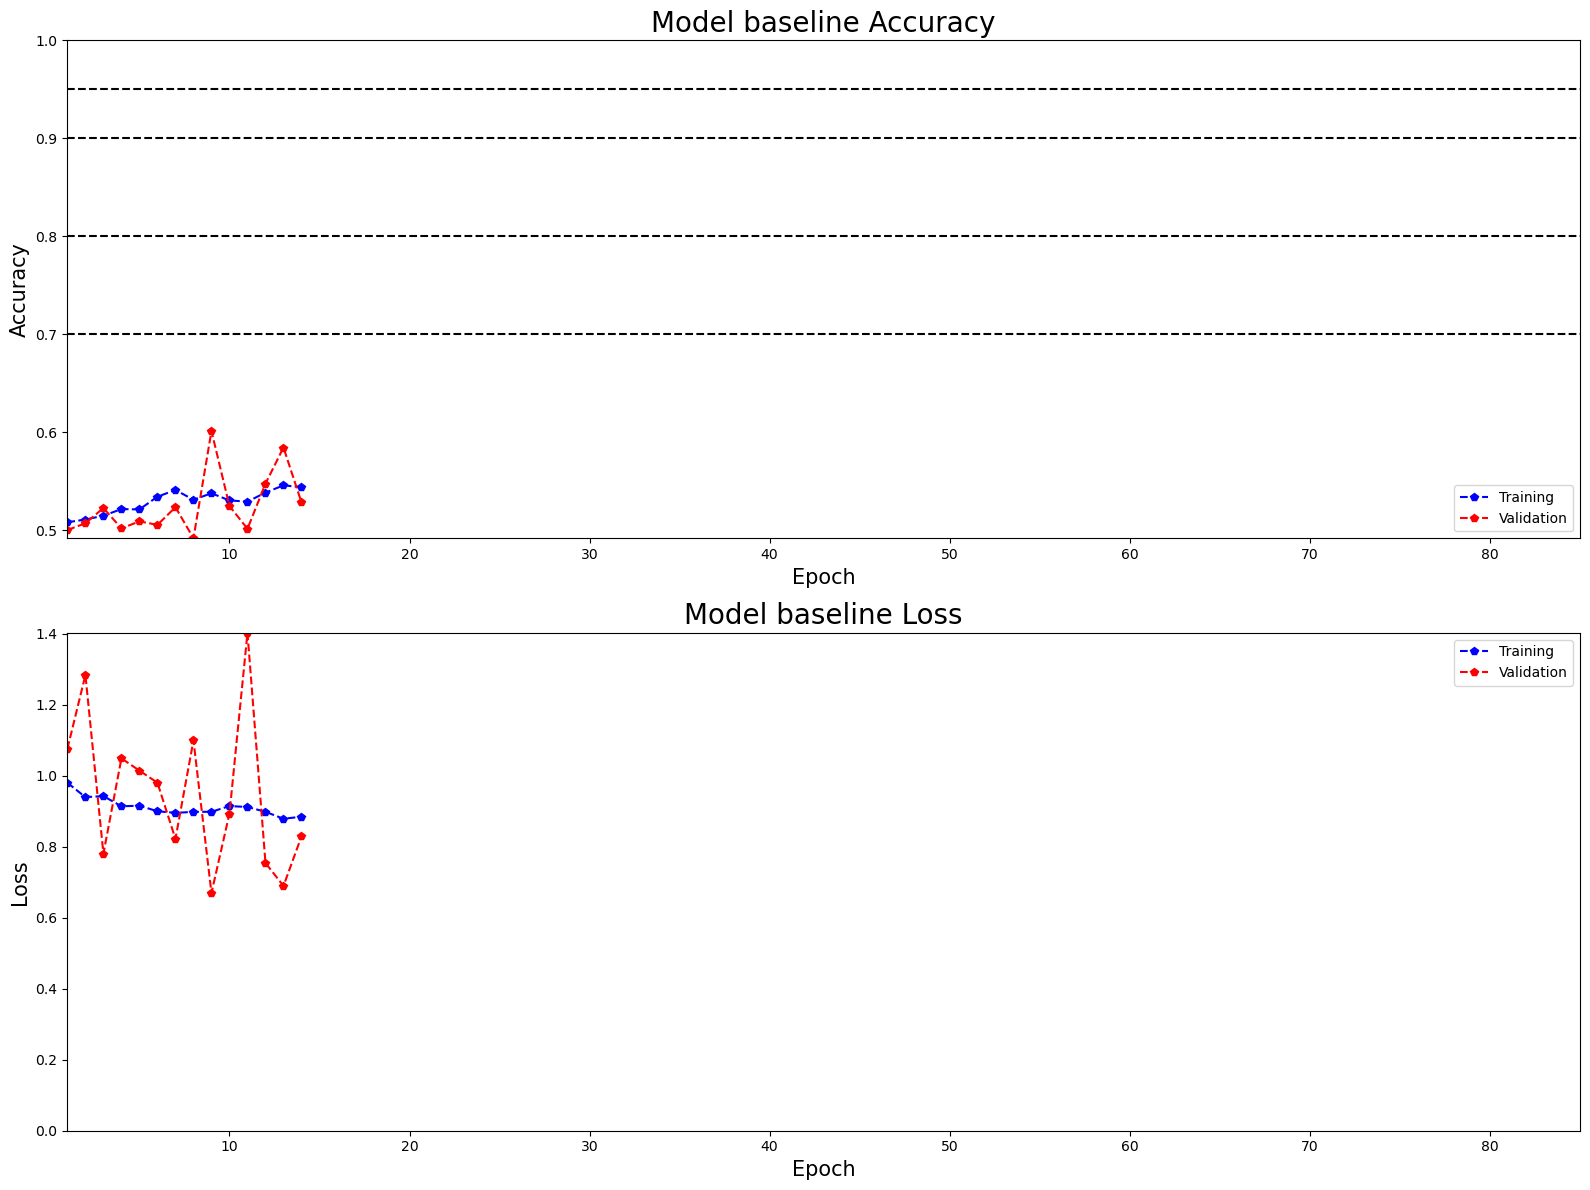

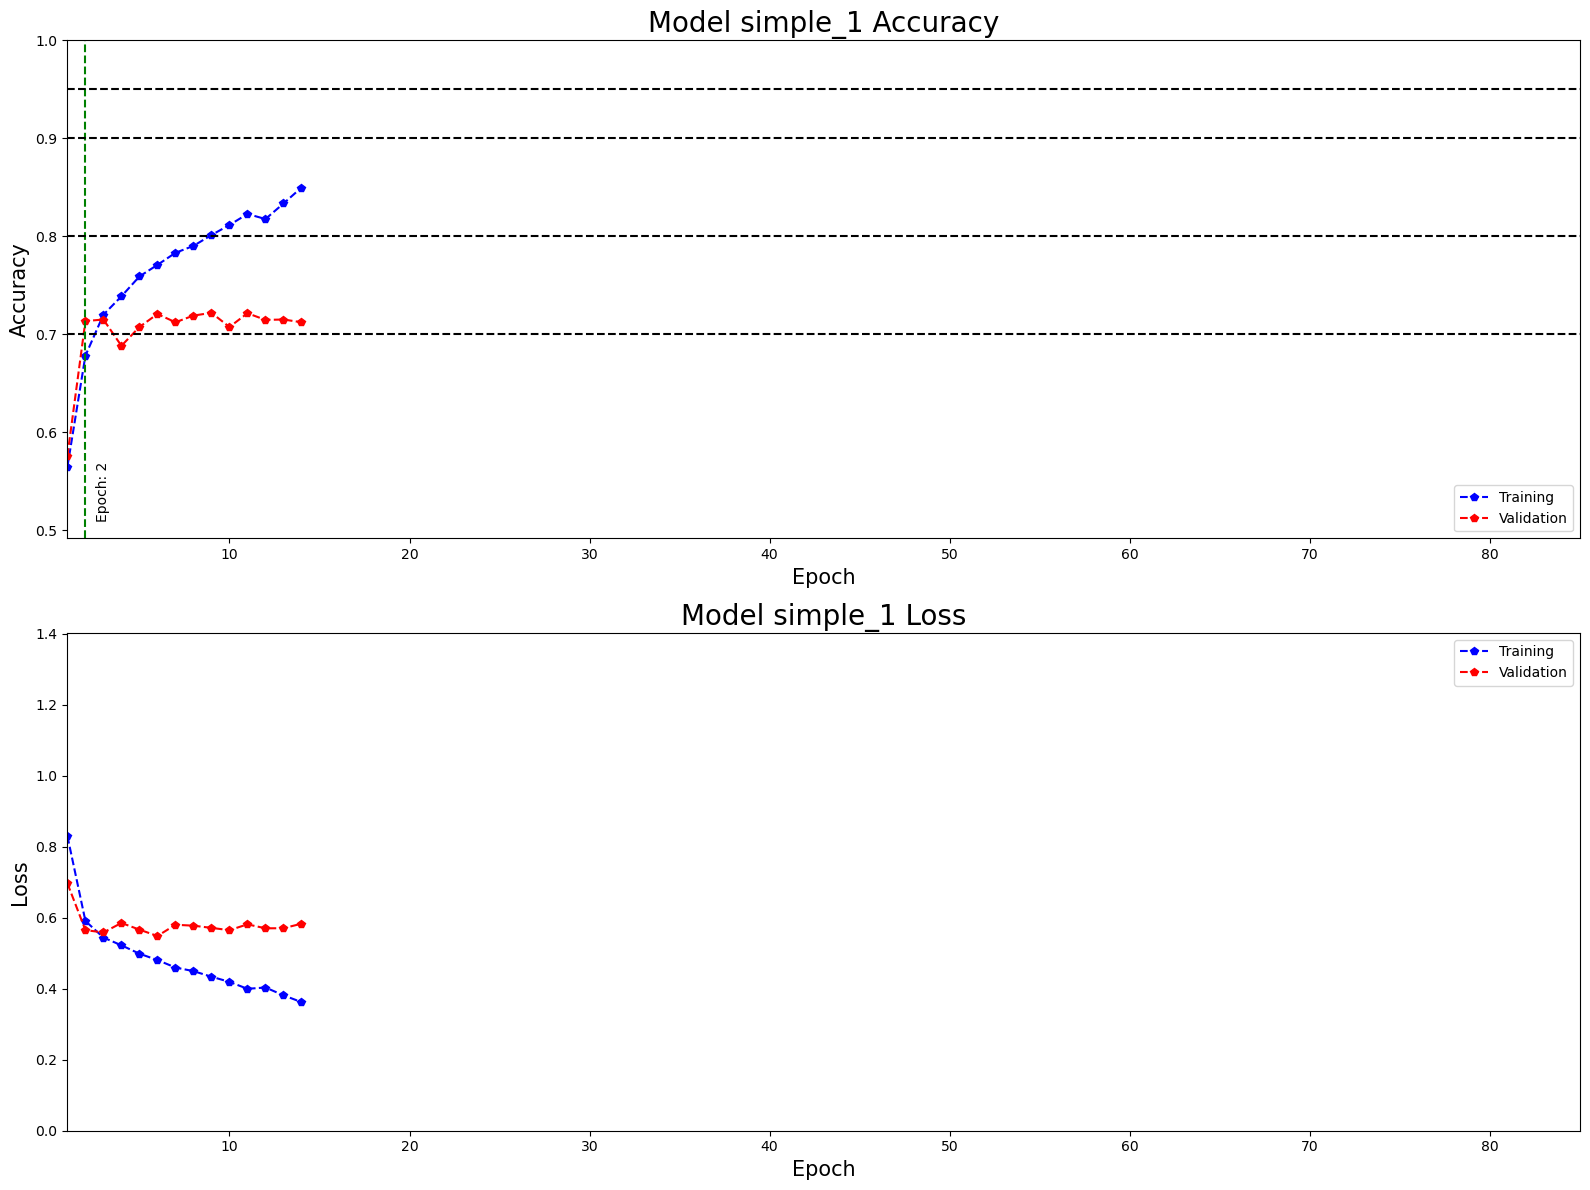

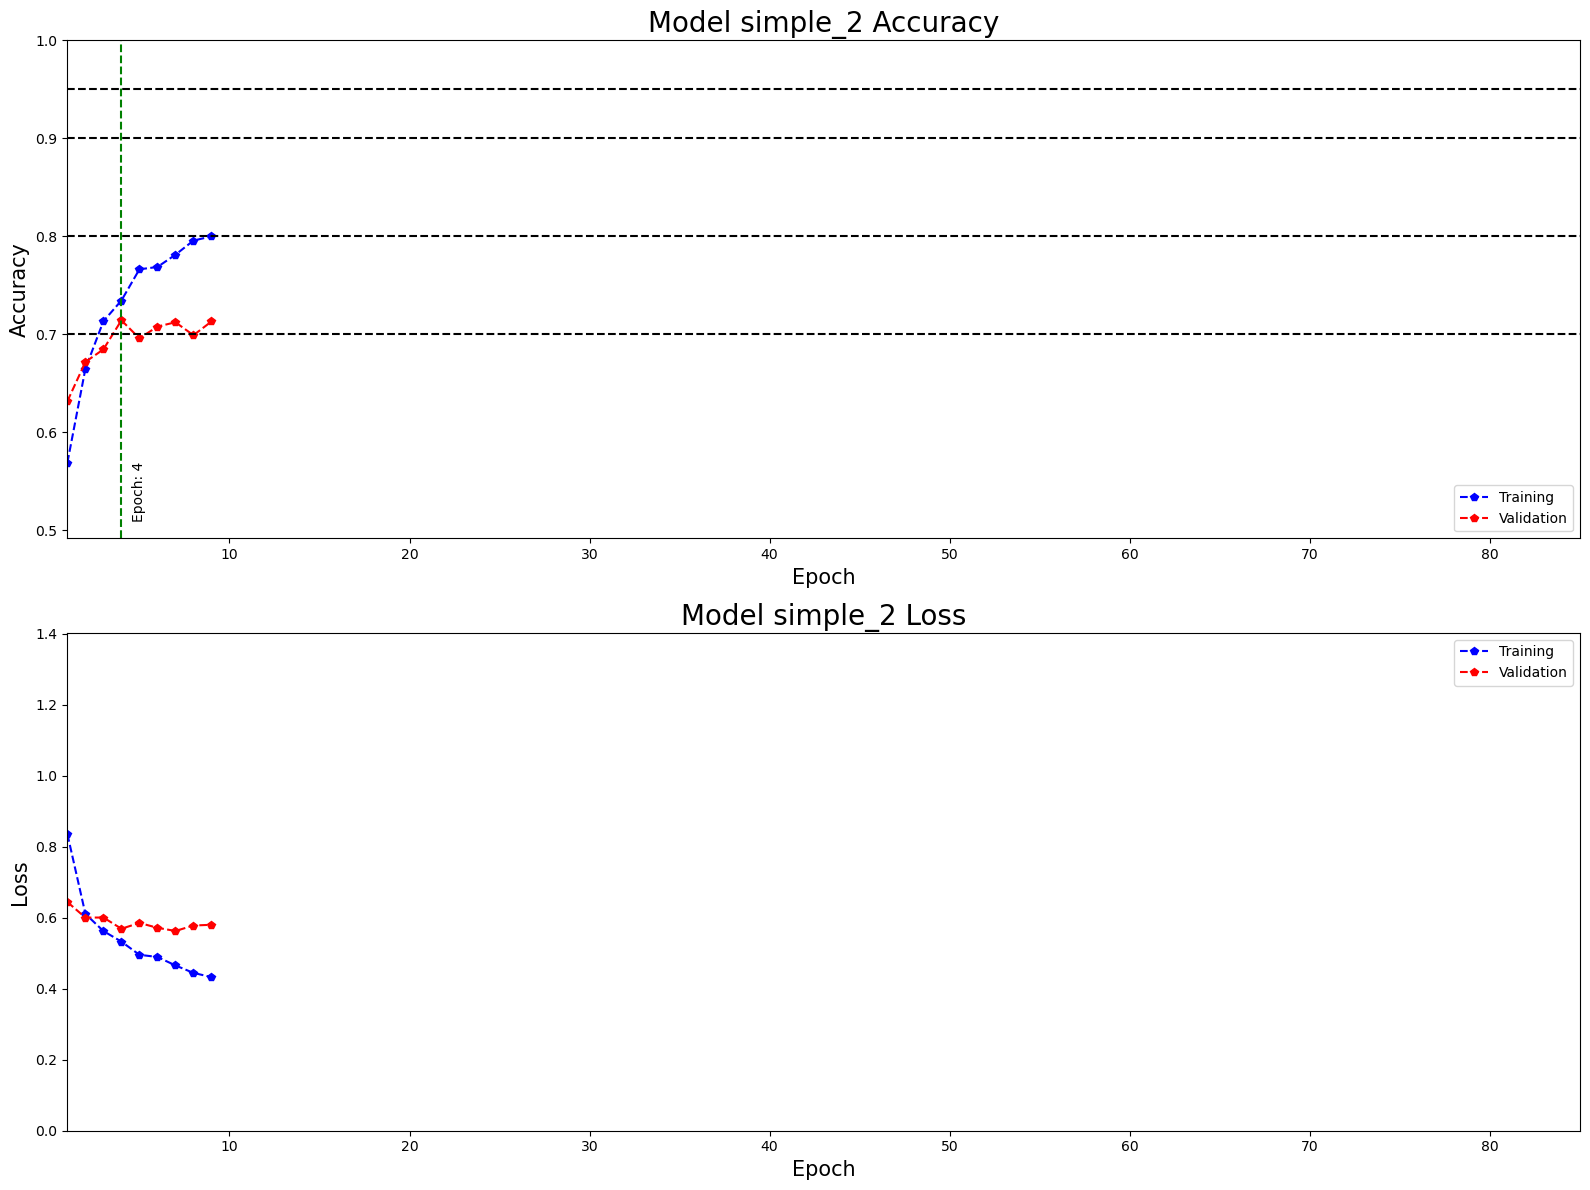

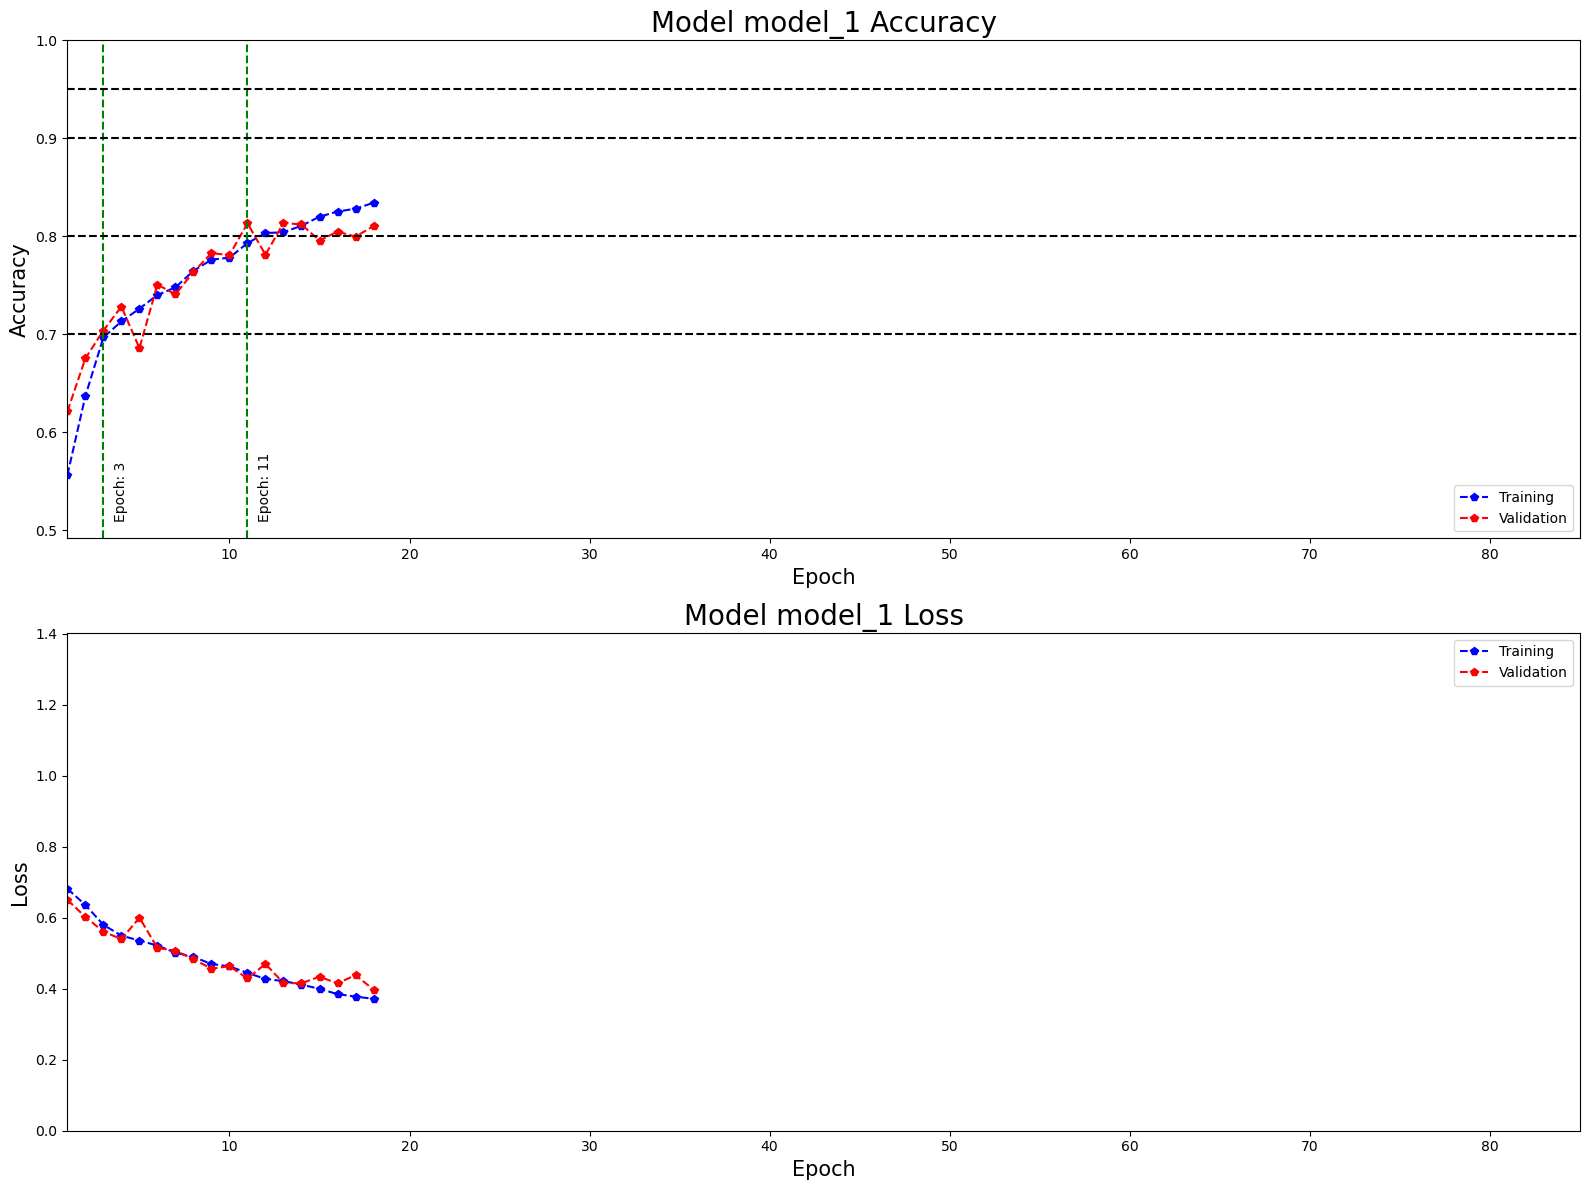

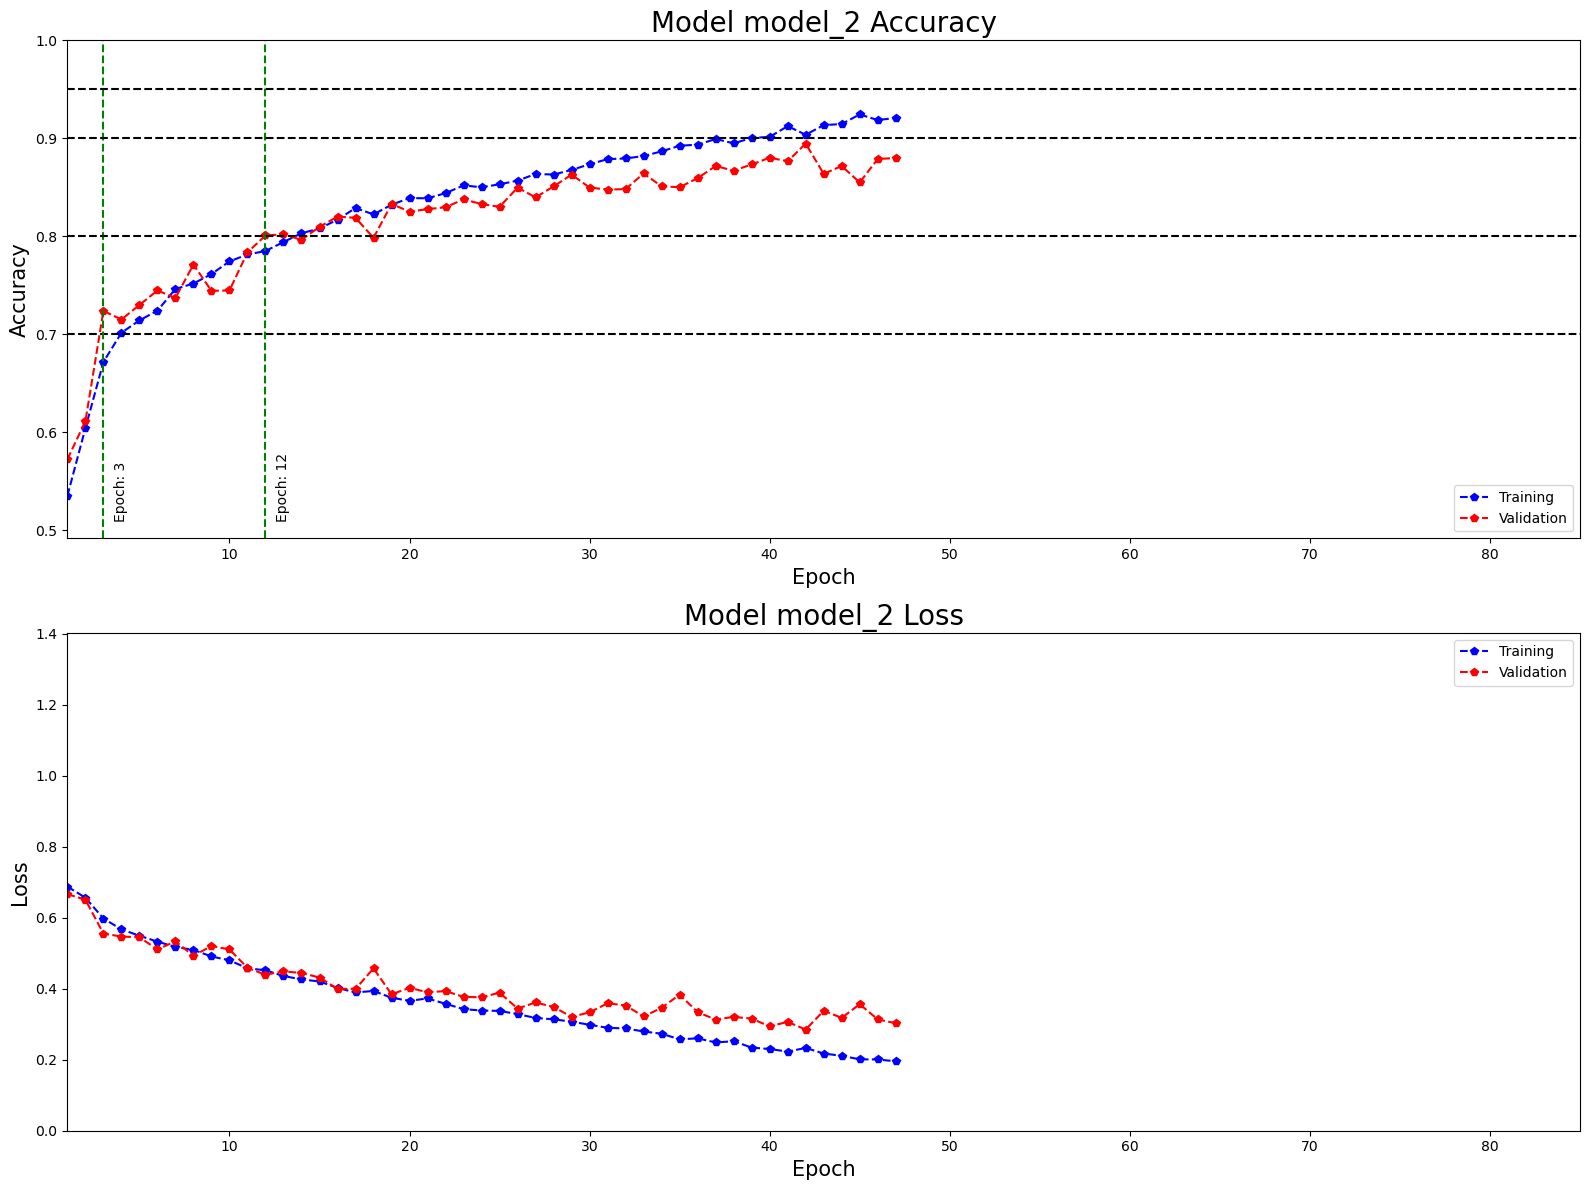

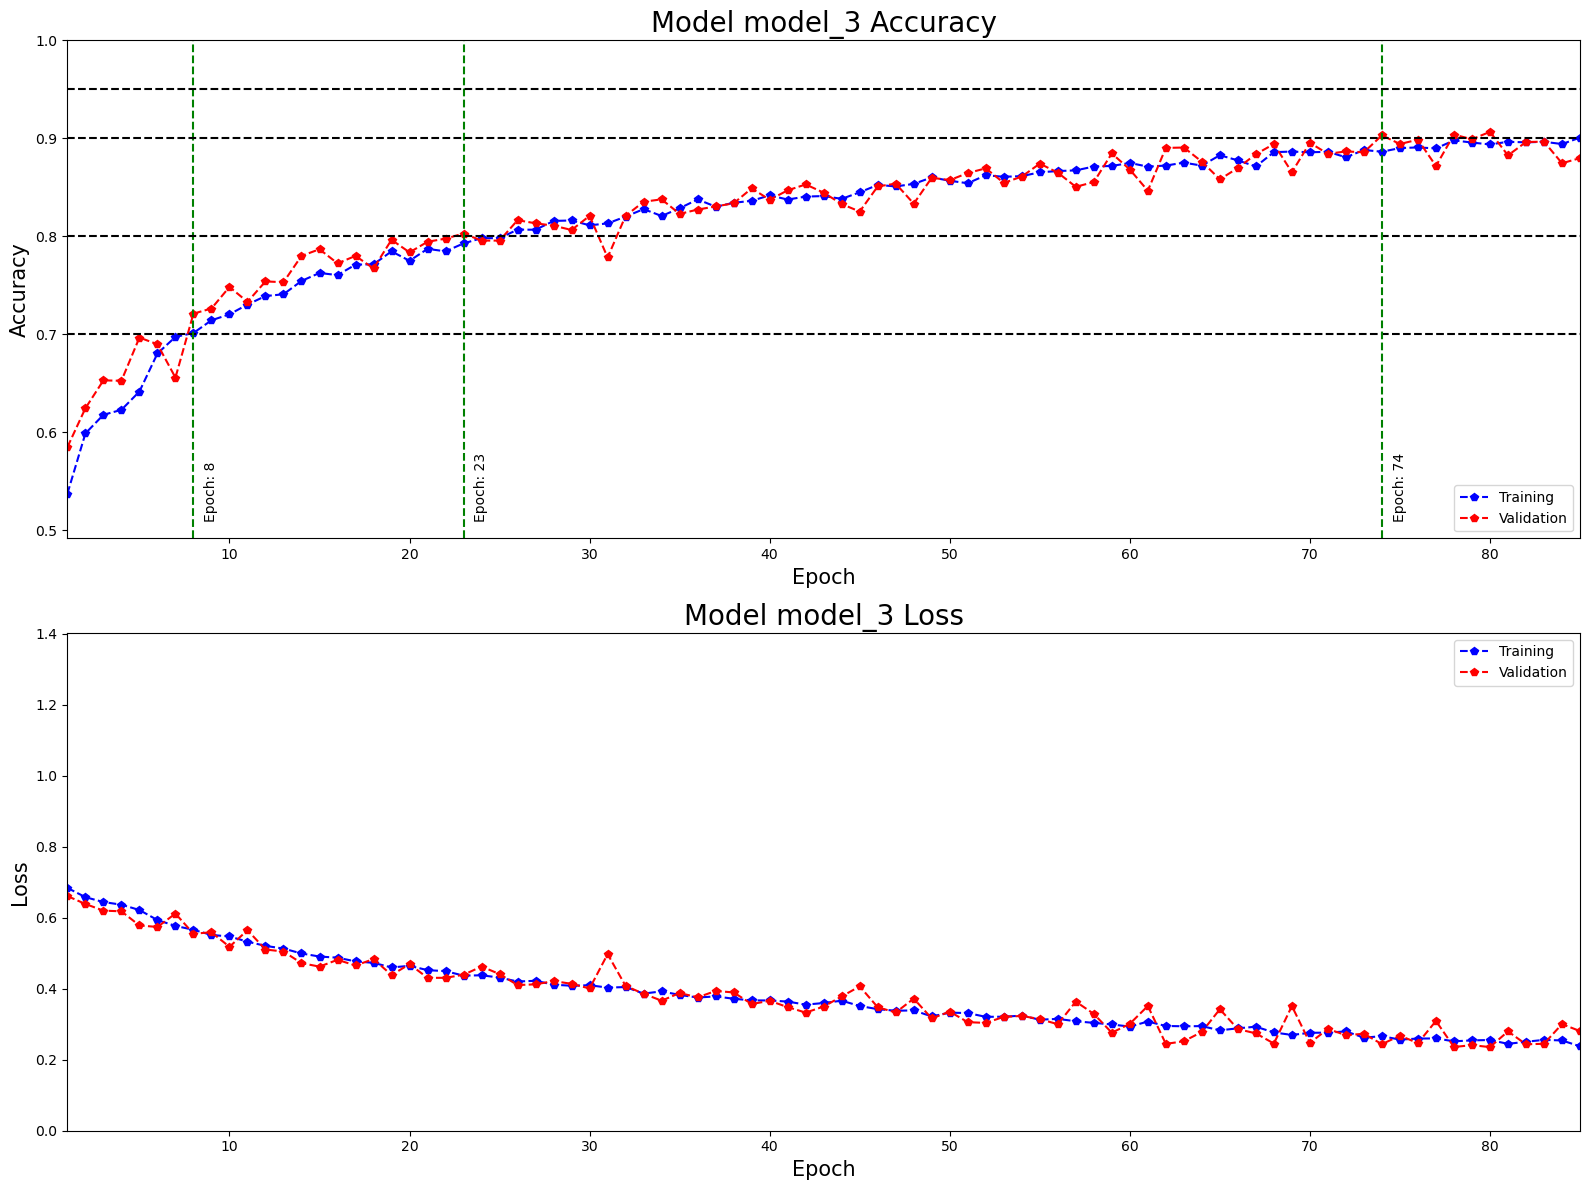

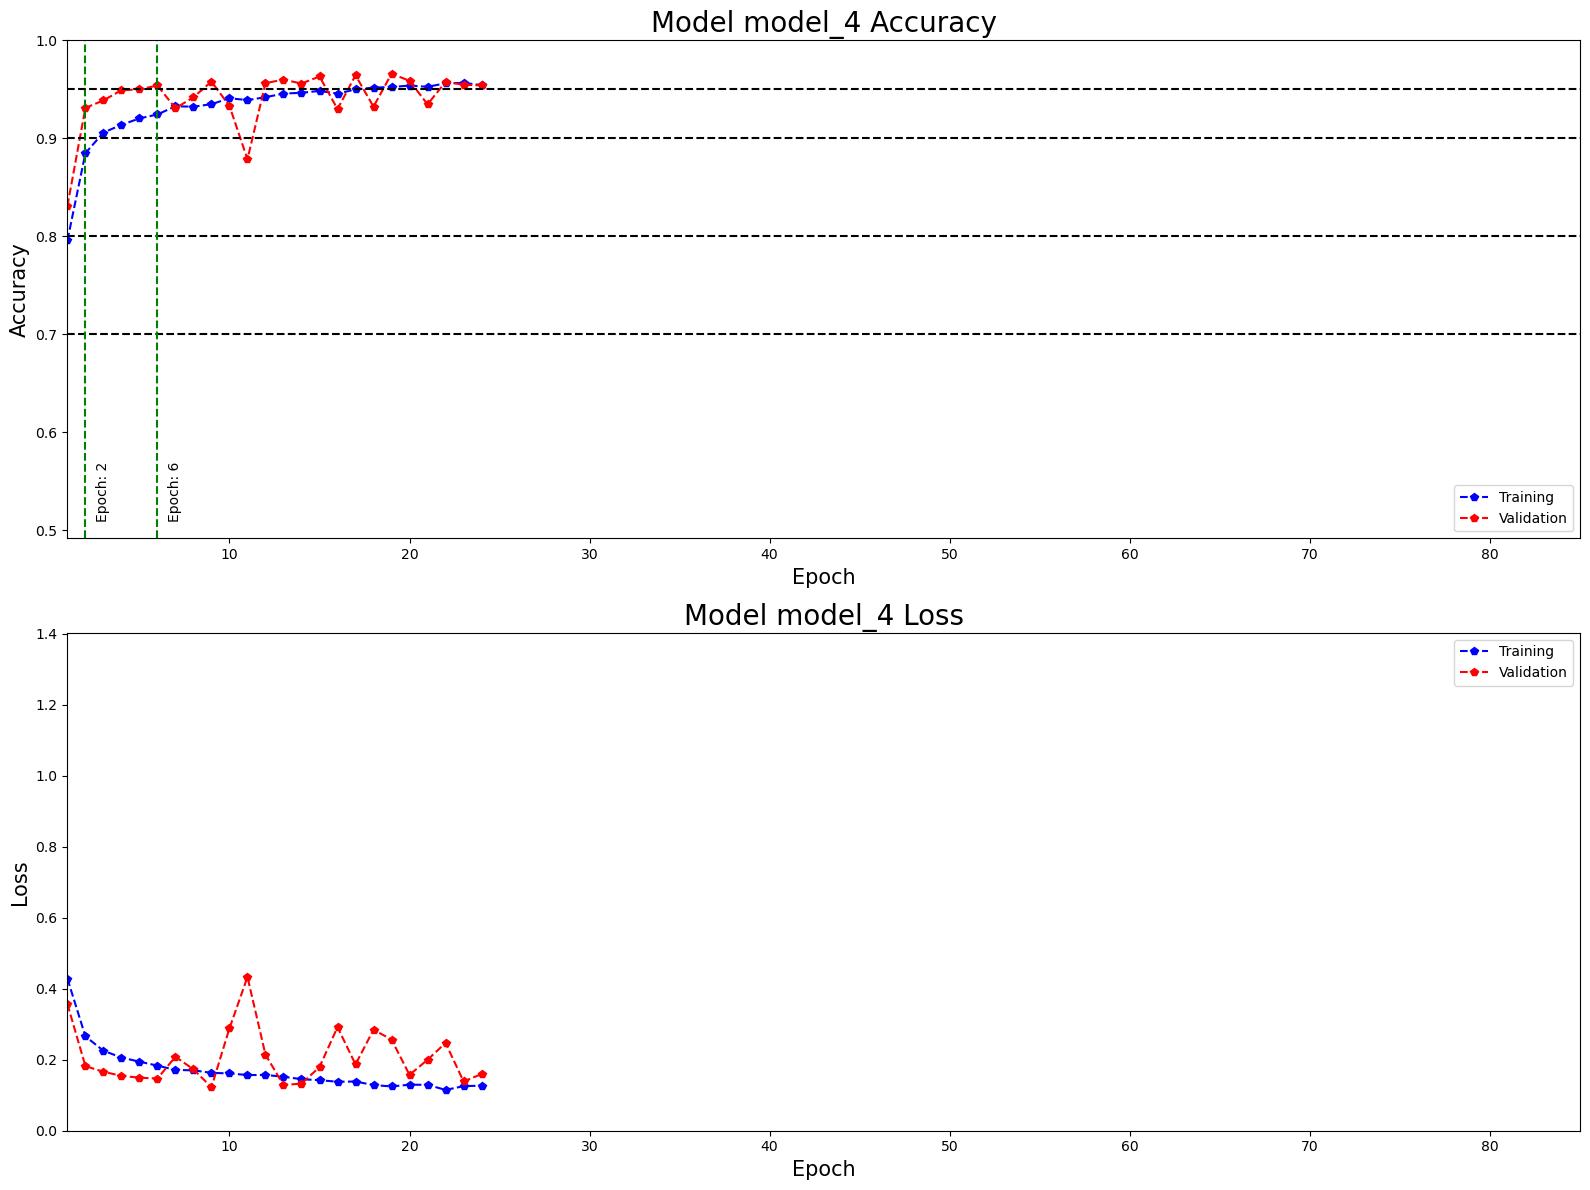

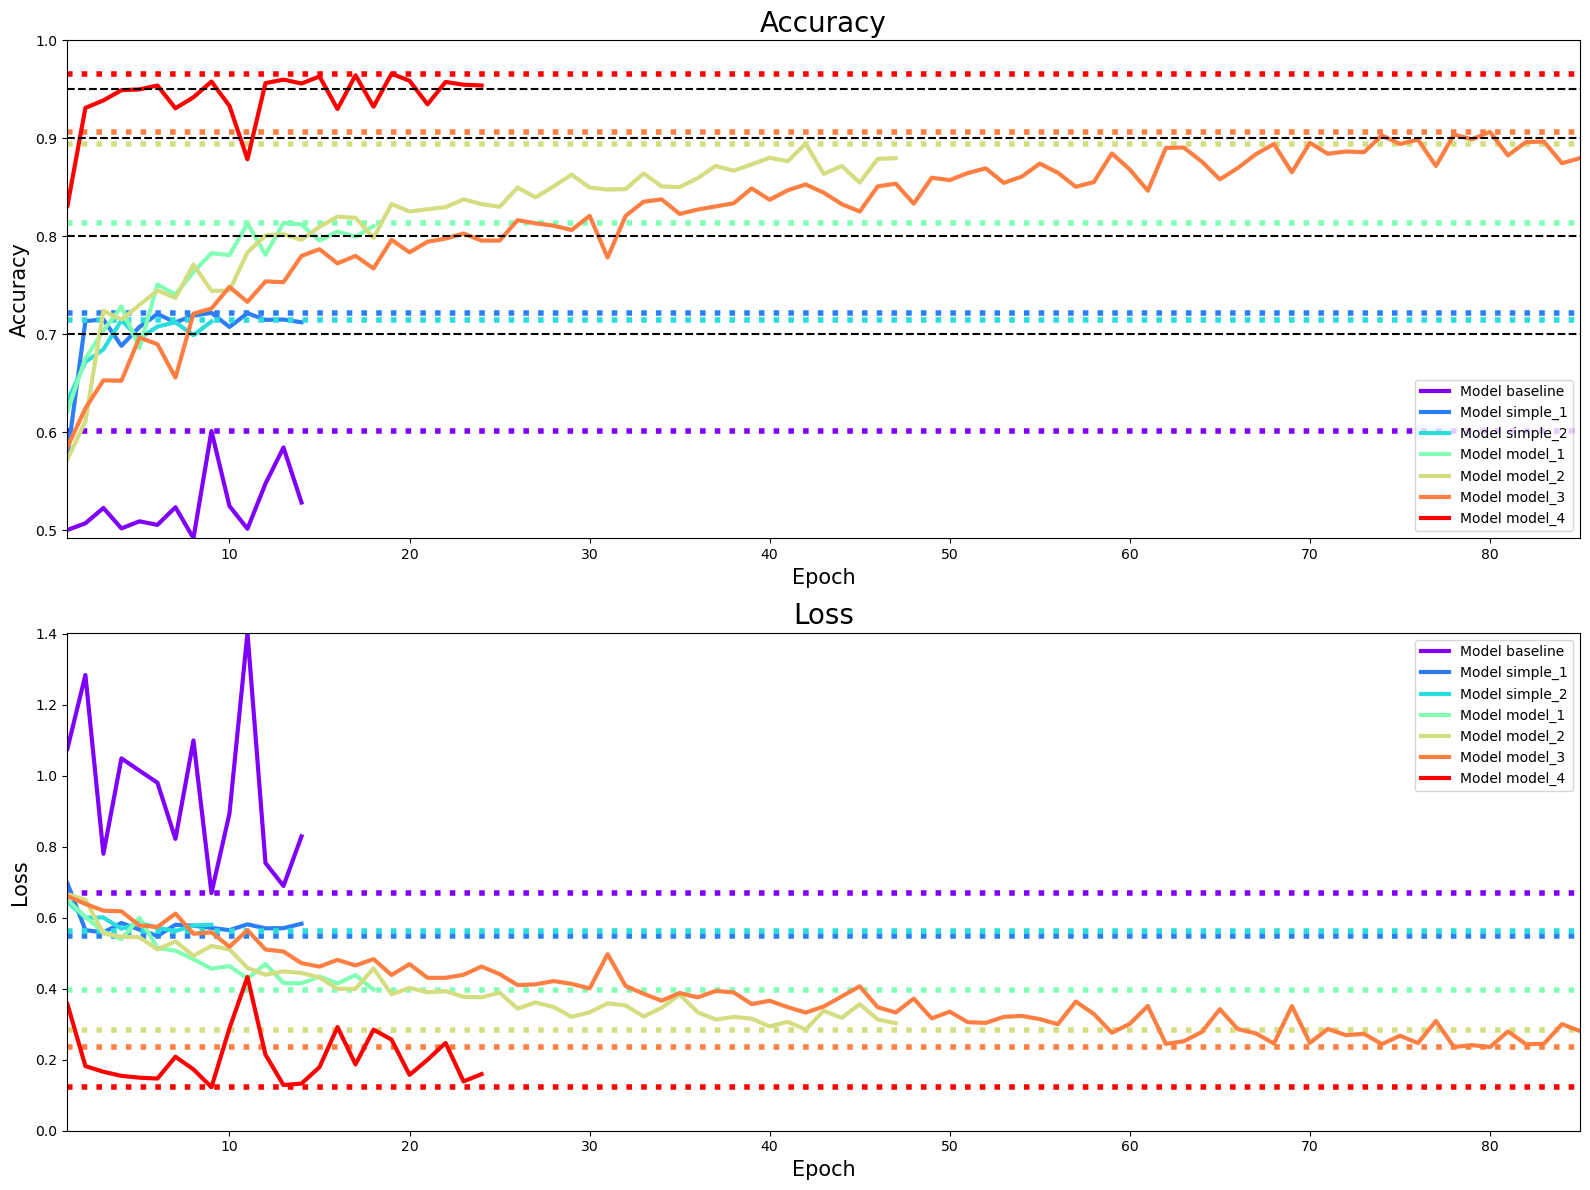

In [30]:
plot_history(models)

In [42]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def prepare_image(image_path, target_size=(150, 150)):
    # Ładowanie i zmiana rozmiaru zdjęcia
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    # Standaryzacja (tak jak przy trenowaniu)
    img_array = img_array / 255.0
    # Dodanie wymiaru batcha
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Ścieżka do Twojego zdjęcia kota
mycat = 'test/Ciuciema2.jpg'
mycat_prep = prepare_image(mycat)

# Zakładając, że Twój model nazywa się model_...
prediction = model_4.predict(mycat_prep)

# Jeśli używasz funkcji sigmoidalnej na wyjściu:
if prediction < 0.5:
    print("Model przewiduje: Kot")
else:
    print("Model przewiduje: Pies")

1/1 [==============================] - 0s 10ms/step
Model przewiduje: Kot
